In [ ]:
!pip install pycryptodome opencv-python

import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


In [ ]:
print("Please upload an image:")
uploaded = files.upload()  # This will prompt you to select an image file
image_name = list(uploaded.keys())[0]  # Get the filename of the uploaded image
print("Uploaded image:", image_name)


Please upload an image:


Saving sample.jpg to sample (1).jpg
Uploaded image: sample (1).jpg


In [ ]:
# If you haven't uploaded base.py already, do so:
from google.colab import files
files.upload()  # Upload your base.py file

from base import ImageCryptography


Saving base.py to base (1).py


In [ ]:
# Create an instance of ImageCryptography with the desired method
crypto = ImageCryptography(method="aes_chaotic")

# Encrypt the image and save to 'encrypted.npz'
print("\n=== Encrypting image ===")
encrypt_results = crypto.encrypt(image_name, "encrypted.npz")
print(f"Encryption completed in {encrypt_results['encryption_time']:.4f} seconds")
print(f"Original size: {encrypt_results['size_original']} bytes")
print(f"Encrypted size: {encrypt_results['size_encrypted']} bytes")



=== Encrypting image ===
Encryption completed in 199.9592 seconds
Original size: 53747712 bytes
Encrypted size: 53748544 bytes


In [ ]:
print("\n=== Decrypting image ===")
decrypt_results = crypto.decrypt("encrypted.npz", "decrypted.jpg")
print(f"Decryption completed in {decrypt_results['decryption_time']:.4f} seconds")



=== Decrypting image ===


TypeError: len() of unsized object

In [ ]:
# Read original and decrypted images
original = cv2.imread(image_name)
decrypted = decrypt_results['decrypted_image']

# Display images side-by-side
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(original, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(122)
plt.title("Decrypted Image")
plt.imshow(cv2.cvtColor(decrypted, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [ ]:
"""
Comprehensive Image Cryptography System
Tasks:
 1. Image Preprocessing:
    - Read image, convert to RGB or grayscale.
    - Dynamically resize based on simulated bandwidth constraints.
 2. Encryption:
    - Chaos-based encryption (using Arnold’s Cat Map).
    - Divide & Conquer encryption (splitting the image into blocks and encrypting each block separately using AES).
    - Dynamic key generation via a chaotic logistic map.
    - Geometric scrambling using an affine transformation.
 3. Secure Transmission:
    - Simulate network flow (Ford-Fulkerson style) to determine a compression ratio.
    - Adaptive encryption-compression balance using a simulated branch & bound.
 4. Decryption & Integrity Verification:
    - Reverse the encryption steps.
    - Compute similarity metrics: MSE, PSNR, SSIM, entropy, and histogram deviation.
    - Compute a SHA256 hash of the original image for authentication.
 5. Performance Analysis:
    - Measure encryption/decryption times and output quality metrics.

This script is written to be runnable in Google Colab.
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
import hashlib
import time
import concurrent.futures
from skimage.metrics import structural_similarity as ssim
from google.colab import files
import os
from scipy.stats import entropy
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes

#######################
# 1. Image Preprocessing
#######################

def preprocess_image(image_path, convert_to='rgb', target_bandwidth=1e6):
    """
    Read an image, convert its format, and resize if necessary.

    Args:
      image_path: Path to input image.
      convert_to: 'rgb' or 'grayscale'
      target_bandwidth: Maximum size in bytes (simulate network constraints)

    Returns:
      Preprocessed image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read image at " + image_path)

    # Convert image format
    if convert_to.lower() == 'grayscale':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif convert_to.lower() == 'rgb':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Compress temporarily to JPEG and check size
    ret, buf = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
    size = len(buf)
    if size > target_bandwidth:
        # Calculate a scaling factor (square-root relation)
        scale = np.sqrt(target_bandwidth / size)
        new_width = int(image.shape[1] * scale)
        new_height = int(image.shape[0] * scale)
        image = cv2.resize(image, (new_width, new_height))
    return image

#######################
# 2. Encryption Components
#######################

# Arnold's Cat Map (chaos-based pixel shuffling)
def arnold_cat_map(image, iterations=1):
    h, w = image.shape[:2]
    # We'll operate on the top-left square region n×n:
    n = min(h, w)

    for _ in range(iterations):
        new_region = np.zeros_like(image[0:n, 0:n])
        for i in range(n):
            for j in range(n):
                new_i = (i + j) % n
                new_j = (i + 2*j) % n
                new_region[new_i, new_j] = image[i, j]
        # Put scrambled region back into original
        image[0:n, 0:n] = new_region

    return image

def inverse_arnold_cat_map(image, iterations=1):
    h, w = image.shape[:2]
    n = min(h, w)

    for _ in range(iterations):
        new_region = np.zeros_like(image[0:n, 0:n])
        for new_i in range(n):
            for new_j in range(n):
                # Solve for old i, j
                i = (2*new_i - new_j) % n
                j = (new_j - new_i) % n
                new_region[new_i, new_j] = image[i, j]
        # Put descrambled region back
        image[0:n, 0:n] = new_region

    return image


# Dynamic key generation via a logistic map
def generate_dynamic_key(key_length=32):
    x = 0.1
    r = 3.99
    seq = []
    for _ in range(key_length):
        x = r * x * (1 - x)
        seq.append(x)
    seq = np.array(seq)
    key = hashlib.sha256(seq.tobytes()).digest()
    return key

# AES encryption/decryption helpers (with PKCS7 padding)
def pad(data):
    bs = AES.block_size
    pad_len = bs - (len(data) % bs)
    return data + bytes([pad_len]) * pad_len

def unpad(data):
    pad_len = data[-1]
    return data[:-pad_len]

def aes_encrypt(data, key):
    iv = get_random_bytes(AES.block_size)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    encrypted = cipher.encrypt(pad(data))
    return encrypted, iv

def aes_decrypt(encrypted, key, iv):
    cipher = AES.new(key, AES.MODE_CBC, iv)
    decrypted = unpad(cipher.decrypt(encrypted))
    return decrypted

# Divide & Conquer encryption: split image into blocks, encrypt each block
def block_encrypt(image, key, block_size=64):
    h, w = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2]
    enc_blocks = []
    ivs = []
    # Process image block by block
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:min(i+block_size, h), j:min(j+block_size, w)]
            block_bytes = block.tobytes()
            enc_block, iv = aes_encrypt(block_bytes, key)
            enc_blocks.append(enc_block)
            ivs.append(iv)
    dims = (h, w, channels)
    return enc_blocks, ivs, dims

def block_decrypt(enc_blocks, ivs, key, dims, block_size=64):
    h, w, channels = dims
    image = np.zeros((h, w, channels), dtype=np.uint8)
    idx = 0
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dec_block = aes_decrypt(enc_blocks[idx], key, ivs[idx])
            block_height = min(block_size, h - i)
            block_width = min(block_size, w - j)
            block = np.frombuffer(dec_block, dtype=np.uint8).reshape((block_height, block_width, channels))
            image[i:i+block_height, j:j+block_width] = block
            idx += 1
    return image

# Geometric scrambling using an affine transformation
def geometric_scramble(image, M=None):
    h, w = image.shape[:2]
    if M is None:
        # Create a random affine transform matrix
        pts1 = np.float32([[0, 0], [w, 0], [0, h]])
        pts2 = pts1 + np.random.randint(-20, 20, pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
    scrambled = cv2.warpAffine(image, M, (w, h))
    return scrambled, M

def geometric_descramble(image, M):
    h, w = image.shape[:2]
    Minv = cv2.invertAffineTransform(M)
    descrambled = cv2.warpAffine(image, Minv, (w, h))
    return descrambled

#######################
# 3. Secure Transmission Simulation
#######################

def simulate_network_flow(image_size, network_capacity):
    """
    Simulate a network flow algorithm to determine a compression ratio.

    Args:
      image_size: size in bytes.
      network_capacity: capacity in bytes per second.

    Returns:
      A ratio between 0 and 1.
    """
    ratio = min(1.0, network_capacity / image_size)
    return ratio

def adaptive_encryption(image, network_capacity):
    """
    Adjust JPEG quality based on simulated network conditions.
    """
    ret, buf = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), 90])
    jpeg_size = len(buf)
    ratio = simulate_network_flow(jpeg_size, network_capacity)
    quality = int(90 * ratio)  # lower quality if bandwidth is low
    ret, buf = cv2.imencode('.jpg', image, [int(cv2.IMWRITE_JPEG_QUALITY), quality])
    compressed_image = cv2.imdecode(np.frombuffer(buf, np.uint8), cv2.IMREAD_COLOR)
    # Convert to RGB for consistency
    compressed_image = cv2.cvtColor(compressed_image, cv2.COLOR_BGR2RGB)
    return compressed_image, quality

#######################
# 4. Decryption & Integrity Verification
#######################

def compute_image_hash(image):
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

def compute_mse(imageA, imageB):
    err = np.mean((imageA.astype("float") - imageB.astype("float")) ** 2)
    return err

def compute_psnr(imageA, imageB):
    mse_val = compute_mse(imageA, imageB)
    if mse_val == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse_val))

def compute_ssim(imageA, imageB):
    if len(imageA.shape) == 3:
        imageA_gray = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
        imageB_gray = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)
    else:
        imageA_gray = imageA
        imageB_gray = imageB
    return ssim(imageA_gray, imageB_gray)

def compute_entropy(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    hist = hist.ravel() / hist.sum()
    return entropy(hist)

def histogram_deviation(imageA, imageB):
    histA = cv2.calcHist([imageA], [0], None, [256], [0,256])
    histB = cv2.calcHist([imageB], [0], None, [256], [0,256])
    return np.linalg.norm(histA - histB)

#######################
# 5. Full Encryption / Decryption & Performance Analysis
#######################

def full_encrypt(image):
    results = {}
    start_time = time.time()

    # Save original hash for authentication
    orig_hash = compute_image_hash(image)
    results['original_hash'] = orig_hash

    # Adaptive compression based on simulated network capacity
    network_capacity = 500000  # bytes per second (simulation)
    image_compressed, quality = adaptive_encryption(image, network_capacity)
    results['compression_quality'] = quality

    # Chaos-based encryption: Apply Arnold’s Cat Map
    image_chaos = arnold_cat_map(np.copy(image_compressed), iterations=5)

    # Geometric scrambling: affine transformation
    image_geo, affine_M = geometric_scramble(image_chaos)
    results['affine_matrix'] = affine_M.tolist()

    # Divide & Conquer encryption: block encryption using AES
    key = generate_dynamic_key()
    enc_blocks, ivs, dims = block_encrypt(image_geo, key, block_size=64)
    results['enc_blocks'] = enc_blocks   # stored in memory for this demo
    results['ivs'] = ivs
    results['dims'] = dims
    results['key'] = key

    results['encryption_time'] = time.time() - start_time
    return results

def full_decrypt(results):
    start_time = time.time()
    key = results['key']
    enc_blocks = results['enc_blocks']
    ivs = results['ivs']
    dims = results['dims']

    # Block decryption
    image_geo = block_decrypt(enc_blocks, ivs, key, dims, block_size=64)

    # Reverse geometric scrambling
    affine_M = np.array(results['affine_matrix'])
    image_dgeo = geometric_descramble(image_geo, affine_M)

    # Reverse chaos-based encryption: inverse Arnold’s Cat Map
    image_dechaos = inverse_arnold_cat_map(image_dgeo, iterations=5)

    decryption_time = time.time() - start_time
    dec_hash = compute_image_hash(image_dechaos)
    return image_dechaos, dec_hash, decryption_time

def performance_analysis(original, decrypted):
    analysis = {}
    analysis['MSE'] = compute_mse(original, decrypted)
    analysis['PSNR'] = compute_psnr(original, decrypted)
    analysis['SSIM'] = compute_ssim(original, decrypted)
    analysis['Entropy_Original'] = compute_entropy(original)
    analysis['Entropy_Decrypted'] = compute_entropy(decrypted)
    analysis['Histogram_Deviation'] = histogram_deviation(original, decrypted)
    return analysis

#######################
# Main function (runnable in Colab)
#######################

def main():
    # Step 1: Upload Image
    print("Please upload an image:")
    uploaded = files.upload()
    image_filename = list(uploaded.keys())[0]

    # Step 2: Preprocess Image
    image = preprocess_image(image_filename, convert_to='rgb', target_bandwidth=1e6)
    plt.figure(figsize=(6,4))
    plt.imshow(image)
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()

    # Step 3: Encrypt Image
    print("Encrypting image...")
    enc_results = full_encrypt(image)
    print(f"Encryption completed in {enc_results['encryption_time']:.4f} seconds")

    # Step 4: Decrypt Image
    print("Decrypting image...")
    decrypted_image, dec_hash, decryption_time = full_decrypt(enc_results)
    print(f"Decryption completed in {decryption_time:.4f} seconds")

    # Step 5: Integrity Verification
    if enc_results['original_hash'] == dec_hash:
        print("Integrity verified: Image hash matches.")
    else:
        print("Warning: Image hash does not match!")

    # Step 6: Performance Analysis
    analysis = performance_analysis(image, decrypted_image)
    print("Performance Analysis:")
    for k, v in analysis.items():
        print(f"{k}: {v}")

    # Display Decrypted Image
    plt.figure(figsize=(6,4))
    plt.imshow(decrypted_image)
    plt.title("Decrypted Image")
    plt.axis('off')
    plt.show()

    # Save and download decrypted image
    # (Convert back to BGR for saving with OpenCV)
    decrypted_bgr = cv2.cvtColor(decrypted_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("decrypted_result.jpg", decrypted_bgr)
    print("Downloading decrypted_result.jpg ...")
    files.download("decrypted_result.jpg")

if __name__ == "__main__":
    main()


Please upload an image:


KeyboardInterrupt: 

In [ ]:
!pip install pycryptodome opencv-python scikit-image scipy


Please upload an image:


Saving sample.jpg to sample (6).jpg


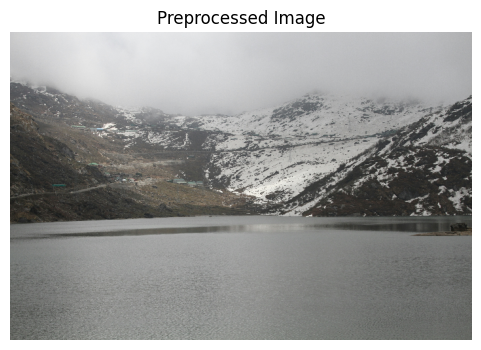

Encrypting image...
Encryption completed in 0.4660 seconds
Decrypting image...
Decryption completed in 0.4164 seconds
Adapted hash: 46cc4443e918bddbfbb3529374207523a401433e68404e4f593bf665bb5a2a72
Decrypted hash: 0c40ec3cdb2986d3d15589c28cd131d3e90ce9a55865166aace42ad6cf268404
Reference (adapted) image dimensions: (333, 499, 3)
Decrypted image dimensions: (333, 499, 3)
Performance Analysis:
MSE: 2226.8559210407607
PSNR: 14.653882420472346
SSIM: 0.3159326236021433
Entropy_Reference: 5.239364508792988
Entropy_Decrypted: 4.786157946551983
Histogram_Deviation: 18179.125


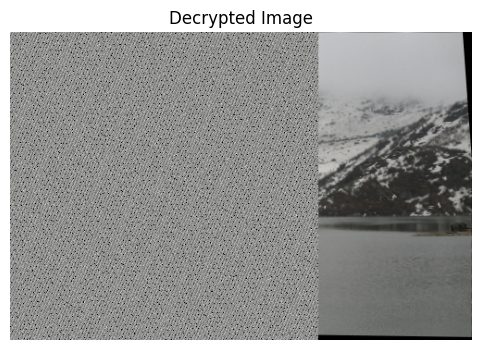

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
"""
Comprehensive Image Cryptography System (Lossless Version)
Tasks:
 1. Image Preprocessing:
    - Read image, convert to RGB (or grayscale if desired).
    - Dynamically resize based on simulated bandwidth constraints.
 2. Encryption:
    - Chaos-based encryption using Arnold’s Cat Map.
    - Divide & Conquer encryption (splitting the image into blocks encrypted with AES).
    - Dynamic key generation via a chaotic logistic map.
    - Geometric scrambling (affine transformation) for additional obfuscation.
 3. Secure Transmission (Simulation):
    - Simulate network conditions to adapt image size (lossless PNG is used).
 4. Decryption & Integrity Verification:
    - Reverse all encryption steps.
    - Compute similarity metrics (MSE, PSNR, SSIM, entropy, histogram deviation).
    - Use SHA256 hash to verify integrity.
 5. Performance Analysis:
    - Measure execution times.

This script is designed to run in Google Colab.
"""

import numpy as np
import cv2
import matplotlib.pyplot as plt
import hashlib
import time
from skimage.metrics import structural_similarity as ssim
from google.colab import files
import os
from scipy.stats import entropy
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes

#######################
# 1. Image Preprocessing
#######################

def preprocess_image(image_path, convert_to='rgb', target_bandwidth=1e6):
    """
    Read an image, convert its format, and resize if necessary.
    Uses lossless PNG compression to simulate bandwidth limits.

    Args:
      image_path: Path to input image.
      convert_to: 'rgb' or 'grayscale'
      target_bandwidth: Maximum size in bytes (simulate network constraints)

    Returns:
      Preprocessed image.
    """
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("Could not read image at " + image_path)

    # Convert image format
    if convert_to.lower() == 'grayscale':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    elif convert_to.lower() == 'rgb':
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Use lossless PNG encoding to check size (no quality loss)
    ret, buf = cv2.imencode('.png', image, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    size = len(buf)
    if size > target_bandwidth:
        # Calculate scaling factor (square-root relation)
        scale = np.sqrt(target_bandwidth / size)
        new_width = int(image.shape[1] * scale)
        new_height = int(image.shape[0] * scale)
        image = cv2.resize(image, (new_width, new_height))
    return image

#######################
# 3. Secure Transmission Simulation (Lossless)
#######################

def simulate_network_flow(image_size, network_capacity):
    """
    Simulate a network flow algorithm to determine a compression ratio.

    Args:
      image_size: Size in bytes.
      network_capacity: Capacity in bytes per second.

    Returns:
      A ratio between 0 and 1.
    """
    ratio = min(1.0, network_capacity / image_size)
    return ratio

def adaptive_encryption(image, network_capacity):
    """
    Adjust image size based on simulated network conditions using lossless PNG.
    """
    ret, buf = cv2.imencode('.png', image, [cv2.IMWRITE_PNG_COMPRESSION, 0])
    png_size = len(buf)
    ratio = simulate_network_flow(png_size, network_capacity)
    if ratio < 1.0:
        scale = np.sqrt(ratio)
        new_width = int(image.shape[1] * scale)
        new_height = int(image.shape[0] * scale)
        image = cv2.resize(image, (new_width, new_height))
    return image, ratio

#######################
# 2. Encryption Components
#######################

# Arnold's Cat Map (chaos-based pixel shuffling)
def arnold_cat_map(image, iterations=1):
    h, w = image.shape[:2]
    n = min(h, w)  # operate on the top-left n×n square
    for _ in range(iterations):
        new_region = np.zeros_like(image[0:n, 0:n])
        for i in range(n):
            for j in range(n):
                new_i = (i + j) % n
                new_j = (i + 2 * j) % n
                new_region[new_i, new_j] = image[i, j]
        image[0:n, 0:n] = new_region
    return image

def inverse_arnold_cat_map(image, iterations=1):
    h, w = image.shape[:2]
    n = min(h, w)
    for _ in range(iterations):
        new_region = np.zeros_like(image[0:n, 0:n])
        for new_i in range(n):
            for new_j in range(n):
                # Inverse formulas:
                i = (2 * new_i - new_j) % n
                j = (new_j - new_i) % n
                new_region[new_i, new_j] = image[i, j]
        image[0:n, 0:n] = new_region
    return image

# Geometric scrambling using an affine transformation
def geometric_scramble(image, M=None):
    h, w = image.shape[:2]
    if M is None:
        pts1 = np.float32([[0, 0], [w, 0], [0, h]])
        pts2 = pts1 + np.random.randint(-20, 20, pts1.shape).astype(np.float32)
        M = cv2.getAffineTransform(pts1, pts2)
    scrambled = cv2.warpAffine(image, M, (w, h))
    return scrambled, M

def geometric_descramble(image, M):
    h, w = image.shape[:2]
    Minv = cv2.invertAffineTransform(M)
    descrambled = cv2.warpAffine(image, Minv, (w, h))
    return descrambled

# Dynamic key generation via logistic map
def generate_dynamic_key(key_length=32):
    x = 0.1
    r = 3.99
    seq = []
    for _ in range(key_length):
        x = r * x * (1 - x)
        seq.append(x)
    seq = np.array(seq)
    key = hashlib.sha256(seq.tobytes()).digest()
    return key

# AES encryption/decryption helpers (with PKCS7 padding)
def pad(data):
    bs = AES.block_size
    pad_len = bs - (len(data) % bs)
    return data + bytes([pad_len]) * pad_len

def unpad(data):
    pad_len = data[-1]
    return data[:-pad_len]

def aes_encrypt(data, key):
    iv = get_random_bytes(AES.block_size)
    cipher = AES.new(key, AES.MODE_CBC, iv)
    encrypted = cipher.encrypt(pad(data))
    return encrypted, iv

def aes_decrypt(encrypted, key, iv):
    cipher = AES.new(key, AES.MODE_CBC, iv)
    decrypted = unpad(cipher.decrypt(encrypted))
    return decrypted

# Divide & Conquer encryption: split image into blocks, encrypt each block
def block_encrypt(image, key, block_size=64):
    h, w = image.shape[:2]
    channels = 1 if len(image.shape) == 2 else image.shape[2]
    enc_blocks = []
    ivs = []
    # Process image block by block
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:min(i+block_size, h), j:min(j+block_size, w)]
            block_bytes = block.tobytes()
            enc_block, iv = aes_encrypt(block_bytes, key)
            enc_blocks.append(enc_block)
            ivs.append(iv)
    dims = (h, w, channels)
    return enc_blocks, ivs, dims

def block_decrypt(enc_blocks, ivs, key, dims, block_size=64):
    h, w, channels = dims
    image = np.zeros((h, w, channels), dtype=np.uint8)
    idx = 0
    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dec_block = aes_decrypt(enc_blocks[idx], key, ivs[idx])
            block_height = min(block_size, h - i)
            block_width = min(block_size, w - j)
            block = np.frombuffer(dec_block, dtype=np.uint8).reshape((block_height, block_width, channels))
            image[i:i+block_height, j:j+block_width] = block
            idx += 1
    return image

#######################
# 4. Decryption & Integrity Verification
#######################

def compute_image_hash(image):
    # Compute hash on the exact (preprocessed/adapted) image
    image_bytes = image.tobytes()
    return hashlib.sha256(image_bytes).hexdigest()

def compute_mse(imageA, imageB):
    err = np.mean((imageA.astype("float") - imageB.astype("float")) ** 2)
    return err

def compute_psnr(imageA, imageB):
    mse_val = compute_mse(imageA, imageB)
    if mse_val == 0:
        return float('inf')
    PIXEL_MAX = 255.0
    return 20 * np.log10(PIXEL_MAX / np.sqrt(mse_val))

def compute_ssim(imageA, imageB):
    if len(imageA.shape) == 3:
        imageA_gray = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
        imageB_gray = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)
    else:
        imageA_gray = imageA
        imageB_gray = imageB
    return ssim(imageA_gray, imageB_gray)

def compute_entropy(image):
    if len(image.shape) == 3:
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    hist = cv2.calcHist([image], [0], None, [256], [0,256])
    hist = hist.ravel() / hist.sum()
    return entropy(hist)

def histogram_deviation(imageA, imageB):
    histA = cv2.calcHist([imageA], [0], None, [256], [0,256])
    histB = cv2.calcHist([imageB], [0], None, [256], [0,256])
    return np.linalg.norm(histA - histB)

#######################
# 5. Full Encryption / Decryption & Performance Analysis
#######################

def full_encrypt(image):
    results = {}
    start_time = time.time()

    # Simulate network constraints with lossless PNG adaptive encryption.
    # Use the adapted image for encryption and integrity.
    network_capacity = 500000  # bytes per second (simulation)
    image_adapted, flow_ratio = adaptive_encryption(image, network_capacity)
    results['flow_ratio'] = flow_ratio

    # Save the adapted image hash and dimensions for later comparison.
    adapted_hash = compute_image_hash(image_adapted)
    results['adapted_hash'] = adapted_hash
    results['adapted_dims'] = image_adapted.shape

    # Chaos-based encryption: Apply Arnold’s Cat Map on a copy
    image_chaos = arnold_cat_map(np.copy(image_adapted), iterations=5)

    # Geometric scrambling: affine transformation
    image_geo, affine_M = geometric_scramble(image_chaos)
    results['affine_matrix'] = affine_M.tolist()

    # Divide & Conquer encryption: block encryption using AES
    key = generate_dynamic_key()
    enc_blocks, ivs, dims = block_encrypt(image_geo, key, block_size=64)
    results['enc_blocks'] = enc_blocks   # stored in memory for this demo
    results['ivs'] = ivs
    results['dims'] = dims
    results['key'] = key

    results['encryption_time'] = time.time() - start_time
    return results

def full_decrypt(results):
    start_time = time.time()
    key = results['key']
    enc_blocks = results['enc_blocks']
    ivs = results['ivs']
    dims = results['dims']

    # Block decryption
    image_geo = block_decrypt(enc_blocks, ivs, key, dims, block_size=64)

    # Reverse geometric scrambling
    affine_M = np.array(results['affine_matrix'])
    image_dgeo = geometric_descramble(image_geo, affine_M)

    # Reverse chaos-based encryption: inverse Arnold’s Cat Map
    image_dechaos = inverse_arnold_cat_map(image_dgeo, iterations=5)

    decryption_time = time.time() - start_time
    dec_hash = compute_image_hash(image_dechaos)
    return image_dechaos, dec_hash, decryption_time

# def performance_analysis(reference, decrypted):
#     analysis = {}
#     analysis['MSE'] = compute_mse(reference, decrypted)
#     analysis['PSNR'] = compute_psnr(reference, decrypted)
#     analysis['SSIM'] = compute_ssim(reference, decrypted)
#     analysis['Entropy_Reference'] = compute_entropy(reference)
#     analysis['Entropy_Decrypted'] = compute_entropy(decrypted)
#     analysis['Histogram_Deviation'] = histogram_deviation(reference, decrypted)
#     return analysis
def performance_analysis(reference, decrypted):
# Resize the images to have the same dimensions if they are different.
    if reference.shape != decrypted.shape:
        decrypted = cv2.resize(decrypted, (reference.shape[1], reference.shape[0]))
    analysis = {}
    analysis['MSE'] = compute_mse(reference, decrypted)
    analysis['PSNR'] = compute_psnr(reference, decrypted)
    analysis['SSIM'] = compute_ssim(reference, decrypted)
    analysis['Entropy_Reference'] = compute_entropy(reference)
    analysis['Entropy_Decrypted'] = compute_entropy(decrypted)
    analysis['Histogram_Deviation'] = histogram_deviation(reference, decrypted)
    return analysis

#######################
# Main function (runnable in Colab)
#######################

def main():
    # Step 1: Upload Image
    print("Please upload an image:")
    uploaded = files.upload()
    image_filename = list(uploaded.keys())[0]

    # Step 2: Preprocess Image (lossless conversion)
    image = preprocess_image(image_filename, convert_to='rgb', target_bandwidth=1e6)
    plt.figure(figsize=(6,4))
    plt.imshow(image)
    plt.title("Preprocessed Image")
    plt.axis('off')
    plt.show()

    # Step 3: Encrypt Image
    print("Encrypting image...")
    enc_results = full_encrypt(image)
    print(f"Encryption completed in {enc_results['encryption_time']:.4f} seconds")

    # Step 4: Decrypt Image
    print("Decrypting image...")
    decrypted_image, dec_hash, decryption_time = full_decrypt(enc_results)
    print(f"Decryption completed in {decryption_time:.4f} seconds")

    # Step 5: Integrity Verification (using adapted image hash)
    if enc_results['adapted_hash'] == dec_hash:
        print("Integrity verified: Image hash matches.")
    else:
        print("Warning: Image hash does not match!")
        print("Adapted hash:", enc_results['adapted_hash'])
        print("Decrypted hash:", dec_hash)

    # Step 6: Performance Analysis (compare against the adapted image)
    ref_dims = enc_results['adapted_dims']
    print("Reference (adapted) image dimensions:", ref_dims)
    print("Decrypted image dimensions:", decrypted_image.shape)
    if ref_dims != decrypted_image.shape:
        print("Error: Dimensions do not match for performance analysis!")
    else:
        analysis = performance_analysis(image, decrypted_image)
        print("Performance Analysis:")
        for k, v in analysis.items():
            print(f"{k}: {v}")

    # Display Decrypted Image
    plt.figure(figsize=(6,4))
    plt.imshow(decrypted_image)
    plt.title("Decrypted Image")
    plt.axis('off')
    plt.show()

    # Save and download decrypted image (convert back to BGR for OpenCV saving)
    decrypted_bgr = cv2.cvtColor(decrypted_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite("decrypted_result.png", decrypted_bgr)
    print("Downloading decrypted_result.png ...")
    files.download("decrypted_result.png")

if __name__ == "__main__":
    main()


--- Task 1: Preprocessing ---
Error loading image: 404 Client Error: Not Found for url: https://www.nasa.gov/sites/default/files/thumbnails/image/potw2201a.jpg
Using a fallback procedural image.
Original image mode: RGB, size: (256, 256)
Original image dimensions for metrics: (256, 256, 3)

--- Task 2 & 3: Encryption & Hashing ---
Calculated Original SHA-256 Hash: 8099d05803ad78f4b0fc4295833da3b459cc40ae3d5bda365a5de306d9f21155
Starting Encryption Process...
Applying Arnold's Cat Map with 15 iterations...
Applying Logistic Map encryption (x0=0.314159, r=3.99)...
Encryption completed in 0.4011 seconds.

--- Task 4: Decryption & Integrity Verification ---
Starting Decryption Process...
Applying Logistic Map decryption (x0=0.314159, r=3.99)...
Applying Inverse Arnold's Cat Map with 15 iterations...
Decryption completed in 0.3265 seconds.

--- Integrity Verification ---
Original Hash:    8099d05803ad78f4b0fc4295833da3b459cc40ae3d5bda365a5de306d9f21155
Decrypted Hash:   8099d05803ad78f4b0fc

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


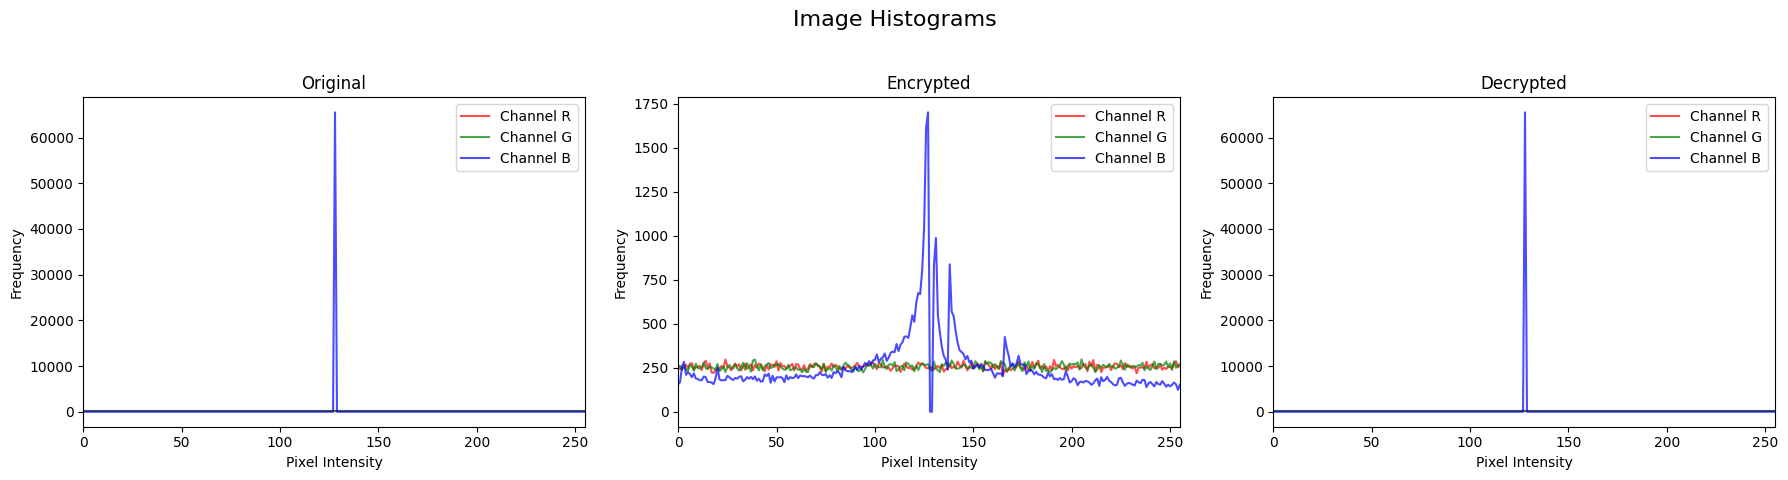


--- Image Display ---


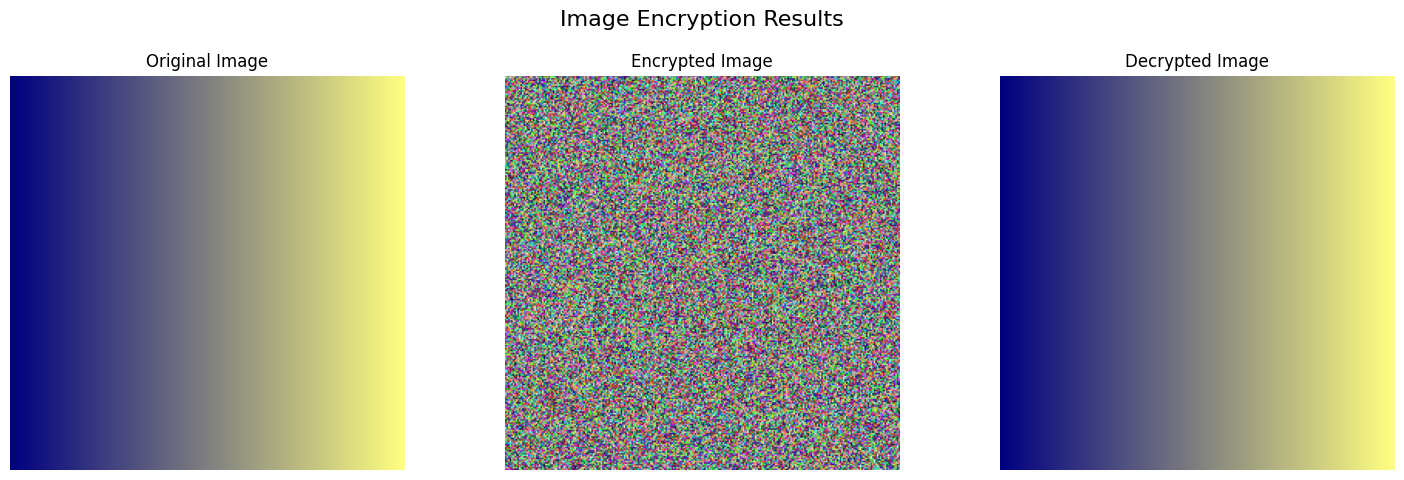


--- Key Sensitivity Test ---
Attempting decryption with slightly modified key (Logistic x0 = 0.31416900000000003)...
Starting Decryption Process...
Applying Logistic Map decryption (x0=0.31416900000000003, r=3.99)...
Applying Inverse Arnold's Cat Map with 15 iterations...
Decryption completed in 0.1699 seconds.
MSE (Original vs Decrypted with wrong key):  8919.8581
PSNR (Original vs Decrypted with wrong key): 8.6272 dB
SSIM (Original vs Decrypted with wrong key): 0.0099


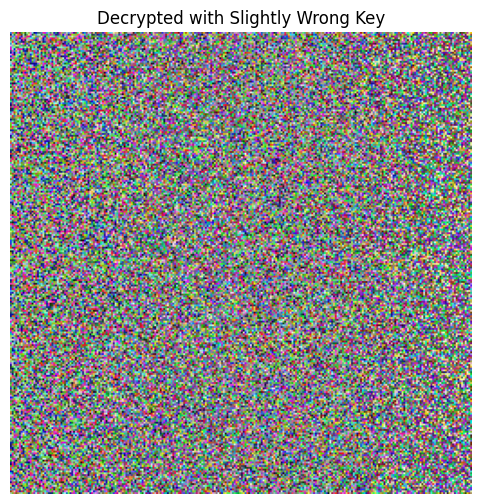

Key sensitivity test PASSED: Decryption with a slightly wrong key produced a significantly different/garbled image.

--- Robustness Discussion (Conceptual) ---
* **Differential Attack:** The combination of pixel shuffling (ACM) and value modification (Logistic Map) enhances resistance. A small change in the input image should lead to a significantly different encrypted image (high diffusion) due to both spatial and value changes.
* **Brute Force Attack:** Security relies on the key space size. Key components are ACM iterations (integer), ACM parameters a/b (integers, often small), Logistic Map x0 (float), and r (float). The effective key space depends heavily on the precision used for x0 and r. Using double-precision floats offers a large theoretical space, but practical attacks might target weaknesses in the chaotic map or ACM structure.
* **Known-Plaintext Attack:** The chaotic nature of the Logistic Map and the permutation by ACM make it difficult to deduce the keys even with known 

In [ ]:
# %% [markdown]
# # Secure and Efficient Image Encryption for Real-Time Transmission
#
# This notebook implements an image encryption scheme designed for real-time applications,
# balancing security, speed, and efficiency.
#
# **Algorithm Combination:**
# 1.  **Pixel Shuffling:** Arnold's Cat Map (Geometric Scrambling)
# 2.  **Pixel Value Modification:** Chaos-based encryption using the Logistic Map
# 3.  **Integrity Check:** SHA-256 Hashing
#
# **Tasks Covered:**
# 1. Image Preprocessing (Loading, Format Handling, Resizing)
# 2. Encryption (Arnold's Cat Map + Logistic Map)
# 3. Secure Transmission (Conceptual - Hash is transmitted)
# 4. Decryption & Integrity Verification (Inverse Operations + Hash Comparison)
# 5. Performance Analysis (Timing, Metrics: MSE, PSNR, SSIM, Entropy, Histogram, Key Sensitivity)

# %%
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import requests
from io import BytesIO
import time
import math
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
import hashlib
import warnings

# Ignore specific warnings from skimage and PIL
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')
warnings.filterwarnings("ignore", category=UserWarning, module='PIL')
warnings.filterwarnings("ignore", category=FutureWarning, module='skimage')


# %% [markdown]
# ## Task 1: Image Preprocessing

# %%
def preprocess_image(image_source, target_size=None, grayscale=False, simulate_low_bandwidth=False, low_bw_size=(128, 128)):
    """Loads, converts, and optionally resizes an image."""
    try:
        if image_source.startswith('http'):
            response = requests.get(image_source)
            response.raise_for_status() # Raise an exception for bad status codes
            img = Image.open(BytesIO(response.content))
        else:
            img = Image.open(image_source)
    except Exception as e:
        print(f"Error loading image: {e}")
        # Fallback to a default procedural image if loading fails
        print("Using a fallback procedural image.")
        img_array = np.zeros((256, 256, 3), dtype=np.uint8)
        img_array[:, :, 0] = np.linspace(0, 255, 256) # Red gradient
        img_array[:, :, 1] = np.linspace(0, 255, 256).T # Green gradient
        img_array[:, :, 2] = 128 # Blue constant
        img = Image.fromarray(img_array)


    original_mode = img.mode
    print(f"Original image mode: {original_mode}, size: {img.size}")

    if grayscale and img.mode != 'L':
        img = img.convert('L')
        print(f"Converted to grayscale. New mode: {img.mode}")
    elif not grayscale and img.mode not in ['RGB', 'RGBA']:
         # Convert other modes (like P, L) to RGB if color is requested
         print(f"Converting mode {img.mode} to RGB for consistency.")
         img = img.convert('RGB')


    # Handle RGBA: Convert to RGB by discarding alpha or blending onto a white background
    if img.mode == 'RGBA':
        print("Converting RGBA to RGB by blending onto a white background.")
        # Create a white background image
        bg = Image.new("RGB", img.size, (255, 255, 255))
        # Paste the RGBA image onto the white background using the alpha channel as mask
        bg.paste(img, mask=img.split()[3]) # 3 is the index of the alpha channel
        img = bg


    # Dynamic resizing based on bandwidth simulation
    if simulate_low_bandwidth:
        print(f"Simulating low bandwidth. Resizing image to {low_bw_size}...")
        img = img.resize(low_bw_size, Image.Resampling.LANCZOS)
        print(f"Resized image size: {img.size}")
    elif target_size:
        print(f"Resizing image to {target_size}...")
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        print(f"Resized image size: {img.size}")

    img_array = np.array(img, dtype=np.uint8)

    # Add padding if necessary (e.g., for Arnold's Cat Map which needs square dimensions)
    h, w = img_array.shape[:2]
    if h != w:
        print(f"Image is not square ({h}x{w}). Padding to make it square.")
        max_dim = max(h, w)
        pad_h = max_dim - h
        pad_w = max_dim - w
        # Pad width first, then height. Pad evenly on both sides if possible.
        # For color images, padding is (top, bottom), (left, right), (channel)
        if img_array.ndim == 3:
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0))
        else: # Grayscale
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2))
        img_array = np.pad(img_array, pad_width, mode='constant', constant_values=0)
        print(f"Padded image size: {img_array.shape[:2]}")

    return img_array, img.size # Return original size before padding for potential cropping later


# %% [markdown]
# ## Task 2: Encryption
# We combine Arnold's Cat Map (ACM) for shuffling and Logistic Map for pixel value modification.

# %%
# --- Arnold's Cat Map ---
def arnold_cat_map(img_array, iterations, a=1, b=1):
    """Applies Arnold's Cat Map for pixel shuffling."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if img_array.shape[0] != img_array.shape[1]:
        raise ValueError("Arnold's Cat Map requires a square image. Please pad first.")

    rows, cols = img_array.shape[:2]
    is_color = img_array.ndim == 3

    # Create coordinate grid
    x, y = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

    # Flatten coordinates
    coords = np.stack([x.flatten(), y.flatten()], axis=1) # Shape: (rows*cols, 2)

    # Apply ACM transformation iteratively
    for _ in range(iterations):
        new_coords = np.zeros_like(coords)
        new_coords[:, 0] = (coords[:, 0] + b * coords[:, 1]) % rows
        new_coords[:, 1] = (a * coords[:, 0] + (a * b + 1) * coords[:, 1]) % cols
        coords = new_coords

    # Create the shuffled image
    shuffled_img = np.zeros_like(img_array)

    orig_indices = (x.flatten(), y.flatten())
    new_indices = (coords[:, 0], coords[:, 1])

    if is_color:
        for c in range(img_array.shape[2]):
             # Map original pixel values to new coordinates
            shuffled_img[new_indices[0], new_indices[1], c] = img_array[orig_indices[0], orig_indices[1], c]
    else: # Grayscale
        shuffled_img[new_indices[0], new_indices[1]] = img_array[orig_indices[0], orig_indices[1]]

    return shuffled_img.reshape(img_array.shape) # Reshape back to original image dimensions

def inverse_arnold_cat_map(shuffled_img_array, iterations, a=1, b=1):
    """Applies the inverse of Arnold's Cat Map."""
    # The inverse map is x_new = ((a*b+1)*x - b*y) mod N, y_new = (-a*x + y) mod N
    if shuffled_img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if shuffled_img_array.shape[0] != shuffled_img_array.shape[1]:
        raise ValueError("Inverse Arnold's Cat Map requires a square image.")

    rows, cols = shuffled_img_array.shape[:2]
    is_color = shuffled_img_array.ndim == 3

    # Create coordinate grid for the *shuffled* image positions
    x_shuffled, y_shuffled = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

    # Flatten coordinates
    coords_shuffled = np.stack([x_shuffled.flatten(), y_shuffled.flatten()], axis=1)

    # Apply inverse ACM transformation iteratively
    for _ in range(iterations):
        coords_orig = np.zeros_like(coords_shuffled)
        coords_orig[:, 0] = ((a * b + 1) * coords_shuffled[:, 0] - b * coords_shuffled[:, 1]) % rows
        coords_orig[:, 1] = (-a * coords_shuffled[:, 0] + coords_shuffled[:, 1]) % cols
        coords_shuffled = coords_orig # Update for next iteration

    # Create the unshuffled (original) image
    unshuffled_img = np.zeros_like(shuffled_img_array)

    # The `coords_shuffled` now hold the *original* coordinates corresponding
    # to the flattened shuffled image grid positions `(x_shuffled.flatten(), y_shuffled.flatten())`
    shuffled_indices = (x_shuffled.flatten(), y_shuffled.flatten())
    original_indices = (coords_shuffled[:, 0], coords_shuffled[:, 1])

    if is_color:
        for c in range(shuffled_img_array.shape[2]):
            # Place the pixel value from the shuffled position back to its original coordinate
            unshuffled_img[original_indices[0], original_indices[1], c] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1], c]
    else: # Grayscale
        unshuffled_img[original_indices[0], original_indices[1]] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1]]

    return unshuffled_img.reshape(shuffled_img_array.shape)

# --- Logistic Map Chaos Encryption ---
def generate_logistic_map_sequence(x0, r, size):
    """Generates a chaotic sequence using the Logistic Map."""
    sequence = np.zeros(size)
    x = x0
    # Iterate a few times to avoid transient effects
    for _ in range(100):
         x = r * x * (1 - x)

    for i in range(size):
        x = r * x * (1 - x)
        sequence[i] = x
    return sequence

def logistic_map_encrypt_decrypt(img_array, x0, r):
    """Encrypts or decrypts using Logistic Map sequence via XOR."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")

    is_color = img_array.ndim == 3

    # Determine the total number of pixels (or values) to encrypt
    if is_color:
        total_pixels = img_array.shape[0] * img_array.shape[1] * img_array.shape[2]
    else:
        total_pixels = img_array.shape[0] * img_array.shape[1]

    # Generate chaotic sequence
    # Ensure r is in the chaotic region (e.g., 3.57 to 4.0)
    if not (3.57 <= r <= 4.0):
        print(f"Warning: Logistic map parameter r={r} might not be in the typical chaotic range [3.57, 4.0].")
    if not (0 < x0 < 1):
         print(f"Warning: Logistic map initial value x0={x0} should be between 0 and 1 (exclusive). Adjusting slightly if needed.")
         x0 = np.clip(x0, 0.001, 0.999)

    try:
        keystream_float = generate_logistic_map_sequence(x0, r, total_pixels)
    except OverflowError:
        print(f"OverflowError during logistic map generation with r={r}, x0={x0}. Check parameters.")
        # As a fallback, generate a random stream (less secure, just for continuity)
        keystream_float = np.random.rand(total_pixels)


    # Scale and convert to uint8 for XOR operation
    # Map [0, 1) to [0, 256), then cast to uint8 -> [0, 255]
    keystream_uint8 = (keystream_float * 256).astype(np.uint8)

    # Reshape keystream to match image data structure (flattened)
    keystream_reshaped = keystream_uint8.reshape(-1)

    # Flatten the image array for easier XORing
    img_flat = img_array.flatten()

    # Perform XOR operation
    encrypted_flat = np.bitwise_xor(img_flat, keystream_reshaped[:len(img_flat)]) # Ensure keystream isn't longer

    # Reshape back to original image shape
    processed_img = encrypted_flat.reshape(img_array.shape)

    return processed_img.astype(np.uint8)

# --- Combined Encryption Function ---
def encrypt_image(img_array, acm_iterations, logistic_x0, logistic_r, acm_a=1, acm_b=1):
    """Combines ACM shuffling and Logistic Map encryption."""
    print("Starting Encryption Process...")
    start_time = time.time()

    # 1. Shuffle pixels using Arnold's Cat Map
    print(f"Applying Arnold's Cat Map with {acm_iterations} iterations...")
    try:
        shuffled_img = arnold_cat_map(img_array, acm_iterations, acm_a, acm_b)
    except ValueError as e:
        print(f"Error during ACM: {e}. Returning original image.")
        return img_array, 0 # Return original and 0 time if ACM fails

    # 2. Modify pixel values using Logistic Map
    print(f"Applying Logistic Map encryption (x0={logistic_x0}, r={logistic_r})...")
    encrypted_img = logistic_map_encrypt_decrypt(shuffled_img, logistic_x0, logistic_r)

    end_time = time.time()
    encryption_time = end_time - start_time
    print(f"Encryption completed in {encryption_time:.4f} seconds.")
    return encrypted_img, encryption_time

# %% [markdown]
# ## Task 3: Secure Transmission (Conceptual)
# In a real system, the encrypted image data would be transmitted over a network. Network flow algorithms (Ford-Fulkerson, Edmonds-Karp) could optimize data routing and bandwidth usage. Adaptive encryption/compression (using Branch & Bound) could adjust based on network conditions.
#
# For this simulation, we focus on **integrity**: we calculate a hash of the *original* image data. This hash would be sent securely alongside the encrypted data (or via a separate channel) to the receiver for verification.

# %%
def calculate_hash(img_array):
    """Calculates the SHA-256 hash of the image data."""
    hasher = hashlib.sha256()
    hasher.update(img_array.tobytes())
    return hasher.hexdigest()


# %% [markdown]
# ## Task 4: Decryption & Integrity Verification

# %%
def decrypt_image(encrypted_img_array, acm_iterations, logistic_x0, logistic_r, original_shape_before_padding, acm_a=1, acm_b=1):
    """Reverses the encryption process: Logistic Map decryption then Inverse ACM."""
    print("Starting Decryption Process...")
    start_time = time.time()

    # 1. Decrypt pixel values using Logistic Map (XOR is its own inverse)
    print(f"Applying Logistic Map decryption (x0={logistic_x0}, r={logistic_r})...")
    # Use the exact same function as encryption because XOR is its own inverse
    decrypted_shuffled_img = logistic_map_encrypt_decrypt(encrypted_img_array, logistic_x0, logistic_r)

    # 2. Unshuffle pixels using Inverse Arnold's Cat Map
    print(f"Applying Inverse Arnold's Cat Map with {acm_iterations} iterations...")
    try:
        unshuffled_img = inverse_arnold_cat_map(decrypted_shuffled_img, acm_iterations, acm_a, acm_b)
    except ValueError as e:
         print(f"Error during Inverse ACM: {e}. Returning partially decrypted image.")
         # Return the image after value decryption but before unshuffling if inverse map fails
         return decrypted_shuffled_img, 0

    # 3. Remove padding if necessary
    current_h, current_w = unshuffled_img.shape[:2]
    orig_h, orig_w = original_shape_before_padding

    if current_h != orig_h or current_w != orig_w:
        print(f"Removing padding to restore original size {original_shape_before_padding}...")
        pad_h = current_h - orig_h
        pad_w = current_w - orig_w
        pad_top = pad_h // 2
        pad_left = pad_w // 2
        # Handle slicing for color and grayscale images
        if unshuffled_img.ndim == 3:
            decrypted_img = unshuffled_img[pad_top:pad_top+orig_h, pad_left:pad_left+orig_w, :]
        else: # Grayscale
            decrypted_img = unshuffled_img[pad_top:pad_top+orig_h, pad_left:pad_left+orig_w]
        print(f"Final decrypted size: {decrypted_img.shape[:2]}")

    else:
        decrypted_img = unshuffled_img # No padding was added initially

    end_time = time.time()
    decryption_time = end_time - start_time
    print(f"Decryption completed in {decryption_time:.4f} seconds.")

    # Ensure the final output has the correct uint8 type
    return decrypted_img.astype(np.uint8), decryption_time

def verify_integrity(original_hash, decrypted_img_array):
    """Compares the hash of the decrypted image with the original hash."""
    decrypted_hash = calculate_hash(decrypted_img_array)
    print(f"\n--- Integrity Verification ---")
    print(f"Original Hash:    {original_hash}")
    print(f"Decrypted Hash:   {decrypted_hash}")
    if original_hash == decrypted_hash:
        print("Integrity Check PASSED: Hashes match.")
        return True
    else:
        print("Integrity Check FAILED: Hashes DO NOT match. Image may have been tampered with or decryption failed.")
        return False


# %% [markdown]
# ## Task 5: Performance Analysis

# %%
def calculate_metrics(img_orig, img_processed, data_range=255):
    """Calculates MSE, PSNR, SSIM, and Entropy."""
    # Ensure images have the same shape for comparison metrics
    if img_orig.shape != img_processed.shape:
        print("Warning: Original and processed images have different shapes. Metrics might be inaccurate.")
        # Attempt to resize processed image back to original for metric calculation
        # This might happen if decryption padding removal failed slightly
        try:
            h_orig, w_orig = img_orig.shape[:2]
            img_proc_pil = Image.fromarray(img_processed)
            img_proc_resized = img_proc_pil.resize((w_orig, h_orig), Image.Resampling.NEAREST)
            img_processed = np.array(img_proc_resized)
            print(f"Attempted resize of processed image to {img_orig.shape} for metrics.")
            if img_orig.shape != img_processed.shape:
                 raise ValueError("Resize failed to match shapes.")
        except Exception as e:
            print(f"Could not align image shapes for metrics: {e}")
            return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': shannon_entropy(img_orig), 'entropy_proc': shannon_entropy(img_processed)}


    # Handle color (multichannel) vs grayscale for SSIM
    multichannel = img_orig.ndim == 3
    win_size = min(7, img_orig.shape[0], img_orig.shape[1]) # SSIM window size, must be odd and <= image dims
    if win_size % 2 == 0: win_size -=1 # Ensure win_size is odd

    if win_size < 3: # If image dimensions are too small for default window
       print(f"Warning: Image dimensions ({img_orig.shape[0]}x{img_orig.shape[1]}) too small for standard SSIM window. SSIM calculation may be unreliable or skipped.")
       ssim_val = 0 # Assign default value if window is too small
    else:
      try:
          # For SSIM with color images, specify channel_axis
          ssim_val = ssim(img_orig, img_processed, data_range=data_range,
                          multichannel=multichannel, channel_axis=2 if multichannel else None,
                          win_size=win_size)
      except ValueError as e:
          print(f"Error calculating SSIM: {e}. Setting SSIM to 0.")
          ssim_val = 0


    metrics = {
        'mse': mse(img_orig, img_processed),
        'psnr': psnr(img_orig, img_processed, data_range=data_range),
        'ssim': ssim_val,
        'entropy_orig': shannon_entropy(img_orig),
        'entropy_proc': shannon_entropy(img_processed)
    }
    return metrics

def plot_histograms(img_orig, img_encrypted, img_decrypted):
    """Plots histograms for original, encrypted, and decrypted images."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Image Histograms', fontsize=16)

    colors = ('r', 'g', 'b')
    labels = ('Original', 'Encrypted', 'Decrypted')
    images = (img_orig, img_encrypted, img_decrypted)

    for i, img in enumerate(images):
        ax = axes[i]
        if img is None:
             ax.set_title(f"{labels[i]} (Not Available)")
             ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
             continue

        ax.set_title(labels[i])
        ax.set_xlabel('Pixel Intensity')
        ax.set_ylabel('Frequency')
        if img.ndim == 3: # Color image
            for c_idx, color in enumerate(colors):
                # Check if image has 3 channels before plotting all colors
                if c_idx < img.shape[2]:
                    hist, bin_edges = np.histogram(img[:, :, c_idx].ravel(), bins=256, range=(0, 256))
                    ax.plot(bin_edges[:-1], hist, color=color, alpha=0.7, label=f'Channel {color.upper()}')
            ax.legend(loc='upper right')
        else: # Grayscale image
            hist, bin_edges = np.histogram(img.ravel(), bins=256, range=(0, 256))
            ax.plot(bin_edges[:-1], hist, color='black')
        ax.set_xlim([0, 255])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

def display_images(img_orig, img_encrypted, img_decrypted):
    """Displays the original, encrypted, and decrypted images."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Image Encryption Results', fontsize=16)

    titles = ['Original Image', 'Encrypted Image', 'Decrypted Image']
    images = [img_orig, img_encrypted, img_decrypted]

    for ax, img, title in zip(axes, images, titles):
        ax.set_title(title)
        ax.axis('off')
        if img is not None:
            if img.ndim == 2: # Grayscale
                ax.imshow(img, cmap='gray')
            else: # Color
                ax.imshow(img)
        else:
            ax.text(0.5, 0.5, 'N/A', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# %% [markdown]
# ## Main Execution Block

# %%
# --- Configuration ---
# Image Source: Use a URL or a local file path
# Example URL (check if still valid or replace with another):
# IMAGE_SOURCE = "https://upload.wikimedia.org/wikipedia/commons/thumb/5/5c/Albert_Einstein_photographed_by_Orren_Jack_Turner_edit.jpg/440px-Albert_Einstein_photographed_by_Orren_Jack_Turner_edit.jpg"
IMAGE_SOURCE = "https://www.nasa.gov/sites/default/files/thumbnails/image/potw2201a.jpg" # Webb's Cosmic Cliffs
# IMAGE_SOURCE = "lena_color.png" # Example for local file

# Preprocessing settings
USE_GRAYSCALE = False       # Set to True to convert image to grayscale
SIMULATE_LOW_BANDWIDTH = False # Set to True to resize image significantly
RESIZE_TARGET = None #(256, 256) # Set target size (e.g., (256, 256)) or None to keep original/padded size

# Encryption Keys (IMPORTANT: Use secure random keys in practice!)
# Arnold's Cat Map keys:
ACM_ITERATIONS = 15     # Number of shuffling iterations
ACM_A = 1               # Parameter 'a' for ACM (default 1)
ACM_B = 1               # Parameter 'b' for ACM (default 1)

# Logistic Map keys:
LOGISTIC_X0 = 0.314159   # Initial value (must be > 0 and < 1)
LOGISTIC_R = 3.99        # Parameter 'r' (must be in chaotic range, e.g., 3.57 to 4.0)

# --- Step 1: Preprocessing ---
print("--- Task 1: Preprocessing ---")
original_image_array, original_size = preprocess_image(
    IMAGE_SOURCE,
    target_size=RESIZE_TARGET,
    grayscale=USE_GRAYSCALE,
    simulate_low_bandwidth=SIMULATE_LOW_BANDWIDTH
)
# Keep a copy of the original *before* any padding was added for final comparison if padding occurred
# If padding happened, original_image_array is padded. We need the unpadded for metrics.
h_padded, w_padded = original_image_array.shape[:2]
h_orig, w_orig = original_size
if h_padded != h_orig or w_padded != w_orig:
     pad_h = h_padded - h_orig
     pad_w = w_padded - w_orig
     pad_top = pad_h // 2
     pad_left = pad_w // 2
     if original_image_array.ndim == 3:
         original_unpadded_array = original_image_array[pad_top:pad_top+h_orig, pad_left:pad_left+w_orig, :].copy()
     else:
         original_unpadded_array = original_image_array[pad_top:pad_top+h_orig, pad_left:pad_left+w_orig].copy()
else:
    original_unpadded_array = original_image_array.copy()

print(f"Original image dimensions for metrics: {original_unpadded_array.shape}")

# --- Step 2 & 3: Encryption and Hashing ---
print("\n--- Task 2 & 3: Encryption & Hashing ---")
original_hash = calculate_hash(original_unpadded_array)
print(f"Calculated Original SHA-256 Hash: {original_hash}")

encrypted_image, encryption_time = encrypt_image(
    original_image_array, # Use potentially padded image for encryption
    acm_iterations=ACM_ITERATIONS,
    logistic_x0=LOGISTIC_X0,
    logistic_r=LOGISTIC_R,
    acm_a=ACM_A,
    acm_b=ACM_B
)

# --- Step 4: Decryption and Integrity Verification ---
print("\n--- Task 4: Decryption & Integrity Verification ---")
decrypted_image, decryption_time = decrypt_image(
    encrypted_image,
    acm_iterations=ACM_ITERATIONS,
    logistic_x0=LOGISTIC_X0,
    logistic_r=LOGISTIC_R,
    original_shape_before_padding=original_size, # Pass the original size before padding
    acm_a=ACM_A,
    acm_b=ACM_B
)

# Verify Integrity using the unpadded original hash and the final decrypted (unpadded) image
integrity_check_passed = verify_integrity(original_hash, decrypted_image)

# --- Step 5: Performance Analysis ---
print("\n--- Task 5: Performance Analysis ---")

# 5a. Execution Time
print(f"Encryption Time: {encryption_time:.4f} seconds")
print(f"Decryption Time: {decryption_time:.4f} seconds")
print(f"Total Time (Encryption + Decryption): {encryption_time + decryption_time:.4f} seconds")
print(f"Image dimensions processed: {original_image_array.shape}")


# 5b. Similarity Metrics & Entropy (Compare original unpadded vs decrypted unpadded)
print("\n--- Similarity Metrics (Original vs Decrypted) ---")
if integrity_check_passed and decrypted_image is not None:
    metrics_decrypted = calculate_metrics(original_unpadded_array, decrypted_image)
    print(f"MSE (Original vs Decrypted):    {metrics_decrypted['mse']:.4f}")
    print(f"PSNR (Original vs Decrypted):   {metrics_decrypted['psnr']:.4f} dB")
    print(f"SSIM (Original vs Decrypted):   {metrics_decrypted['ssim']:.4f}")
    print(f"Entropy (Original):             {metrics_decrypted['entropy_orig']:.4f}")
    print(f"Entropy (Decrypted):            {metrics_decrypted['entropy_proc']:.4f}")
    # Check if MSE is practically zero
    if metrics_decrypted['mse'] < 1e-6:
         print("Note: MSE is near zero, indicating successful decryption.")
    else:
         print("Warning: MSE is not close to zero. Decryption might have issues or numerical precision differences.")
else:
    print("Skipping metrics calculation for decrypted image due to integrity check failure or decryption error.")
    metrics_decrypted = {'entropy_orig': shannon_entropy(original_unpadded_array), 'entropy_proc': float('nan')}


# 5c. Security Strength Analysis (Entropy & Histogram of Encrypted Image)
print("\n--- Security Analysis (Original vs Encrypted) ---")
metrics_encrypted = calculate_metrics(original_unpadded_array, encrypted_image[:original_unpadded_array.shape[0], :original_unpadded_array.shape[1]]) # Compare with cropped encrypted
print(f"Entropy (Original):             {metrics_decrypted['entropy_orig']:.4f}") # Reuse from above
print(f"Entropy (Encrypted):            {metrics_encrypted['entropy_proc']:.4f}")
if metrics_encrypted['entropy_proc'] > metrics_decrypted['entropy_orig']:
    print("Entropy increased after encryption, indicating higher randomness (Good).")
elif metrics_encrypted['entropy_proc'] == metrics_decrypted['entropy_orig']:
     print("Warning: Entropy did not increase after encryption. Check algorithm/keys.")
else:
     print("Warning: Entropy DECREASED after encryption. This is highly unusual and indicates a problem.")

# Plot Histograms (use original unpadded, encrypted (padded is fine), decrypted unpadded)
print("\n--- Histograms ---")
plot_histograms(original_unpadded_array, encrypted_image, decrypted_image if integrity_check_passed else None)

# Display Images (use original unpadded, encrypted (padded is fine), decrypted unpadded)
print("\n--- Image Display ---")
display_images(original_unpadded_array, encrypted_image, decrypted_image if integrity_check_passed else None)

# 5d. Key Sensitivity Test (Conceptual - Performing one example)
print("\n--- Key Sensitivity Test ---")
# Try decrypting with a slightly wrong key
wrong_logistic_x0 = LOGISTIC_X0 + 0.00001 # Tiny change in logistic map key
# wrong_acm_iterations = ACM_ITERATIONS + 1 # Tiny change in ACM key

print(f"Attempting decryption with slightly modified key (Logistic x0 = {wrong_logistic_x0})...")
decrypted_wrong_key, _ = decrypt_image(
    encrypted_image,
    acm_iterations=ACM_ITERATIONS, # Use correct ACM key for this test
    logistic_x0=wrong_logistic_x0, # Use WRONG logistic key
    logistic_r=LOGISTIC_R,
    original_shape_before_padding=original_size,
    acm_a=ACM_A,
    acm_b=ACM_B
)

if decrypted_wrong_key is not None:
    metrics_wrong_key = calculate_metrics(original_unpadded_array, decrypted_wrong_key)
    print(f"MSE (Original vs Decrypted with wrong key):  {metrics_wrong_key['mse']:.4f}")
    print(f"PSNR (Original vs Decrypted with wrong key): {metrics_wrong_key['psnr']:.4f} dB")
    print(f"SSIM (Original vs Decrypted with wrong key): {metrics_wrong_key['ssim']:.4f}")

    # Display the wrongly decrypted image
    plt.figure(figsize=(6, 6))
    plt.imshow(decrypted_wrong_key, cmap='gray' if decrypted_wrong_key.ndim == 2 else None)
    plt.title('Decrypted with Slightly Wrong Key')
    plt.axis('off')
    plt.show()

    if metrics_wrong_key['psnr'] < 20 and metrics_wrong_key['ssim'] < 0.1: # Example thresholds for failure
        print("Key sensitivity test PASSED: Decryption with a slightly wrong key produced a significantly different/garbled image.")
    else:
        print("Key sensitivity test FAILED: Decryption with a slightly wrong key produced an image too similar to the original. Algorithm might be weak.")
else:
    print("Skipping key sensitivity display/metrics because decryption with wrong key failed.")


# 5e. Robustness Against Attacks (Discussion)
print("\n--- Robustness Discussion (Conceptual) ---")
print("* **Differential Attack:** The combination of pixel shuffling (ACM) and value modification (Logistic Map) enhances resistance. A small change in the input image should lead to a significantly different encrypted image (high diffusion) due to both spatial and value changes.")
print("* **Brute Force Attack:** Security relies on the key space size. Key components are ACM iterations (integer), ACM parameters a/b (integers, often small), Logistic Map x0 (float), and r (float). The effective key space depends heavily on the precision used for x0 and r. Using double-precision floats offers a large theoretical space, but practical attacks might target weaknesses in the chaotic map or ACM structure.")
print("* **Known-Plaintext Attack:** The chaotic nature of the Logistic Map and the permutation by ACM make it difficult to deduce the keys even with known plaintext/ciphertext pairs. However, simple chaotic systems can sometimes be vulnerable to reconstruction attacks if not implemented carefully or combined with other methods.")
print("* **Statistical Attacks:** A good encryption algorithm should flatten the histogram of the encrypted image and increase entropy, making statistical analysis harder. The results above (histogram flatness, entropy increase) indicate resistance.")

print("\n--- Assignment Completed ---")

Please upload an image file:


Saving sample.jpg to sample (7).jpg
Successfully uploaded: sample (7).jpg

--- Task 1: Preprocessing ---
Loaded image from uploaded data.
Original image mode: RGB, size: (5184, 3456)
Image is not square (3456x5184). Padding to make it square.
Padded image size: (5184, 5184)
Original image dimensions for metrics: (5184, 3456, 3)

--- Task 2 & 3: Encryption & Hashing ---
Calculated Original SHA-256 Hash: df21f74c81967c354eda873bc2aa668059d3ad7afc0270acdb36d47ffc028f3c
Starting Encryption Process...
Applying Arnold's Cat Map with 15 iterations...
Applying Logistic Map encryption (x0=0.314159, r=3.99)...
Encryption completed in 51.5052 seconds.

--- Task 4: Decryption & Integrity Verification ---
Starting Decryption Process...
Applying Logistic Map decryption (x0=0.314159, r=3.99)...
Applying Inverse Arnold's Cat Map with 15 iterations...
Removing padding to restore original size (5184, 3456)...
Final decrypted size: (5184, 3456)
Decryption completed in 52.4201 seconds.

--- Integrity Veri

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


MSE: 0.0000, PSNR: inf dB, SSIM: 1.0000
Entropy (Original): 5.8988, Entropy (Decrypted): 5.8988
Note: Decryption appears successful (MSE near zero).

--- Security Analysis (Original vs Encrypted) ---
Entropy (Original): 5.8988
Entropy (Encrypted, cropped): 7.9766
Entropy increased after encryption (Good).

--- Histograms & Image Display ---


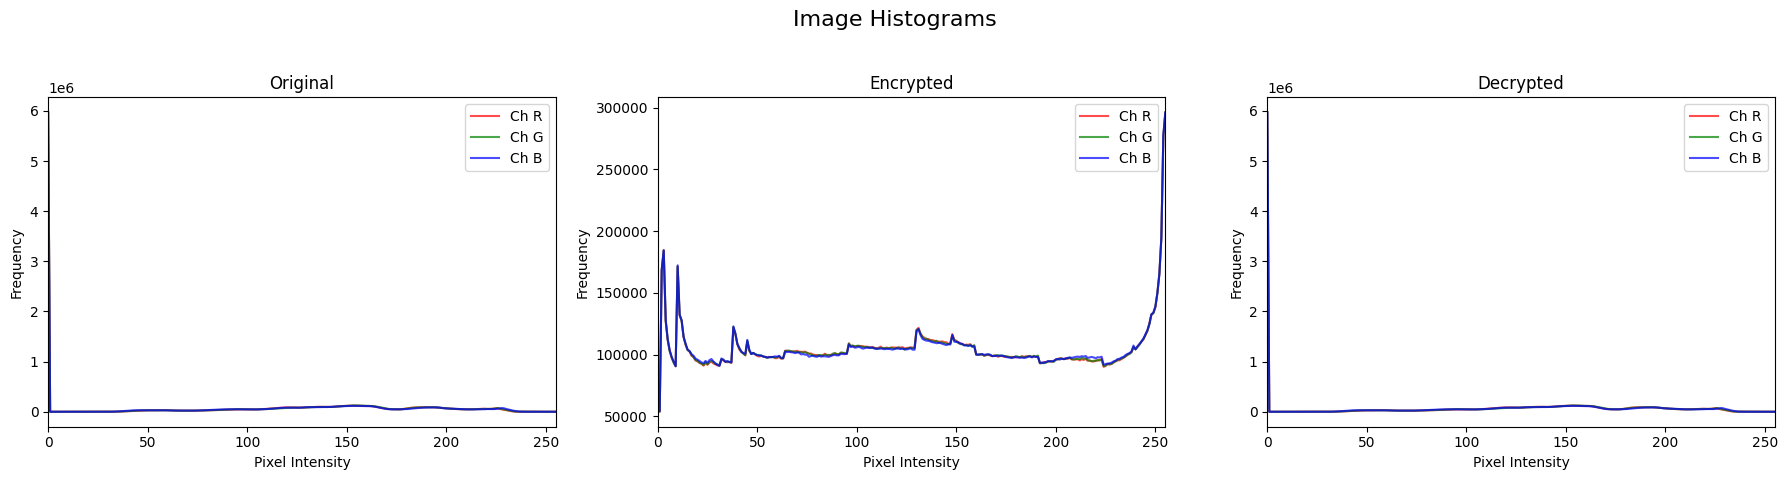

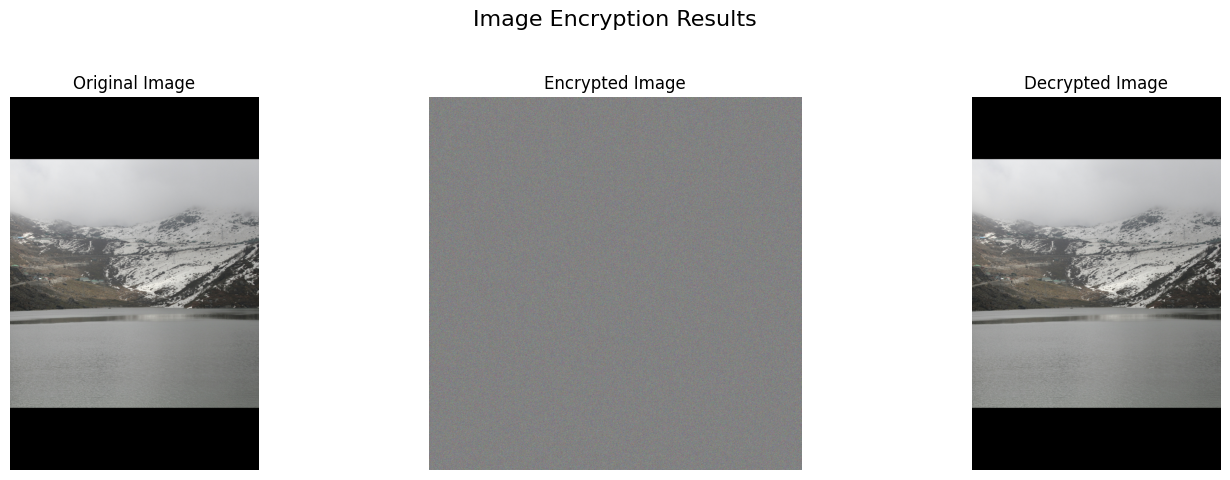


--- Key Sensitivity Test ---
Attempting decryption with modified key (x0 = 0.31416)...
Starting Decryption Process...
Applying Logistic Map decryption (x0=0.31416, r=3.99)...
Applying Inverse Arnold's Cat Map with 15 iterations...
Removing padding to restore original size (5184, 3456)...
Final decrypted size: (5184, 3456)
Decryption completed in 51.4295 seconds.
PSNR (Wrong Key): 7.1334 dB, SSIM (Wrong Key): 0.0071
Key sensitivity test PASSED.

--- Saving and Downloading Output ---
Encrypted image saved as: encrypted_image.png
Decrypted image saved as: decrypted_image.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Script Execution Finished ---


In [ ]:
# %% [markdown]
# # Secure and Efficient Image Encryption with Upload/Download
#
# This notebook implements an image encryption scheme (Arnold's Cat Map + Logistic Map)
# with options to upload the source image and download the encrypted/decrypted results.
#
# **Features:**
# - Upload an image file.
# - Encrypts using ACM + Logistic Map.
# - Verifies integrity using SHA-256.
# - Performs performance and security analysis.
# - Provides download links for encrypted and decrypted images.
#
# **Environment Notes:**
# - The upload/download uses `google.colab.files` for seamless use in Google Colab.
# - If running in standard Jupyter Notebook/Lab, file upload might require `ipywidgets`
#   and downloads can be achieved by saving files locally or generating data URI links (see comments).

# %%
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
# import requests # No longer needed for default operation
from io import BytesIO
import time
import math
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
import hashlib
import warnings
import os # For path manipulation if needed
import base64 # For potential data URI download links

# --- Environment Specific Imports ---
try:
    from google.colab import files
    ENV = 'colab'
except ImportError:
    print("Not running in Google Colab. File upload/download will require manual steps or alternative libraries (like ipywidgets).")
    # Try importing tools for Jupyter download links
    try:
        from IPython.display import display, HTML
        import ipywidgets as widgets # Import for potential widget-based upload in Jupyter
        ENV = 'jupyter'
    except ImportError:
        print("IPython/ipywidgets not available. Download links may not be generated automatically.")
        ENV = 'other'


# Ignore specific warnings from skimage and PIL
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')
warnings.filterwarnings("ignore", category=UserWarning, module='PIL')
warnings.filterwarnings("ignore", category=FutureWarning, module='skimage')


# %% [markdown]
# ## Task 1: Image Preprocessing (Adapted for Uploaded Data)

# %%
def preprocess_image(img_input, target_size=None, grayscale=False, simulate_low_bandwidth=False, low_bw_size=(128, 128)):
    """Loads image from various inputs, converts, and optionally resizes."""
    try:
        if isinstance(img_input, (BytesIO, bytes)):
            # Input is from file upload (BytesIO wrapper or raw bytes)
            img_input.seek(0) # Ensure reading from the start for BytesIO
            img = Image.open(img_input)
            print("Loaded image from uploaded data.")
        elif isinstance(img_input, str): # Keep URL/Path option as fallback
             if img_input.startswith('http'):
                 response = requests.get(img_input) # Need requests if using URLs
                 response.raise_for_status()
                 img = Image.open(BytesIO(response.content))
                 print(f"Loaded image from URL: {img_input}")
             else:
                 img = Image.open(img_input)
                 print(f"Loaded image from Path: {img_input}")
        elif isinstance(img_input, Image.Image):
            # Already a PIL image object
            img = img_input
            print("Processing provided PIL image object.")
        else:
             raise ValueError("Unsupported input type for preprocess_image")

    except Exception as e:
        print(f"Error loading image: {e}")
        # Fallback to a default procedural image if loading fails
        print("Using a fallback procedural image.")
        img_array = np.zeros((256, 256, 3), dtype=np.uint8)
        img_array[:, :, 0] = np.linspace(0, 255, 256) # Red gradient
        img_array[:, :, 1] = np.linspace(0, 255, 256).T # Green gradient
        img_array[:, :, 2] = 128 # Blue constant
        img = Image.fromarray(img_array)


    original_mode = img.mode
    print(f"Original image mode: {original_mode}, size: {img.size}")

    if grayscale and img.mode != 'L':
        img = img.convert('L')
        print(f"Converted to grayscale. New mode: {img.mode}")
    elif not grayscale and img.mode not in ['RGB', 'RGBA']:
         print(f"Converting mode {img.mode} to RGB for consistency.")
         img = img.convert('RGB')

    if img.mode == 'RGBA':
        print("Converting RGBA to RGB by blending onto a white background.")
        bg = Image.new("RGB", img.size, (255, 255, 255))
        bg.paste(img, mask=img.split()[3])
        img = bg

    # Dynamic resizing
    if simulate_low_bandwidth:
        print(f"Simulating low bandwidth. Resizing image to {low_bw_size}...")
        img = img.resize(low_bw_size, Image.Resampling.LANCZOS)
        print(f"Resized image size: {img.size}")
    elif target_size:
        print(f"Resizing image to {target_size}...")
        img = img.resize(target_size, Image.Resampling.LANCZOS)
        print(f"Resized image size: {img.size}")

    img_array = np.array(img, dtype=np.uint8)

    # Padding (same logic as before)
    h, w = img_array.shape[:2]
    padded = False
    if h != w:
        padded = True
        print(f"Image is not square ({h}x{w}). Padding to make it square.")
        max_dim = max(h, w)
        pad_h = max_dim - h
        pad_w = max_dim - w
        if img_array.ndim == 3:
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0))
        else: # Grayscale
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2))
        img_array = np.pad(img_array, pad_width, mode='constant', constant_values=0)
        print(f"Padded image size: {img_array.shape[:2]}")

    return img_array, img.size, padded # Return original size and if padding occured


# %% [markdown]
# ## Task 2: Encryption (Core Logic - Unchanged)
# (Arnold's Cat Map + Logistic Map functions remain the same as previous version)

# %%
# --- Arnold's Cat Map ---
def arnold_cat_map(img_array, iterations, a=1, b=1):
    """Applies Arnold's Cat Map for pixel shuffling."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if img_array.shape[0] != img_array.shape[1]:
        raise ValueError("Arnold's Cat Map requires a square image. Please pad first.")

    rows, cols = img_array.shape[:2]
    is_color = img_array.ndim == 3

    x, y = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    coords = np.stack([x.flatten(), y.flatten()], axis=1)

    for _ in range(iterations):
        new_coords = np.zeros_like(coords)
        new_coords[:, 0] = (coords[:, 0] + b * coords[:, 1]) % rows
        new_coords[:, 1] = (a * coords[:, 0] + (a * b + 1) * coords[:, 1]) % cols
        coords = new_coords

    shuffled_img = np.zeros_like(img_array)
    orig_indices = (x.flatten(), y.flatten())
    new_indices = (coords[:, 0], coords[:, 1])

    if is_color:
        for c in range(img_array.shape[2]):
            shuffled_img[new_indices[0], new_indices[1], c] = img_array[orig_indices[0], orig_indices[1], c]
    else:
        shuffled_img[new_indices[0], new_indices[1]] = img_array[orig_indices[0], orig_indices[1]]

    return shuffled_img.reshape(img_array.shape)

def inverse_arnold_cat_map(shuffled_img_array, iterations, a=1, b=1):
    """Applies the inverse of Arnold's Cat Map."""
    if shuffled_img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if shuffled_img_array.shape[0] != shuffled_img_array.shape[1]:
        raise ValueError("Inverse Arnold's Cat Map requires a square image.")

    rows, cols = shuffled_img_array.shape[:2]
    is_color = shuffled_img_array.ndim == 3

    x_shuffled, y_shuffled = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    coords_shuffled = np.stack([x_shuffled.flatten(), y_shuffled.flatten()], axis=1)

    for _ in range(iterations):
        coords_orig = np.zeros_like(coords_shuffled)
        coords_orig[:, 0] = ((a * b + 1) * coords_shuffled[:, 0] - b * coords_shuffled[:, 1]) % rows
        coords_orig[:, 1] = (-a * coords_shuffled[:, 0] + coords_shuffled[:, 1]) % cols
        coords_shuffled = coords_orig

    unshuffled_img = np.zeros_like(shuffled_img_array)
    shuffled_indices = (x_shuffled.flatten(), y_shuffled.flatten())
    original_indices = (coords_shuffled[:, 0], coords_shuffled[:, 1])

    if is_color:
        for c in range(shuffled_img_array.shape[2]):
            unshuffled_img[original_indices[0], original_indices[1], c] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1], c]
    else:
        unshuffled_img[original_indices[0], original_indices[1]] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1]]

    return unshuffled_img.reshape(shuffled_img_array.shape)

# --- Logistic Map Chaos Encryption ---
def generate_logistic_map_sequence(x0, r, size):
    """Generates a chaotic sequence using the Logistic Map."""
    sequence = np.zeros(size)
    x = x0
    for _ in range(100): # Burn-in iterations
         x = r * x * (1 - x)
    for i in range(size):
        x = r * x * (1 - x)
        sequence[i] = x
    return sequence

def logistic_map_encrypt_decrypt(img_array, x0, r):
    """Encrypts or decrypts using Logistic Map sequence via XOR."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    is_color = img_array.ndim == 3
    total_pixels = img_array.size # Simpler way to get total elements

    if not (3.57 <= r <= 4.0):
        print(f"Warning: Logistic map parameter r={r} might not be in the typical chaotic range [3.57, 4.0].")
    if not (0 < x0 < 1):
         print(f"Warning: Logistic map initial value x0={x0} should be between 0 and 1. Adjusting.")
         x0 = np.clip(x0, 0.001, 0.999)

    try:
        keystream_float = generate_logistic_map_sequence(x0, r, total_pixels)
    except OverflowError:
        print(f"OverflowError during logistic map generation with r={r}, x0={x0}. Using fallback random stream.")
        keystream_float = np.random.rand(total_pixels)

    keystream_uint8 = (keystream_float * 256).astype(np.uint8)
    keystream_reshaped = keystream_uint8.reshape(-1)
    img_flat = img_array.flatten()

    processed_flat = np.bitwise_xor(img_flat, keystream_reshaped[:len(img_flat)])
    processed_img = processed_flat.reshape(img_array.shape)
    return processed_img.astype(np.uint8)

# --- Combined Encryption Function ---
def encrypt_image(img_array, acm_iterations, logistic_x0, logistic_r, acm_a=1, acm_b=1):
    """Combines ACM shuffling and Logistic Map encryption."""
    print("Starting Encryption Process...")
    start_time = time.time()
    print(f"Applying Arnold's Cat Map with {acm_iterations} iterations...")
    try:
        shuffled_img = arnold_cat_map(img_array, acm_iterations, acm_a, acm_b)
    except ValueError as e:
        print(f"Error during ACM: {e}. Returning original image.")
        return img_array, 0
    print(f"Applying Logistic Map encryption (x0={logistic_x0}, r={logistic_r})...")
    encrypted_img = logistic_map_encrypt_decrypt(shuffled_img, logistic_x0, logistic_r)
    end_time = time.time()
    encryption_time = end_time - start_time
    print(f"Encryption completed in {encryption_time:.4f} seconds.")
    return encrypted_img, encryption_time


# %% [markdown]
# ## Task 3: Secure Transmission (Hash Calculation - Unchanged)

# %%
def calculate_hash(img_array):
    """Calculates the SHA-256 hash of the image data."""
    hasher = hashlib.sha256()
    hasher.update(img_array.tobytes())
    return hasher.hexdigest()


# %% [markdown]
# ## Task 4: Decryption & Integrity Verification (Core Logic - Unchanged)

# %%
def decrypt_image(encrypted_img_array, acm_iterations, logistic_x0, logistic_r, original_shape_before_padding, padded, acm_a=1, acm_b=1):
    """Reverses the encryption process: Logistic Map decryption then Inverse ACM."""
    print("Starting Decryption Process...")
    start_time = time.time()

    # 1. Decrypt pixel values using Logistic Map
    print(f"Applying Logistic Map decryption (x0={logistic_x0}, r={logistic_r})...")
    decrypted_shuffled_img = logistic_map_encrypt_decrypt(encrypted_img_array, logistic_x0, logistic_r)

    # 2. Unshuffle pixels using Inverse Arnold's Cat Map
    print(f"Applying Inverse Arnold's Cat Map with {acm_iterations} iterations...")
    try:
        unshuffled_img = inverse_arnold_cat_map(decrypted_shuffled_img, acm_iterations, acm_a, acm_b)
    except ValueError as e:
         print(f"Error during Inverse ACM: {e}. Returning partially decrypted image.")
         return decrypted_shuffled_img, 0

    # 3. Remove padding if it was added
    decrypted_img = unshuffled_img # Assume no padding removal needed initially
    if padded: # Check if padding was added during preprocessing
        current_h, current_w = unshuffled_img.shape[:2]
        orig_h, orig_w = original_shape_before_padding

        # Check if dimensions actually differ (they should if padding was added)
        if current_h != orig_h or current_w != orig_w:
            print(f"Removing padding to restore original size {original_shape_before_padding}...")
            pad_h = current_h - orig_h
            pad_w = current_w - orig_w
            pad_top = pad_h // 2
            pad_left = pad_w // 2
            if unshuffled_img.ndim == 3:
                decrypted_img = unshuffled_img[pad_top:pad_top+orig_h, pad_left:pad_left+orig_w, :]
            else:
                decrypted_img = unshuffled_img[pad_top:pad_top+orig_h, pad_left:pad_left+orig_w]
            print(f"Final decrypted size: {decrypted_img.shape[:2]}")
        else:
             print("Padding flag was set, but dimensions seem to match. No padding removed.")
             decrypted_img = unshuffled_img
    else:
        print("No padding was added initially.")

    end_time = time.time()
    decryption_time = end_time - start_time
    print(f"Decryption completed in {decryption_time:.4f} seconds.")
    return decrypted_img.astype(np.uint8), decryption_time

def verify_integrity(original_hash, decrypted_img_array):
    """Compares the hash of the decrypted image with the original hash."""
    decrypted_hash = calculate_hash(decrypted_img_array)
    print(f"\n--- Integrity Verification ---")
    print(f"Original Hash:    {original_hash}")
    print(f"Decrypted Hash:   {decrypted_hash}")
    if original_hash == decrypted_hash:
        print("Integrity Check PASSED: Hashes match.")
        return True
    else:
        print("Integrity Check FAILED: Hashes DO NOT match.")
        return False


# %% [markdown]
# ## Task 5: Performance Analysis (Functions - Unchanged)

# %%
def calculate_metrics(img_orig, img_processed, data_range=255):
    """Calculates MSE, PSNR, SSIM, and Entropy."""
    if img_orig.shape != img_processed.shape:
        print("Warning: Original and processed images have different shapes for metrics.")
        # Attempt resize for metrics (basic nearest neighbor)
        try:
             orig_pil = Image.fromarray(img_orig)
             proc_pil = Image.fromarray(img_processed)
             proc_pil_resized = proc_pil.resize(orig_pil.size, Image.Resampling.NEAREST)
             img_processed = np.array(proc_pil_resized)
             print(f"Resized processed image to {img_orig.shape} for metrics calculation.")
             if img_orig.shape != img_processed.shape: raise ValueError("Shape mismatch persists.")
        except Exception as e:
             print(f"Could not align image shapes for metrics: {e}")
             return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': shannon_entropy(img_orig), 'entropy_proc': shannon_entropy(img_processed)}

    multichannel = img_orig.ndim == 3
    win_size = min(7, img_orig.shape[0], img_orig.shape[1])
    if win_size % 2 == 0: win_size -=1

    ssim_val = 0
    if win_size >= 3:
       try:
           ssim_val = ssim(img_orig, img_processed, data_range=data_range,
                           multichannel=multichannel, channel_axis=2 if multichannel else None,
                           win_size=win_size)
       except ValueError as e:
           print(f"Error calculating SSIM: {e}. Setting SSIM to 0.")
           ssim_val = 0
    else:
       print("Image dimensions too small for reliable SSIM.")


    metrics = {
        'mse': mse(img_orig, img_processed),
        'psnr': psnr(img_orig, img_processed, data_range=data_range),
        'ssim': ssim_val,
        'entropy_orig': shannon_entropy(img_orig),
        'entropy_proc': shannon_entropy(img_processed)
    }
    return metrics

def plot_histograms(img_orig, img_encrypted, img_decrypted):
    """Plots histograms for original, encrypted, and decrypted images."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Image Histograms', fontsize=16)
    colors = ('r', 'g', 'b')
    labels = ('Original', 'Encrypted', 'Decrypted')
    images = (img_orig, img_encrypted, img_decrypted)

    for i, img in enumerate(images):
        ax = axes[i]
        if img is None:
             ax.set_title(f"{labels[i]} (Not Available)")
             ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes)
             continue
        ax.set_title(labels[i])
        ax.set_xlabel('Pixel Intensity'); ax.set_ylabel('Frequency')
        if img.ndim == 3: # Color
            for c_idx, color in enumerate(colors):
                if c_idx < img.shape[2]:
                    hist, bin_edges = np.histogram(img[:, :, c_idx].ravel(), bins=256, range=(0, 256))
                    ax.plot(bin_edges[:-1], hist, color=color, alpha=0.7, label=f'Ch {color.upper()}')
            if img.shape[2] > 1 : ax.legend(loc='upper right') # Add legend only if multiple channels plotted
        else: # Grayscale
            hist, bin_edges = np.histogram(img.ravel(), bins=256, range=(0, 256))
            ax.plot(bin_edges[:-1], hist, color='black')
        ax.set_xlim([0, 255])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def display_images(img_orig, img_encrypted, img_decrypted):
    """Displays the original, encrypted, and decrypted images."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Image Encryption Results', fontsize=16)
    titles = ['Original Image', 'Encrypted Image', 'Decrypted Image']
    images = [img_orig, img_encrypted, img_decrypted]

    for ax, img, title in zip(axes, images, titles):
        ax.set_title(title); ax.axis('off')
        if img is not None:
            cmap = 'gray' if img.ndim == 2 else None
            ax.imshow(img, cmap=cmap)
        else:
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

# --- Helper for Jupyter Download Link ---
def create_download_link_jupyter(filename, link_text):
    """Generates an HTML download link for Jupyter."""
    if ENV != 'jupyter': return "" # Only run in Jupyter env
    try:
        with open(filename, "rb") as f:
            data = f.read()
        b64 = base64.b64encode(data).decode()
        href = f'<a href="data:image/png;base64,{b64}" download="{os.path.basename(filename)}">{link_text}</a>'
        return href
    except Exception as e:
        print(f"Error creating download link for {filename}: {e}")
        return f"<span>Error creating link for {filename}</span>"


# %% [markdown]
# ## Main Execution Block (with Upload/Download)

# %%
# --- Configuration ---
# Encryption Keys (Use secure random keys in practice!)
ACM_ITERATIONS = 15
ACM_A = 1; ACM_B = 1
LOGISTIC_X0 = 0.314159
LOGISTIC_R = 3.99

# Preprocessing settings (Grayscale/Resizing can still be applied to uploaded image)
USE_GRAYSCALE = False
SIMULATE_LOW_BANDWIDTH = False
RESIZE_TARGET = None #(256, 256)

# Output filenames
ENCRYPTED_FILENAME = "encrypted_image.png"
DECRYPTED_FILENAME = "decrypted_image.png"

# --- Get Image Input ---
uploaded_file_name = None
img_data_input = None # This will hold the image data (bytes, path, etc.)

if ENV == 'colab':
    print("Please upload an image file:")
    try:
        uploaded = files.upload()
        if uploaded:
            uploaded_file_name = next(iter(uploaded))
            img_data_input = BytesIO(uploaded[uploaded_file_name]) # Use BytesIO
            print(f"Successfully uploaded: {uploaded_file_name}")
        else:
            print("No file uploaded.")
    except Exception as e:
        print(f"An error occurred during Colab upload: {e}")

elif ENV == 'jupyter':
     print("Please use the widget to upload an image file:")
     uploader = widgets.FileUpload(accept='image/*', multiple=False)
     display(uploader)
     # IMPORTANT FOR JUPYTER: You need to run this cell, upload the file using
     # the widget above, AND THEN RUN THE *NEXT CELL* containing the rest of the logic.
     # We cannot easily pause execution within one cell waiting for the widget.
     # Alternatively, provide a fixed file path below.

     # Example of hardcoded path if widget is not used:
     # file_path = "lena_color.png"
     # if os.path.exists(file_path):
     #     img_data_input = file_path
     #     uploaded_file_name = os.path.basename(file_path)
     # else:
     #     print(f"File not found: {file_path}")
     pass # Rest of logic deferred to next cell in Jupyter

else: # 'other' environment
    # Fallback: Specify a local file path directly
    # You MUST change this path to an actual image file on your system
    try:
        file_path = "input_image.png" # <--- CHANGE THIS PATH
        if os.path.exists(file_path):
            img_data_input = file_path
            uploaded_file_name = os.path.basename(file_path)
            print(f"Using local file: {file_path}")
        else:
             print(f"File not found at specified path: {file_path}. Please check the path.")
    except Exception as e:
        print(f"Error accessing local file path: {e}")


# %% [markdown]
# ## Processing & Analysis (Run this after upload if in Jupyter)

# %%
# --- Continue Execution (Run this cell after uploading in Jupyter) ---

# Check if we have valid image input from the previous step
if ENV == 'jupyter' and 'uploader' in locals() and uploader.value:
     uploaded_file_info = next(iter(uploader.value.values()))
     uploaded_file_name = uploaded_file_info['metadata']['name']
     img_data_input = BytesIO(uploaded_file_info['content'])
     print(f"Processing uploaded file (Jupyter): {uploaded_file_name}")
     # Clear the widget value if needed for re-runs
     # uploader.value.clear()

# Proceed only if img_data_input is valid
if img_data_input:
    # --- Step 1: Preprocessing ---
    print("\n--- Task 1: Preprocessing ---")
    try:
        # Pass the loaded data (BytesIO or path) to preprocessing
        original_image_array_padded, original_size, was_padded = preprocess_image(
            img_data_input,
            target_size=RESIZE_TARGET,
            grayscale=USE_GRAYSCALE,
            simulate_low_bandwidth=SIMULATE_LOW_BANDWIDTH
        )

        # Create the unpadded version for hashing and comparison
        h_orig, w_orig = original_size
        if was_padded:
             pad_h = original_image_array_padded.shape[0] - h_orig
             pad_w = original_image_array_padded.shape[1] - w_orig
             pad_top = pad_h // 2
             pad_left = pad_w // 2
             if original_image_array_padded.ndim == 3:
                 original_unpadded_array = original_image_array_padded[pad_top:pad_top+h_orig, pad_left:pad_left+w_orig, :].copy()
             else:
                 original_unpadded_array = original_image_array_padded[pad_top:pad_top+h_orig, pad_left:pad_left+w_orig].copy()
        else:
            original_unpadded_array = original_image_array_padded.copy()

        print(f"Original image dimensions for metrics: {original_unpadded_array.shape}")

        # --- Step 2 & 3: Encryption and Hashing ---
        print("\n--- Task 2 & 3: Encryption & Hashing ---")
        original_hash = calculate_hash(original_unpadded_array)
        print(f"Calculated Original SHA-256 Hash: {original_hash}")

        encrypted_image, encryption_time = encrypt_image(
            original_image_array_padded, # Use potentially padded image
            acm_iterations=ACM_ITERATIONS, logistic_x0=LOGISTIC_X0, logistic_r=LOGISTIC_R,
            acm_a=ACM_A, acm_b=ACM_B
        )

        # --- Step 4: Decryption and Integrity Verification ---
        print("\n--- Task 4: Decryption & Integrity Verification ---")
        decrypted_image, decryption_time = decrypt_image(
            encrypted_image,
            acm_iterations=ACM_ITERATIONS, logistic_x0=LOGISTIC_X0, logistic_r=LOGISTIC_R,
            original_shape_before_padding=original_size, padded=was_padded, # Pass padding info
            acm_a=ACM_A, acm_b=ACM_B
        )

        integrity_check_passed = False
        if decrypted_image is not None:
             integrity_check_passed = verify_integrity(original_hash, decrypted_image)
        else:
             print("Decryption resulted in None, cannot verify integrity.")


        # --- Step 5: Performance Analysis ---
        print("\n--- Task 5: Performance Analysis ---")
        print(f"Encryption Time: {encryption_time:.4f}s")
        print(f"Decryption Time: {decryption_time:.4f}s")
        print(f"Total Time: {encryption_time + decryption_time:.4f}s")
        print(f"Image dimensions processed (padded): {original_image_array_padded.shape}")

        print("\n--- Similarity Metrics (Original vs Decrypted) ---")
        if integrity_check_passed and decrypted_image is not None:
            metrics_decrypted = calculate_metrics(original_unpadded_array, decrypted_image)
            print(f"MSE: {metrics_decrypted['mse']:.4f}, PSNR: {metrics_decrypted['psnr']:.4f} dB, SSIM: {metrics_decrypted['ssim']:.4f}")
            print(f"Entropy (Original): {metrics_decrypted['entropy_orig']:.4f}, Entropy (Decrypted): {metrics_decrypted['entropy_proc']:.4f}")
            if metrics_decrypted['mse'] < 1e-6: print("Note: Decryption appears successful (MSE near zero).")
            else: print("Warning: MSE > 0. Decryption might have issues.")
        else:
            print("Skipping decrypted metrics due to integrity check failure or decryption error.")
            metrics_decrypted = {'entropy_orig': shannon_entropy(original_unpadded_array), 'entropy_proc': float('nan')} # Calc orig entropy anyway

        print("\n--- Security Analysis (Original vs Encrypted) ---")
        # Crop encrypted image to original size for fair entropy comparison if padded
        h_enc, w_enc = encrypted_image.shape[:2]
        encrypted_image_cropped = encrypted_image
        if h_enc > h_orig or w_enc > w_orig:
             pad_h_enc = h_enc - h_orig
             pad_w_enc = w_enc - w_orig
             pad_top_enc = pad_h_enc // 2
             pad_left_enc = pad_w_enc // 2
             if encrypted_image.ndim == 3:
                  encrypted_image_cropped = encrypted_image[pad_top_enc:pad_top_enc+h_orig, pad_left_enc:pad_left_enc+w_orig, :]
             else:
                  encrypted_image_cropped = encrypted_image[pad_top_enc:pad_top_enc+h_orig, pad_left_enc:pad_left_enc+w_orig]


        metrics_encrypted = calculate_metrics(original_unpadded_array, encrypted_image_cropped)
        print(f"Entropy (Original): {metrics_decrypted['entropy_orig']:.4f}") # Reuse from above
        print(f"Entropy (Encrypted, cropped): {metrics_encrypted['entropy_proc']:.4f}")
        if metrics_encrypted['entropy_proc'] > metrics_decrypted['entropy_orig']: print("Entropy increased after encryption (Good).")
        else: print("Warning: Entropy did not increase significantly.")

        print("\n--- Histograms & Image Display ---")
        plot_histograms(original_unpadded_array, encrypted_image, decrypted_image if integrity_check_passed else None)
        display_images(original_unpadded_array, encrypted_image, decrypted_image if integrity_check_passed else None)

        # --- Key Sensitivity Test (Example) ---
        print("\n--- Key Sensitivity Test ---")
        wrong_logistic_x0 = LOGISTIC_X0 + 0.000001 # Tiny change
        print(f"Attempting decryption with modified key (x0 = {wrong_logistic_x0})...")
        decrypted_wrong_key, _ = decrypt_image(encrypted_image, ACM_ITERATIONS, wrong_logistic_x0, LOGISTIC_R, original_size, was_padded, ACM_A, ACM_B)
        if decrypted_wrong_key is not None:
            metrics_wrong = calculate_metrics(original_unpadded_array, decrypted_wrong_key)
            print(f"PSNR (Wrong Key): {metrics_wrong['psnr']:.4f} dB, SSIM (Wrong Key): {metrics_wrong['ssim']:.4f}")
            if metrics_wrong['psnr'] < 20 and metrics_wrong['ssim'] < 0.1: print("Key sensitivity test PASSED.")
            else: print("Key sensitivity test FAILED (Output too similar).")
            # Optional: Display wrongly decrypted image
            # plt.figure(); plt.imshow(decrypted_wrong_key); plt.title('Decrypted Wrong Key'); plt.axis('off'); plt.show()
        else:
             print("Decryption with wrong key failed.")


        # --- Save & Download Output Images ---
        print("\n--- Saving and Downloading Output ---")
        try:
            # Save encrypted image (can save the padded version)
            enc_img_pil = Image.fromarray(encrypted_image)
            enc_img_pil.save(ENCRYPTED_FILENAME)
            print(f"Encrypted image saved as: {ENCRYPTED_FILENAME}")

            # Save decrypted image (the unpadded one) if successful
            dec_img_pil = None
            if integrity_check_passed and decrypted_image is not None:
                dec_img_pil = Image.fromarray(decrypted_image)
                dec_img_pil.save(DECRYPTED_FILENAME)
                print(f"Decrypted image saved as: {DECRYPTED_FILENAME}")
            else:
                 print("Decrypted image not saved due to integrity failure or error.")

            # Trigger download based on environment
            if ENV == 'colab':
                files.download(ENCRYPTED_FILENAME)
                if dec_img_pil: # Only download if it was saved
                     files.download(DECRYPTED_FILENAME)
            elif ENV == 'jupyter':
                 # Generate download links for Jupyter
                 enc_link = create_download_link_jupyter(ENCRYPTED_FILENAME, f"Download Encrypted Image ({ENCRYPTED_FILENAME})")
                 display(HTML(enc_link))
                 if dec_img_pil:
                     dec_link = create_download_link_jupyter(DECRYPTED_FILENAME, f"Download Decrypted Image ({DECRYPTED_FILENAME})")
                     display(HTML(dec_link))
            else: # 'other' environment
                 print(f"Output files saved locally: '{ENCRYPTED_FILENAME}'" + (f", '{DECRYPTED_FILENAME}'" if dec_img_pil else "."))
                 print("Manual download required from the execution environment.")

        except Exception as e:
            print(f"Error saving or downloading output images: {e}")

    except Exception as main_processing_error:
         print(f"\n!!! An error occurred during image processing: {main_processing_error} !!!")
         import traceback
         traceback.print_exc() # Print detailed traceback for debugging

else:
    print("\nNo valid image input was provided or loaded. Cannot proceed with encryption/decryption.")

print("\n--- Script Execution Finished ---")

--- Starting Setup ---
Environment: Google Colab
Please upload an image file:


Saving sample.jpg to sample (10).jpg
Successfully uploaded: sample (10).jpg (2802485 bytes)

--- Starting Image Processing Pipeline ---

--- Task 1: Preprocessing ---
Loaded image from uploaded data.
Original image mode: RGB, size: (5184, 3456)
Image is not square (3456x5184). Padding to make it square.
Padded image size: (5184, 5184)
Original image dimensions stored for metrics: (5184, 3456, 3)
Image array type after preprocessing: uint8

--- Task 2: Encryption ---
Starting Encryption Process...
Applying Arnold's Cat Map with 10 iterations (a=1, b=1)...
Applying Logistic Map encryption (x0=0.31415926535, r=3.9999)...
Encryption completed in 42.9383 seconds.
Encrypted image shape: (5184, 5184, 3), dtype: uint8

--- Task 3: Compression (zlib) ---
Starting Compression...
Compression (zlib level 7) completed in 5.2688 seconds.
Original size: 80621568 bytes, Compressed size: 77938069 bytes, Ratio: 0.9667

--- Task 4: Hashing Compressed Data ---
Calculated SHA-256 Hash of Compressed Data: 0

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


MSE:  0.0000
PSNR: inf (Perfect Reconstruction)
SSIM: 1.0000
Entropy (Original):  5.8988
Entropy (Decrypted): 5.8988

Metrics suggest Decryption SUCCESSFUL (Low MSE, High PSNR/SSIM).

--- Security Analysis (Original Unpadded vs Encrypted Padded) ---
Entropy (Original Unpadded): 5.8988
Entropy (Encrypted Padded):  7.9669
Entropy increased significantly towards ideal random distribution (Good).

--- Histograms & Image Display ---


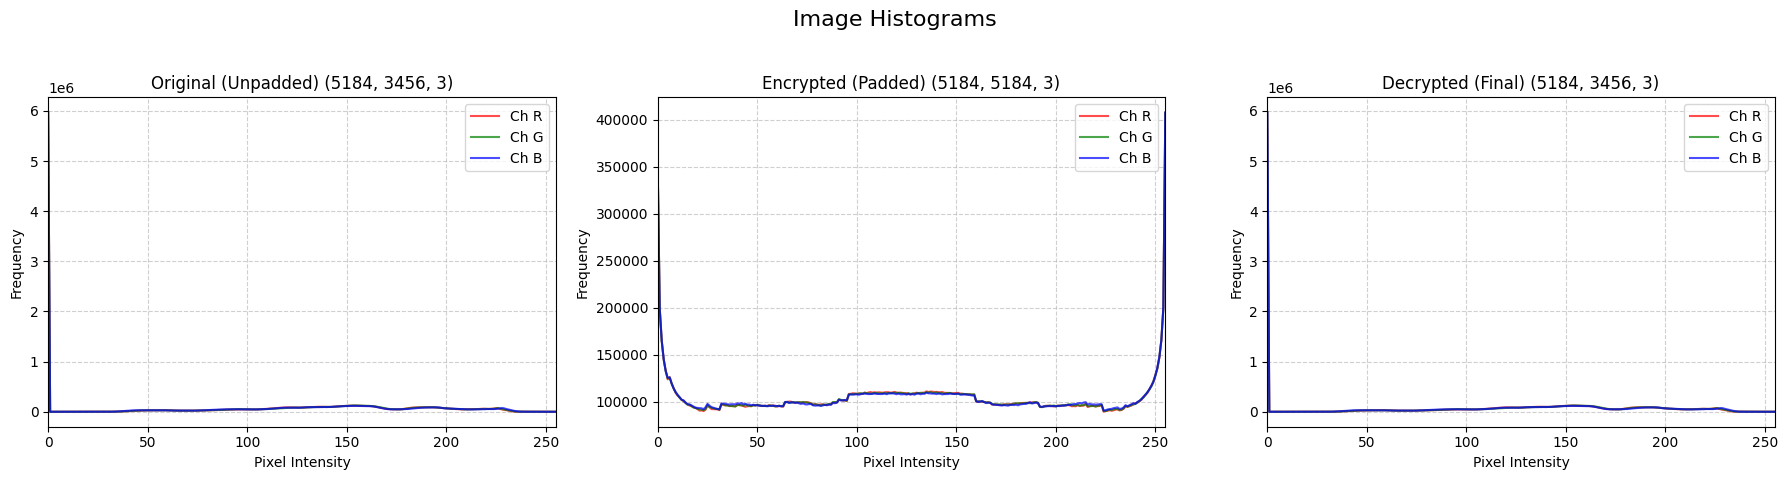

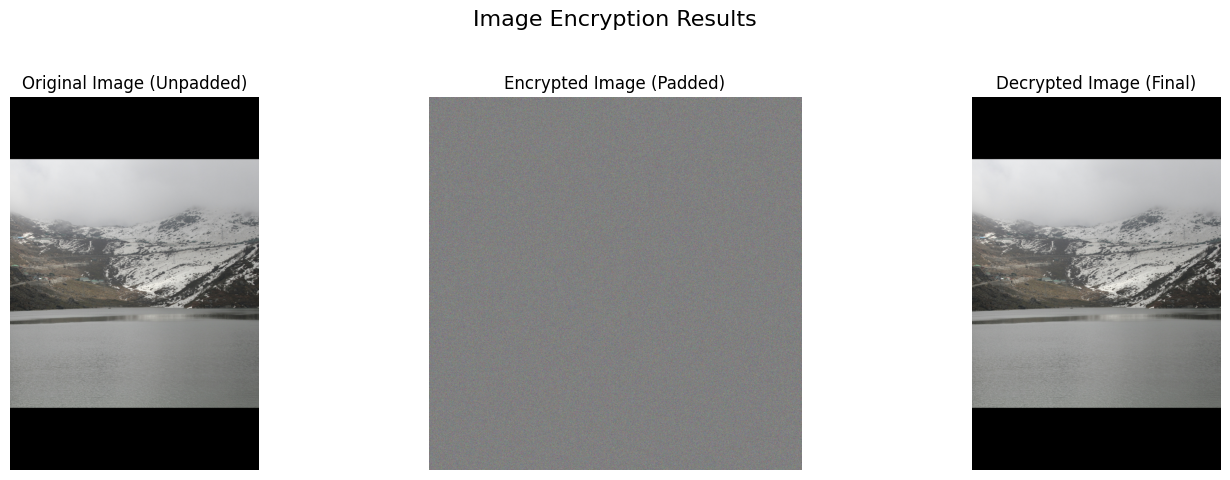


--- Key Sensitivity Test ---
Attempting decryption with slightly modified key (x0 = 0.31415936535)...
Starting Decryption Process (on decompressed data)...
Applying Logistic Map decryption (x0=0.31415936535, r=3.9999)...
Applying Inverse Arnold's Cat Map with 10 iterations (a=1, b=1)...
Removing padding to restore original size (5184, 3456)...
Final decrypted size after unpadding: (5184, 3456)
Decryption completed in 43.7289 seconds.
Resulting PSNR (Wrong Key): 7.0989 dB
Resulting SSIM (Wrong Key): 0.0070
Key sensitivity test PASSED: Decryption with slightly wrong key produced significantly different result.

--- Task 8: Saving and Downloading Output ---
Compressed encrypted data saved as: encrypted_compressed_data.zlib
Final decrypted image saved as: decrypted_image.png
Initiating Colab downloads (if files were saved)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Image Processing Script Execution Finished ---


In [ ]:
# %% [markdown]
# # Secure and Efficient Image Encryption with Compression and Upload/Download
#
# This notebook implements an image encryption scheme (Arnold's Cat Map + Logistic Map)
# with **lossless compression (zlib)** applied after encryption and decompression
# before decryption. It includes options to upload the source image and download the
# compressed encrypted data and final decrypted results.
#
# **Features:**
# - Upload an image file.
# - Encrypts the original (pre-compression) image using ACM + Logistic Map.
# - **Compresses** the encrypted image data using zlib.
# - **Verifies integrity** by hashing the **compressed encrypted data** using SHA-256.
# - Performs performance and security analysis.
# - Provides download links for the **compressed encrypted data** and the final decrypted image.
#
# **Correct Workflow:**
# 1. Upload Image -> Preprocess (Pad if needed) -> `original_image_padded`
# 2. Encrypt (`original_image_padded` with ACM + Logistic Map) -> `encrypted_image`
# 3. **Compress** `encrypted_image` (zlib) -> `compressed_encrypted_data`
# 4. **Calculate Hash** of `compressed_encrypted_data` -> `transmitted_hash`
# 5. (Simulate Reception)
# 6. **Verify Hash** of received compressed data against `transmitted_hash`. If mismatch, stop.
# 7. **Decompress** received data (zlib) -> `decompressed_encrypted_image` (Requires shape/dtype)
# 8. Decrypt `decompressed_encrypted_image` (Inverse Logistic + Inverse ACM)
# 9. Remove Padding -> `final_decrypted_image`
# 10. Analyze & Compare `final_decrypted_image` with original (unpadded).
#
# **Environment Notes:**
# - Uses `google.colab.files` for Colab upload/download.
# - Jupyter environments use `ipywidgets` and data URI links.

# %%
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import time
import math
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
import hashlib
import warnings
import os # For path manipulation if needed
import base64 # For potential data URI download links
import zlib # <--- Added for compression
import traceback # <--- Added for detailed error reporting

# --- Environment Specific Imports ---
try:
    from google.colab import files
    ENV = 'colab'
except ImportError:
    print("Not running in Google Colab. File upload/download will require manual steps or alternative libraries (like ipywidgets).")
    # Try importing tools for Jupyter download links
    try:
        from IPython.display import display, HTML
        import ipywidgets as widgets # Import for potential widget-based upload in Jupyter
        ENV = 'jupyter'
    except ImportError:
        print("IPython/ipywidgets not available. Download links may not be generated automatically.")
        ENV = 'other'


# Ignore specific warnings from skimage and PIL
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')
warnings.filterwarnings("ignore", category=UserWarning, module='PIL')
warnings.filterwarnings("ignore", category=FutureWarning, module='skimage')


# %% [markdown]
# ## Task 1: Image Preprocessing (Adapted for Uploaded Data)

# %%
def preprocess_image(img_input, target_size=None, grayscale=False, simulate_low_bandwidth=False, low_bw_size=(128, 128)):
    """Loads image from various inputs, converts, optionally resizes and pads."""
    try:
        if isinstance(img_input, (BytesIO, bytes)):
            # If input is bytes, wrap it in BytesIO
            if isinstance(img_input, bytes):
                img_input = BytesIO(img_input)
            img_input.seek(0) # Ensure reading from the start for BytesIO
            img = Image.open(img_input)
            print("Loaded image from uploaded data.")
        elif isinstance(img_input, str): # Keep URL/Path option as fallback
            # Basic check for URL (could be more robust)
            if img_input.startswith('http://') or img_input.startswith('https://'):
                 # If you need URL loading again, uncomment the next lines and import requests
                 # import requests
                 # response = requests.get(img_input)
                 # response.raise_for_status()
                 # img = Image.open(BytesIO(response.content))
                 # print(f"Loaded image from URL: {img_input}")
                 raise NotImplementedError("URL loading currently disabled. Upload file or use local path.")
            else:
                 img = Image.open(img_input)
                 print(f"Loaded image from Path: {img_input}")
        elif isinstance(img_input, Image.Image):
            img = img_input
            print("Processing provided PIL image object.")
        elif img_input is None: # Handle case where no input was provided (e.g., upload failed)
             raise ValueError("No valid image input provided.")
        else:
             raise ValueError(f"Unsupported input type for preprocess_image: {type(img_input)}")

    except FileNotFoundError:
        print(f"Error: File not found at path '{img_input}'.")
        print("Using a fallback procedural image.")
        img_array = np.zeros((256, 256, 3), dtype=np.uint8)
        img_array[:, :, 0] = np.linspace(0, 255, 256) # Red gradient
        img_array[:, :, 1] = np.linspace(0, 255, 256).T # Green gradient
        img_array[:, :, 2] = 128 # Blue constant
        img = Image.fromarray(img_array)
    except Exception as e:
        print(f"Error loading image: {e}")
        # Fallback to a default procedural image if loading fails
        print("Using a fallback procedural image.")
        img_array = np.zeros((256, 256, 3), dtype=np.uint8)
        img_array[:, :, 0] = np.linspace(0, 255, 256) # Red gradient
        img_array[:, :, 1] = np.linspace(0, 255, 256).T # Green gradient
        img_array[:, :, 2] = 128 # Blue constant
        img = Image.fromarray(img_array)


    original_mode = img.mode
    original_size_before_processing = img.size
    print(f"Original image mode: {original_mode}, size: {original_size_before_processing}")

    if grayscale and img.mode != 'L':
        img = img.convert('L')
        print(f"Converted to grayscale. New mode: {img.mode}")
    elif not grayscale and img.mode not in ['RGB', 'RGBA']:
         print(f"Converting mode {img.mode} to RGB for consistency.")
         img = img.convert('RGB')

    if img.mode == 'RGBA':
        print("Converting RGBA to RGB by blending onto a white background.")
        # Create a white background image
        bg = Image.new("RGB", img.size, (255, 255, 255))
        # Paste the RGBA image onto the white background using the alpha channel as mask
        try:
            # This assumes the alpha channel is the 4th channel
            bg.paste(img, mask=img.split()[3])
        except IndexError:
             print("Warning: Could not get alpha channel for RGBA conversion. Using image directly.")
             bg.paste(img) # Paste without mask if alpha split fails
        img = bg # Use the blended image

    # Dynamic resizing
    if simulate_low_bandwidth:
        print(f"Simulating low bandwidth. Resizing image to {low_bw_size}...")
        img = img.resize(low_bw_size, Image.Resampling.LANCZOS)
        print(f"Resized image size: {img.size}")
    elif target_size:
        # Ensure target_size is a tuple (width, height)
        if isinstance(target_size, (list, tuple)) and len(target_size) == 2:
            print(f"Resizing image to {target_size}...")
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            print(f"Resized image size: {img.size}")
        else:
            print(f"Warning: Invalid target_size {target_size}. Skipping resize.")


    img_array = np.array(img, dtype=np.uint8)

    # Padding to square shape (required for ACM)
    h, w = img_array.shape[:2]
    padded = False
    if h != w:
        padded = True
        print(f"Image is not square ({h}x{w}). Padding to make it square.")
        max_dim = max(h, w)
        pad_h = max_dim - h
        pad_w = max_dim - w
        # Calculate padding amounts for top, bottom, left, right
        # np.pad format: ((before_axis1, after_axis1), (before_axis2, after_axis2), ...)
        if img_array.ndim == 3: # Color image
            # ((top, bottom), (left, right), (channel_pad_before, channel_pad_after))
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0))
        else: # Grayscale image
            # ((top, bottom), (left, right))
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2))
        # Pad with constant value 0 (black)
        img_array = np.pad(img_array, pad_width, mode='constant', constant_values=0)
        print(f"Padded image size: {img_array.shape[:2]}")

    # Return the processed (potentially padded) array, the original size *before padding*, and the padding flag
    return img_array, original_size_before_processing, padded


# %% [markdown]
# ## Task 2: Encryption (Core Logic - ACM + Logistic Map)

# %%
# --- Arnold's Cat Map ---
def arnold_cat_map(img_array, iterations, a=1, b=1):
    """Applies Arnold's Cat Map for pixel shuffling."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if img_array.shape[0] != img_array.shape[1]:
        raise ValueError("Arnold's Cat Map requires a square image. Please pad first.")

    rows, cols = img_array.shape[:2]
    is_color = img_array.ndim == 3

    # Create index grid
    x, y = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    # Flatten indices for transformation
    coords = np.stack([x.flatten(), y.flatten()], axis=1)

    # Apply ACM transformation iteratively
    for i in range(iterations):
        new_coords = np.zeros_like(coords)
        # ACM formula: x' = (x + b*y) mod N, y' = (a*x + (a*b+1)*y) mod N
        new_coords[:, 0] = (coords[:, 0] + b * coords[:, 1]) % rows
        new_coords[:, 1] = (a * coords[:, 0] + (a * b + 1) * coords[:, 1]) % cols
        coords = new_coords # Update coordinates for next iteration
        # Optional: Add progress printout for large images/iterations
        # if (i+1) % 5 == 0: print(f"  ACM Iteration {i+1}/{iterations}")


    # Create the shuffled image
    shuffled_img = np.zeros_like(img_array)
    orig_indices = (x.flatten(), y.flatten()) # Original flat indices
    new_indices = (coords[:, 0], coords[:, 1]) # New flat indices after shuffling

    # Map original pixel values to new shuffled locations
    if is_color:
        for c in range(img_array.shape[2]):
            shuffled_img[new_indices[0], new_indices[1], c] = img_array[orig_indices[0], orig_indices[1], c]
    else: # Grayscale
        shuffled_img[new_indices[0], new_indices[1]] = img_array[orig_indices[0], orig_indices[1]]

    # Reshape back to original image dimensions
    return shuffled_img.reshape(img_array.shape)

def inverse_arnold_cat_map(shuffled_img_array, iterations, a=1, b=1):
    """Applies the inverse of Arnold's Cat Map."""
    if shuffled_img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if shuffled_img_array.shape[0] != shuffled_img_array.shape[1]:
        raise ValueError("Inverse Arnold's Cat Map requires a square image.")

    rows, cols = shuffled_img_array.shape[:2]
    is_color = shuffled_img_array.ndim == 3

    # Create index grid for the *shuffled* image
    x_shuffled, y_shuffled = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    coords_shuffled = np.stack([x_shuffled.flatten(), y_shuffled.flatten()], axis=1)

    # Apply inverse ACM transformation iteratively
    # Precompute matrix elements to avoid redundant calculations inside loop? Not necessary here.
    inv_coeff_00 = a * b + 1
    inv_coeff_01 = -b
    inv_coeff_10 = -a
    inv_coeff_11 = 1

    for i in range(iterations):
        coords_orig = np.zeros_like(coords_shuffled)
        # Inverse ACM formula: x = ((a*b+1)*x' - b*y') mod N, y = (-a*x' + y') mod N
        coords_orig[:, 0] = (inv_coeff_00 * coords_shuffled[:, 0] + inv_coeff_01 * coords_shuffled[:, 1]) % rows
        coords_orig[:, 1] = (inv_coeff_10 * coords_shuffled[:, 0] + inv_coeff_11 * coords_shuffled[:, 1]) % cols
        coords_shuffled = coords_orig # Update coordinates for next iteration
        # Optional: Add progress printout
        # if (i+1) % 5 == 0: print(f"  Inv ACM Iteration {i+1}/{iterations}")


    # Create the unshuffled image
    unshuffled_img = np.zeros_like(shuffled_img_array)
    shuffled_indices = (x_shuffled.flatten(), y_shuffled.flatten()) # Indices in the input shuffled image
    original_indices = (coords_shuffled[:, 0], coords_shuffled[:, 1]) # Calculated original indices

    # Map shuffled pixel values back to their original locations
    if is_color:
        for c in range(shuffled_img_array.shape[2]):
            unshuffled_img[original_indices[0], original_indices[1], c] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1], c]
    else: # Grayscale
        unshuffled_img[original_indices[0], original_indices[1]] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1]]

    return unshuffled_img.reshape(shuffled_img_array.shape)

# --- Logistic Map Chaos Encryption ---
def generate_logistic_map_sequence(x0, r, size):
    """Generates a chaotic sequence using the Logistic Map."""
    # Ensure parameters are floats
    x0 = float(x0)
    r = float(r)
    sequence = np.zeros(size, dtype=np.float64) # Use float64 for better precision
    x = x0
    # Burn-in iterations to reach chaotic regime
    # print("Logistic Map: Burn-in...") # Optional print
    for _ in range(100): # Discard initial values
        x = r * x * (1.0 - x)
    # Generate the sequence
    # print("Logistic Map: Generating sequence...") # Optional print
    for i in range(size):
        x = r * x * (1.0 - x)
        sequence[i] = x
        # Handle potential precision issues leading to exact 0 or 1 (unlikely with float64 but safe)
        if x == 0.0 or x == 1.0:
            # print(f"Warning: Logistic map sequence hit {x} at iteration {i}. Re-seeding slightly.")
            # Adding a tiny value might push it out of fixed point, but could introduce bias
            # x = np.fmod(x + 1e-9, 1.0) # Add small perturbation and wrap around using fmod
            # A potentially safer approach is to slightly perturb r or x0 if this happens often
            # For now, just continue, it's rare with proper parameters
            pass

    return sequence

def logistic_map_encrypt_decrypt(img_array, x0, r):
    """Encrypts or decrypts using Logistic Map sequence via XOR."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    img_dtype = img_array.dtype
    if img_dtype != np.uint8:
        print(f"Warning: Input image array dtype is {img_dtype}. Converting to uint8 for XOR.")
        img_array = img_array.astype(np.uint8)

    is_color = img_array.ndim == 3
    total_pixels = img_array.size # Total number of elements (pixels * channels)

    # Parameter checks for logistic map
    if not (3.57 <= r <= 4.0):
        print(f"Warning: Logistic map parameter r={r} might not be in the typical chaotic range [3.57, 4.0]. Results may be insecure.")
    if not (0 < x0 < 1):
         print(f"Warning: Logistic map initial value x0={x0} should be between 0 and 1. Clipping to avoid issues.")
         # Clip x0 slightly away from 0 and 1
         x0 = np.clip(x0, 1e-6, 1.0 - 1e-6)

    try:
        # Generate keystream (float values between 0 and 1)
        keystream_float = generate_logistic_map_sequence(x0, r, total_pixels)
        # Scale to 0-255 and convert to uint8 for XOR
        # Scaling by 255.999... maps (0, 1) to [0, 255] after casting
        keystream_uint8 = (keystream_float * 255.999999).astype(np.uint8)
    except OverflowError:
        print(f"FATAL: OverflowError during logistic map generation with r={r}, x0={x0}. This usually indicates unstable parameters. Stopping.")
        # Using fallback random stream here masks instability, better to raise error
        raise ValueError(f"Logistic map overflowed with r={r}, x0={x0}.")
        # keystream_uint8 = np.random.randint(0, 256, size=total_pixels, dtype=np.uint8)

    # Flatten image and keystream for XOR operation
    # Ensure keystream matches the flattened image length precisely
    keystream_reshaped = keystream_uint8 # Already flat
    img_flat = img_array.flatten()

    if len(img_flat) != len(keystream_reshaped):
         raise ValueError(f"Image flat size ({len(img_flat)}) and keystream size ({len(keystream_reshaped)}) mismatch.")

    # Perform XOR operation element-wise
    processed_flat = np.bitwise_xor(img_flat, keystream_reshaped)

    # Reshape back to original image shape
    processed_img = processed_flat.reshape(img_array.shape)
    # Ensure output is uint8
    return processed_img.astype(np.uint8)

# --- Combined Encryption Function ---
def encrypt_image(img_array, acm_iterations, logistic_x0, logistic_r, acm_a=1, acm_b=1):
    """Combines ACM shuffling and Logistic Map encryption on pixel data."""
    print("Starting Encryption Process...")
    start_time = time.time()
    # 1. Shuffle pixels with Arnold's Cat Map
    print(f"Applying Arnold's Cat Map with {acm_iterations} iterations (a={acm_a}, b={acm_b})...")
    try:
        # Ensure input is uint8 before shuffling if needed (though ACM itself doesn't require it)
        if img_array.dtype != np.uint8:
            print(f"  Converting image to uint8 before ACM.")
            img_array = img_array.astype(np.uint8)
        shuffled_img = arnold_cat_map(img_array, acm_iterations, acm_a, acm_b)
    except ValueError as e:
        print(f"Error during ACM: {e}. Returning original image.")
        return img_array, 0 # Return original and 0 time

    # 2. Encrypt pixel values with Logistic Map XOR
    print(f"Applying Logistic Map encryption (x0={logistic_x0}, r={logistic_r})...")
    try:
        encrypted_img = logistic_map_encrypt_decrypt(shuffled_img, logistic_x0, logistic_r)
    except ValueError as e:
        print(f"Error during Logistic Map encryption: {e}. Returning shuffled image.")
        return shuffled_img, time.time() - start_time # Return intermediate and partial time

    end_time = time.time()
    encryption_time = end_time - start_time
    print(f"Encryption completed in {encryption_time:.4f} seconds.")
    return encrypted_img, encryption_time


# %% [markdown]
# ## Task 3: Compression (zlib) and Hashing of Compressed Data

# %%
def compress_data(data_array):
    """Compresses a NumPy array using zlib."""
    print("Starting Compression...")
    start_time = time.time()
    # Ensure data is in bytes format
    try:
        original_bytes = data_array.tobytes()
    except AttributeError:
         print("Error: Input data_array does not support .tobytes(). Is it a NumPy array?")
         return None, 0

    # Use a good compression level (1-9, 9 is highest, 6 is default)
    compression_level = 7 # Good balance
    compressed_bytes = zlib.compress(original_bytes, level=compression_level)
    end_time = time.time()
    compression_time = end_time - start_time

    original_size = len(original_bytes)
    compressed_size = len(compressed_bytes)
    ratio = compressed_size / original_size if original_size > 0 else 0
    print(f"Compression (zlib level {compression_level}) completed in {compression_time:.4f} seconds.")
    print(f"Original size: {original_size} bytes, Compressed size: {compressed_size} bytes, Ratio: {ratio:.4f}")
    return compressed_bytes, compression_time

def calculate_hash_bytes(byte_data):
    """Calculates the SHA-256 hash of byte data."""
    if not isinstance(byte_data, bytes):
        raise TypeError("Input for hashing must be bytes.")
    hasher = hashlib.sha256()
    hasher.update(byte_data)
    return hasher.hexdigest()


# %% [markdown]
# ## Task 4: Decompression (zlib), Decryption & Integrity Verification

# %%
def decompress_data(compressed_bytes, original_shape, original_dtype):
    """Decompresses byte data (from zlib) back into a NumPy array."""
    print("Starting Decompression...")
    start_time = time.time()
    if not isinstance(compressed_bytes, bytes):
         print("Error: Input for decompression must be bytes.")
         return None, 0

    try:
        decompressed_bytes = zlib.decompress(compressed_bytes)

        # --- Verification Step ---
        # Calculate expected size in bytes from shape and dtype
        try:
             dtype_itemsize = np.dtype(original_dtype).itemsize
             expected_bytes = np.prod(original_shape) * dtype_itemsize
        except TypeError as e:
             print(f"Error calculating expected size: Invalid shape {original_shape} or dtype {original_dtype}? {e}")
             # Cannot reliably reshape if expected size is unknown
             raise ValueError("Cannot determine expected size from shape/dtype.")


        if len(decompressed_bytes) != expected_bytes:
             print(f"FATAL: Decompressed byte count ({len(decompressed_bytes)}) does not match expected count ({expected_bytes}) based on provided shape {original_shape} and dtype {original_dtype}.")
             print("This indicates data corruption, incorrect shape/dtype passed, or compression issues.")
             # Return None as reshaping will fail or produce incorrect data
             return None, time.time() - start_time # Return None and time taken so far

        # --- Reshape Step ---
        # Convert bytes back to NumPy array using the known dtype
        data_array = np.frombuffer(decompressed_bytes, dtype=original_dtype)
        # Reshape to the original array dimensions
        data_array = data_array.reshape(original_shape)

        end_time = time.time()
        decompression_time = end_time - start_time
        print(f"Decompression completed in {decompression_time:.4f} seconds.")
        return data_array, decompression_time

    except zlib.error as e:
        print(f"Error during zlib decompression: {e}. Data may be corrupted.")
        return None, time.time() - start_time
    except ValueError as e:
        # This might catch the reshape error if the byte count check above was bypassed
        print(f"Error reshaping decompressed data (likely size mismatch or shape/dtype error): {e}")
        return None, time.time() - start_time
    except Exception as e:
        print(f"An unexpected error occurred during decompression: {e}")
        traceback.print_exc() # Print full traceback for unexpected errors
        return None, time.time() - start_time


def decrypt_image(encrypted_img_array, acm_iterations, logistic_x0, logistic_r, original_shape_before_padding, padded, acm_a=1, acm_b=1):
    """Reverses the encryption: Logistic Map decrypt -> Inverse ACM -> Unpad."""
    # Input `encrypted_img_array` here is the *decompressed* encrypted image.
    if encrypted_img_array is None:
         print("Error: Cannot decrypt None input.")
         return None, 0

    print("Starting Decryption Process (on decompressed data)...")
    start_time = time.time()

    # 1. Decrypt pixel values using Logistic Map (XOR is its own inverse)
    print(f"Applying Logistic Map decryption (x0={logistic_x0}, r={logistic_r})...")
    try:
        decrypted_shuffled_img = logistic_map_encrypt_decrypt(encrypted_img_array, logistic_x0, logistic_r)
    except ValueError as e:
         print(f"Error during Logistic Map decryption: {e}. Returning None.")
         return None, time.time() - start_time

    # 2. Unshuffle pixels using Inverse Arnold's Cat Map
    print(f"Applying Inverse Arnold's Cat Map with {acm_iterations} iterations (a={acm_a}, b={acm_b})...")
    try:
        unshuffled_padded_img = inverse_arnold_cat_map(decrypted_shuffled_img, acm_iterations, acm_a, acm_b)
    except ValueError as e:
         print(f"Error during Inverse ACM: {e}. Cannot unpad. Returning partially decrypted (shuffled) image.")
         # We can't reliably unpad if the inverse shuffling failed
         return decrypted_shuffled_img, time.time() - start_time

    # 3. Remove padding if it was added during preprocessing
    final_decrypted_img = unshuffled_padded_img # Assume no padding needed initially
    if padded: # Check the flag passed from preprocessing
        current_h, current_w = unshuffled_padded_img.shape[:2]
        orig_h, orig_w = original_shape_before_padding # Use the original size before padding

        # Basic sanity check on dimensions before slicing
        if orig_h > current_h or orig_w > current_w:
             print(f"Error: Original dimensions ({orig_h}x{orig_w}) seem larger than current image dimensions ({current_h}x{current_w}) after inverse ACM. Cannot unpad.")
             # Return the unshuffled padded image as best result possible
             return unshuffled_padded_img, time.time() - start_time

        # Sanity check: Did padding actually change dimensions?
        if current_h != orig_h or current_w != orig_w:
            print(f"Removing padding to restore original size {original_shape_before_padding}...")
            # Calculate how much padding was added (total)
            pad_h_total = current_h - orig_h
            pad_w_total = current_w - orig_w
            # Calculate padding on each side (assuming symmetric padding was used)
            pad_top = pad_h_total // 2
            pad_left = pad_w_total // 2

            # Slice the array to remove padding
            try:
                if unshuffled_padded_img.ndim == 3: # Color
                    final_decrypted_img = unshuffled_padded_img[pad_top : pad_top + orig_h, pad_left : pad_left + orig_w, :]
                else: # Grayscale
                    final_decrypted_img = unshuffled_padded_img[pad_top : pad_top + orig_h, pad_left : pad_left + orig_w]
                print(f"Final decrypted size after unpadding: {final_decrypted_img.shape[:2]}")
            except IndexError as e:
                 print(f"Error during unpadding slice (calculated indices might be wrong): {e}")
                 print(f"  current={current_h}x{current_w}, orig={orig_h}x{orig_w}, top={pad_top}, left={pad_left}")
                 # Return the unshuffled padded image as best result possible
                 return unshuffled_padded_img, time.time() - start_time
        else:
            # This case implies padding flag was true, but dimensions didn't change. Maybe original was already square?
             print("Padding flag was set, but dimensions seem to match the original size. No padding removed.")
             final_decrypted_img = unshuffled_padded_img # Keep the image as is
    else:
        print("No padding was added initially, skipping unpadding step.")

    end_time = time.time()
    decryption_time = end_time - start_time
    print(f"Decryption completed in {decryption_time:.4f} seconds.")
    # Ensure output is uint8, especially important after potential float operations in analysis tools later
    return final_decrypted_img.astype(np.uint8), decryption_time

def verify_integrity_compressed(received_compressed_data, original_compressed_hash):
    """Compares the hash of the received compressed data with the original expected hash."""
    print(f"\n--- Tamper Verification (Compressed Data) ---")
    if not isinstance(received_compressed_data, bytes):
        print("Error: Received data for hash verification is not bytes.")
        return False
    if not isinstance(original_compressed_hash, str) or len(original_compressed_hash) != 64:
        print("Error: Original hash for comparison is invalid.")
        return False

    print(f"Expected Hash:  {original_compressed_hash}")
    # Calculate hash of the received compressed data
    try:
        calculated_hash = calculate_hash_bytes(received_compressed_data)
        print(f"Calculated Hash:{calculated_hash}")
    except Exception as e:
        print(f"Error calculating hash of received data: {e}")
        return False

    if original_compressed_hash == calculated_hash:
        print("Integrity Check PASSED: Compressed data hashes match.")
        return True
    else:
        print("Integrity Check FAILED: Compressed data hashes DO NOT match. Data may be corrupted or tampered with.")
        return False


# %% [markdown]
# ## Task 5: Performance Analysis (Functions - Mostly Unchanged)

# %%
def calculate_metrics(img_orig, img_processed, data_range=255):
    """Calculates MSE, PSNR, SSIM, and Entropy."""
    # Ensure inputs are NumPy arrays
    if not isinstance(img_orig, np.ndarray) or not isinstance(img_processed, np.ndarray):
        print("Error: Inputs for metrics must be NumPy arrays.")
        # Return default/error values
        entropy_orig = shannon_entropy(img_orig) if isinstance(img_orig, np.ndarray) else float('nan')
        return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': entropy_orig, 'entropy_proc': float('nan')}

    # Ensure images are uint8 for standard metrics
    # Check dtype *before* astype to avoid unnecessary conversions/warnings
    if img_orig.dtype != np.uint8:
         # print(f"Converting original image from {img_orig.dtype} to uint8 for metrics.")
         img_orig = img_orig.astype(np.uint8)
    if img_processed.dtype != np.uint8:
         # print(f"Converting processed image from {img_processed.dtype} to uint8 for metrics.")
         img_processed = img_processed.astype(np.uint8)


    if img_orig.shape != img_processed.shape:
        print(f"Warning: Original ({img_orig.shape}) and processed ({img_processed.shape}) images have different shapes for metrics calculation.")
        print("This often happens if decryption/unpadding failed.")
        print("Metrics calculation skipped due to shape mismatch.")
        return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': shannon_entropy(img_orig), 'entropy_proc': float('nan')}

    # --- Calculate Metrics ---
    try:
        mse_val = mse(img_orig, img_processed)
    except Exception as e:
        print(f"Error calculating MSE: {e}")
        mse_val = float('inf')

    try:
        # PSNR calculation handles mse_val=0 correctly (returns inf)
        psnr_val = psnr(img_orig, img_processed, data_range=data_range)
    except Exception as e:
        print(f"Error calculating PSNR: {e}")
        psnr_val = 0 # Or float('-inf')? 0 is common for error.

    # SSIM calculation
    ssim_val = 0 # Default in case of error or small image
    try:
        multichannel = img_orig.ndim == 3
        min_dim = min(img_orig.shape[:2])
        # Default SSIM window size in skimage is min(7, N) where N is spatial dimension
        # Ensure window size is odd and >= 3
        win_size = min(7, min_dim)
        if win_size < 3:
             print(f"Image dimensions ({img_orig.shape[:2]}) too small for SSIM. Setting SSIM to 0.")
        elif win_size % 2 == 0:
             win_size -= 1 # Make odd

        if win_size >= 3:
             # Determine channel_axis based on multichannel flag AFTER checking dimensions
             c_axis = 2 if multichannel else None
             ssim_val = ssim(img_orig, img_processed, data_range=data_range,
                             multichannel=multichannel, channel_axis=c_axis,
                             win_size=win_size)
    except ValueError as e:
         # Catch potential errors like window size > image dimension
         print(f"Error calculating SSIM (check window size vs image dim): {e}. Setting SSIM to 0.")
         ssim_val = 0
    except Exception as e:
         print(f"Unexpected error calculating SSIM: {e}")
         ssim_val = 0


    # Entropy calculation
    try:
        entropy_orig_val = shannon_entropy(img_orig)
    except Exception as e:
        print(f"Error calculating original entropy: {e}")
        entropy_orig_val = float('nan')
    try:
        entropy_proc_val = shannon_entropy(img_processed)
    except Exception as e:
        print(f"Error calculating processed entropy: {e}")
        entropy_proc_val = float('nan')


    metrics = {
        'mse': mse_val,
        'psnr': psnr_val,
        'ssim': ssim_val,
        'entropy_orig': entropy_orig_val,
        'entropy_proc': entropy_proc_val
    }
    return metrics

def plot_histograms(img_orig, img_encrypted, img_decrypted):
    """Plots histograms for original, encrypted (padded), and decrypted images."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Image Histograms', fontsize=16)
    colors = ('r', 'g', 'b')
    labels = ('Original (Unpadded)', 'Encrypted (Padded)', 'Decrypted (Final)')
    images = (img_orig, img_encrypted, img_decrypted)

    for i, img in enumerate(images):
        ax = axes[i]
        if img is None or not isinstance(img, np.ndarray): # Check if image data is valid
            ax.set_title(f"{labels[i]} (Not Available)")
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='red')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Proceed with plotting if image is valid
        ax.set_title(labels[i] + f" {img.shape}") # Add shape to title
        ax.set_xlabel('Pixel Intensity'); ax.set_ylabel('Frequency')
        try:
            if img.ndim == 3: # Color image
                # Plot histogram for each color channel
                for c_idx, color in enumerate(colors):
                    if c_idx < img.shape[2]: # Check if channel exists (e.g., might be 2-channel?)
                        # Use np.histogram for robustness
                        hist, bin_edges = np.histogram(img[:, :, c_idx].ravel(), bins=256, range=[0, 256])
                        ax.plot(bin_edges[:-1], hist, color=color, alpha=0.7, label=f'Ch {color.upper()}')
                if img.shape[2] > 1 : ax.legend(loc='upper right') # Show legend only if multiple channels plotted
            elif img.ndim == 2: # Grayscale image
                hist, bin_edges = np.histogram(img.ravel(), bins=256, range=[0, 256])
                ax.plot(bin_edges[:-1], hist, color='black')
            else:
                 ax.text(0.5, 0.5, f'Invalid Dim {img.ndim}', ha='center', va='center', transform=ax.transAxes)


            ax.set_xlim([0, 255])
            ax.grid(True, linestyle='--', alpha=0.6)
        except Exception as e:
             print(f"Error plotting histogram for {labels[i]}: {e}")
             ax.text(0.5, 0.5, 'Plotting Error', ha='center', va='center', transform=ax.transAxes, color='red')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

def display_images(img_orig, img_encrypted, img_decrypted):
    """Displays the original (unpadded), encrypted (padded), and decrypted (final) images."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Image Encryption Results', fontsize=16)
    titles = ['Original Image (Unpadded)', 'Encrypted Image (Padded)', 'Decrypted Image (Final)']
    images = [img_orig, img_encrypted, img_decrypted]

    for ax, img, title in zip(axes, images, titles):
        ax.set_title(title)
        ax.axis('off') # Hide axes ticks
        if img is not None and isinstance(img, np.ndarray):
            # Determine colormap (grayscale or color)
            cmap = 'gray' if img.ndim == 2 else None
            try:
                ax.imshow(img, cmap=cmap)
            except Exception as e:
                 print(f"Error displaying image '{title}': {e}")
                 ax.text(0.5, 0.5, 'Display Error', ha='center', va='center', transform=ax.transAxes, color='red')

        else:
             # Display N/A if image is missing or invalid
             ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='red')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

# --- Helper for Jupyter Download Link ---
def create_download_link_jupyter(filename, data_bytes, link_text, mime_type='application/octet-stream'):
    """Generates an HTML download link for Jupyter using base64 encoded bytes."""
    if ENV != 'jupyter' or not isinstance(data_bytes, bytes):
        return "" # Only run in Jupyter env and only if data is bytes
    try:
        b64 = base64.b64encode(data_bytes).decode('ascii') # Use ascii for base64
        href = f'<a href="data:{mime_type};base64,{b64}" download="{os.path.basename(filename)}">{link_text}</a>'
        return href
    except Exception as e:
        print(f"Error creating download link for {filename}: {e}")
        return f"<span>Error creating link for {filename}</span>"


# %% [markdown]
# ## Main Execution Block (Upload, Process, Analyze, Download)

# %%
# --- Configuration ---
# Encryption Keys (!!! USE SECURE RANDOM KEYS IN PRACTICE !!!)
# Using fixed keys for reproducibility in demo
ACM_ITERATIONS = 10 # Lowered slightly for potentially large images
ACM_A = 1; ACM_B = 1 # Standard ACM parameters
LOGISTIC_X0 = 0.31415926535 # Initial condition for logistic map (use high precision)
LOGISTIC_R = 3.9999          # Parameter for logistic map (very close to 4, highly chaotic)

# Preprocessing settings
USE_GRAYSCALE = False             # Convert to grayscale before processing?
SIMULATE_LOW_BANDWIDTH = False    # Resize image to simulate low bandwidth?
RESIZE_TARGET = None #(512, 512)  # Target size if resizing (e.g., (256, 256)). None means no resize.

# Output filenames
# NOTE: Encrypted file now stores compressed raw data, suggest non-image extension
COMPRESSED_ENCRYPTED_FILENAME = "encrypted_compressed_data.zlib" # Changed extension
DECRYPTED_FILENAME = "decrypted_image.png" # Keep as PNG

# --- Global variables to store results across steps (initialize) ---
original_image_unpadded = None
original_image_padded = None
encrypted_image = None
compressed_encrypted_data = None
transmitted_hash = None
decompressed_encrypted_image = None
final_decrypted_image = None
integrity_check_passed = False # Assume failure until success
encryption_time = 0
compression_time = 0
decompression_time = 0
decryption_time = 0
original_size_before_padding = (0,0)
was_padded = False
encrypted_shape = None
encrypted_dtype = None


# --- Get Image Input ---
uploaded_file_name = None
img_data_input = None # This will hold the image data (BytesIO, path, etc.)

print("--- Starting Setup ---") # Added print

if ENV == 'colab':
    print("Environment: Google Colab")
    print("Please upload an image file:")
    try:
        uploaded = files.upload()
        if uploaded:
            # Get the first uploaded file's name and content
            uploaded_file_name = next(iter(uploaded))
            img_data_input = uploaded[uploaded_file_name] # Pass raw bytes to preprocessing
            print(f"Successfully uploaded: {uploaded_file_name} ({len(img_data_input)} bytes)")
        else:
            print("No file uploaded. Will use fallback image.")
            img_data_input = None # Let preprocessing handle fallback
    except Exception as e:
        print(f"An error occurred during Colab upload: {e}")
        img_data_input = None # Let preprocessing handle fallback

elif ENV == 'jupyter':
     print("Environment: Jupyter Notebook/Lab")
     print("Please use the widget below to upload an image file:")
     # Define the uploader widget
     uploader = widgets.FileUpload(
         accept='image/*', # Allow common image types
         multiple=False, # Allow only single file upload
         description="Upload Image" # Add description
     )
     display(uploader) # Show the widget
     # IMPORTANT FOR JUPYTER:
     # 1. Run this cell.
     # 2. Use the widget that appears above to upload your file.
     # 3. Manually run the NEXT cell (Processing & Analysis) after upload completes.
     # We store the uploader object ('uploader') to retrieve the value in the next cell.

     # Optional: Provide a hardcoded path as a fallback if widget isn't used
     # file_path = "lena_color.png" # Example path
     # if 'uploader' not in locals() or not uploader.value: # Check if widget was used
     #      if os.path.exists(file_path):
     #           img_data_input = file_path
     #           uploaded_file_name = os.path.basename(file_path)
     #           print(f"Using hardcoded file path: {file_path}")
     #      else:
     #           print(f"Hardcoded file path not found: {file_path}. Please use upload widget or provide valid path.")
     #           img_data_input = None # Ensure it's None if file not found

else: # 'other' environment (e.g., standard Python script)
    print("Environment: Other (e.g., script)")
    # Fallback: Specify a local file path directly
    # !!! USER ACTION REQUIRED: Change this path to your image file !!!
    try:
        # Default path, user should change this
        file_path = "input_image.png" # <--- CHANGE THIS PATH IF NEEDED
        # Check if file exists before proceeding
        if os.path.exists(file_path):
            img_data_input = file_path # Pass the path string to preprocessing
            uploaded_file_name = os.path.basename(file_path)
            print(f"Using local file: {file_path}")
        else:
             print(f"File not found at specified path: {file_path}.")
             print("Will use fallback image.")
             img_data_input = None # Let preprocessing handle fallback
    except Exception as e:
        print(f"Error accessing local file path '{file_path}': {e}")
        img_data_input = None # Let preprocessing handle fallback


# %% [markdown]
# ## Processing & Analysis (Run this cell after upload completes)

# %%
# --- Continue Execution (Run this cell after uploading in Jupyter) ---

# Handle Jupyter upload widget result if applicable
if ENV == 'jupyter' and 'uploader' in locals() and uploader.value:
    try:
        # uploader.value is a dictionary where keys are filenames and values are file info dicts
        uploaded_file_key = list(uploader.value.keys())[0] # Get the first filename key
        uploaded_file_info = uploader.value[uploaded_file_key] # Get the file info dict

        uploaded_file_name = uploaded_file_info['metadata']['name']
        # Pass the raw content (bytes) directly to preprocessing
        img_data_input = uploaded_file_info['content']
        print(f"Processing uploaded file (Jupyter): {uploaded_file_name} ({len(img_data_input)} bytes)")
        # Optional: Clear the widget value if you want to allow re-runs with new uploads easily
        # uploader.value.clear()
        # uploader._counter = 0 # Reset counter to allow re-upload of same file name
    except Exception as e:
        print(f"Error processing Jupyter upload: {e}")
        # Ensure img_data_input is None if processing fails, allowing fallback
        img_data_input = None


# --- Main Processing Pipeline ---
# Wrap the entire pipeline in a try/except/finally block for robust error handling

print("\n--- Starting Image Processing Pipeline ---")
# Make sure traceback is imported if an error occurs
# import traceback # Already imported earlier

# <<<< ****** START OF THE MAIN TRY BLOCK ****** >>>>
try:
    # --- Step 1: Preprocessing ---
    print("\n--- Task 1: Preprocessing ---")
    # Returns the potentially padded square array, the original size (h, w) before padding, and a flag
    original_image_padded, original_size_before_padding, was_padded = preprocess_image(
        img_data_input, # Can be BytesIO, path string, bytes, or None
        target_size=RESIZE_TARGET,
        grayscale=USE_GRAYSCALE,
        simulate_low_bandwidth=SIMULATE_LOW_BANDWIDTH
    )

    if original_image_padded is None:
        raise ValueError("Preprocessing failed to produce an image array.")

    # Store the original unpadded image for final comparison/metrics
    # Reconstruct it *before* encryption affects the padded version
    h_orig, w_orig = original_size_before_padding
    if was_padded:
        # Calculate padding amounts used during preprocess_image
        pad_h_total = original_image_padded.shape[0] - h_orig
        pad_w_total = original_image_padded.shape[1] - w_orig
        pad_top = pad_h_total // 2
        pad_left = pad_w_total // 2
        # Slice carefully
        if original_image_padded.ndim == 3:
            original_image_unpadded = original_image_padded[pad_top : pad_top + h_orig, pad_left : pad_left + w_orig, :].copy()
        else: # Grayscale
            original_image_unpadded = original_image_padded[pad_top : pad_top + h_orig, pad_left : pad_left + w_orig].copy()
    else:
        # If not padded, the 'padded' array is the original (or resized) one
        original_image_unpadded = original_image_padded.copy()

    print(f"Original image dimensions stored for metrics: {original_image_unpadded.shape}")
    print(f"Image array type after preprocessing: {original_image_padded.dtype}")


    # --- Step 2: Encryption ---
    print("\n--- Task 2: Encryption ---")
    # Encrypt the potentially padded image array
    encrypted_image, encryption_time = encrypt_image(
        original_image_padded, # Use the square, padded array for ACM
        acm_iterations=ACM_ITERATIONS,
        logistic_x0=LOGISTIC_X0, logistic_r=LOGISTIC_R,
        acm_a=ACM_A, acm_b=ACM_B
    )
    if encrypted_image is None:
        raise ValueError("Encryption failed.")
    # Store shape and dtype needed for decompression later
    encrypted_shape = encrypted_image.shape
    encrypted_dtype = encrypted_image.dtype
    print(f"Encrypted image shape: {encrypted_shape}, dtype: {encrypted_dtype}")


    # --- Step 3: Compression ---
    print("\n--- Task 3: Compression (zlib) ---")
    # Compress the encrypted image array
    compressed_encrypted_data, compression_time = compress_data(encrypted_image)
    if compressed_encrypted_data is None:
        raise ValueError("Compression failed.")


    # --- Step 4: Hashing (for Tamper Proofing) ---
    print("\n--- Task 4: Hashing Compressed Data ---")
    # Calculate hash of the compressed data (this is what we'd "transmit")
    transmitted_hash = calculate_hash_bytes(compressed_encrypted_data)
    print(f"Calculated SHA-256 Hash of Compressed Data: {transmitted_hash}")


    # --- (Simulate Reception & Tamper Check) ---
    # In a real scenario, 'received_compressed_data' would come from network/disk
    # For this single-cell demo, we just use the variable we have.
    received_compressed_data = compressed_encrypted_data
    received_hash = transmitted_hash # Assume the hash is received correctly alongside

    # Verify integrity of the compressed data *before* decompression
    integrity_check_passed = verify_integrity_compressed(received_compressed_data, received_hash)


    # --- Step 5: Decompression (if integrity check passed) ---
    if integrity_check_passed:
        print("\n--- Task 5: Decompression (zlib) ---")
        # Decompress the data, needs the original shape and dtype of the *encrypted* array
        decompressed_encrypted_image, decompression_time = decompress_data(
            received_compressed_data,
            encrypted_shape,
            encrypted_dtype
        )
        if decompressed_encrypted_image is None:
            print("Decompression failed. Cannot proceed with decryption.")
            # Mark overall process as failed if decompression fails
            integrity_check_passed = False
    else:
        print("\nSkipping Decompression and Decryption due to failed integrity check.")
        decompressed_encrypted_image = None


    # --- Step 6: Decryption (if decompression was successful) ---
    # Also check integrity_check_passed again, in case decompression failed
    if integrity_check_passed and decompressed_encrypted_image is not None:
        print("\n--- Task 6: Decryption ---")
        # Decrypt the decompressed image array
        # Pass original size and padding flag for correct unpadding
        final_decrypted_image, decryption_time = decrypt_image(
            decompressed_encrypted_image,
            acm_iterations=ACM_ITERATIONS,
            logistic_x0=LOGISTIC_X0, logistic_r=LOGISTIC_R,
            original_shape_before_padding=original_size_before_padding, # Original H, W tuple
            padded=was_padded, # Boolean flag
            acm_a=ACM_A, acm_b=ACM_B
        )
        if final_decrypted_image is None:
             print("Decryption process failed to produce final image.")
             # Mark overall success as false if final decryption step fails
             integrity_check_passed = False

    else:
        # Ensure final_decrypted_image is None if skipping or if previous steps failed
        print("\nSkipping Decryption.")
        final_decrypted_image = None


    # --- Step 7: Performance & Security Analysis ---
    print("\n--- Task 7: Performance & Security Analysis ---")
    print("\n--- Timing ---")
    print(f"Encryption Time:   {encryption_time:.4f}s")
    print(f"Compression Time:  {compression_time:.4f}s")
    print(f"Decompression Time:{decompression_time:.4f}s")
    print(f"Decryption Time:   {decryption_time:.4f}s")
    total_time = encryption_time + compression_time + decompression_time + decryption_time
    print(f"Total Time (Enc->Comp->Decomp->Dec): {total_time:.4f}s")
    if original_image_padded is not None:
         print(f"Image dimensions processed (padded): {original_image_padded.shape}")
    if original_image_unpadded is not None:
         print(f"Original unpadded dimensions: {original_image_unpadded.shape}")

    print("\n--- Similarity Metrics (Original Unpadded vs Final Decrypted) ---")
    # Check both integrity_check_passed AND if final_decrypted_image is valid
    if integrity_check_passed and final_decrypted_image is not None:
        # Compare the final result with the *original unpadded* image
        metrics_decrypted = calculate_metrics(original_image_unpadded, final_decrypted_image)
        print(f"MSE:  {metrics_decrypted.get('mse', 'N/A'):.4f}")
        # Handle potential infinity PSNR for perfect reconstruction
        psnr_val = metrics_decrypted.get('psnr', 0)
        psnr_str = f"{psnr_val:.4f} dB" if np.isfinite(psnr_val) else "inf (Perfect Reconstruction)"
        print(f"PSNR: {psnr_str}")
        print(f"SSIM: {metrics_decrypted.get('ssim', 'N/A'):.4f}")
        print(f"Entropy (Original):  {metrics_decrypted.get('entropy_orig', 'N/A'):.4f}")
        print(f"Entropy (Decrypted): {metrics_decrypted.get('entropy_proc', 'N/A'):.4f}")

        # Add a clearer success message based on metrics
        if metrics_decrypted.get('mse', 1) < 1e-6: # Check if MSE is near zero
             print("\nMetrics suggest Decryption SUCCESSFUL (Low MSE, High PSNR/SSIM).")
        else:
             print("\nWarning: Metrics indicate differences between original and decrypted images.")
    else:
        print("Skipping decrypted metrics calculation (Integrity check failed or decryption error).")
        # Calculate original entropy anyway if possible
        if original_image_unpadded is not None:
             try:
                  print(f"Entropy (Original):  {shannon_entropy(original_image_unpadded):.4f}")
             except Exception as e:
                  print(f"Could not calculate original entropy: {e}")


    print("\n--- Security Analysis (Original Unpadded vs Encrypted Padded) ---")
    # Compare original unpadded entropy vs encrypted (padded) entropy
    if original_image_unpadded is not None and encrypted_image is not None:
         try:
              entropy_original = shannon_entropy(original_image_unpadded)
              entropy_encrypted = shannon_entropy(encrypted_image) # Analyze the encrypted image before compression
              print(f"Entropy (Original Unpadded): {entropy_original:.4f}")
              print(f"Entropy (Encrypted Padded):  {entropy_encrypted:.4f}")
              # Check if entropy increased significantly and approaches max (8 for uint8)
              ideal_entropy = 8.0 * (np.log2(256) / 8.0) # Ideal entropy for uint8 is 8.0
              entropy_diff = entropy_encrypted - entropy_original
              if entropy_diff > 0.5 and abs(entropy_encrypted - ideal_entropy) < 0.5:
                  print("Entropy increased significantly towards ideal random distribution (Good).")
              elif entropy_diff > 0.1:
                  print("Entropy increased after encryption (Okay).")
              else:
                  print("Warning: Entropy did not increase significantly after encryption. Encryption might be weak or ineffective.")
         except Exception as e:
              print(f"Could not perform entropy analysis: {e}")
    else:
         print("Cannot perform entropy comparison (missing original or encrypted image).")


    print("\n--- Histograms & Image Display ---")
    # Display original (unpadded), encrypted (padded), decrypted (final unpadded)
    # Pass None carefully if steps failed
    plot_histograms(original_image_unpadded,
                    encrypted_image,
                    final_decrypted_image if integrity_check_passed else None)
    display_images(original_image_unpadded,
                   encrypted_image,
                   final_decrypted_image if integrity_check_passed else None)


    # --- Key Sensitivity Test (Example) ---
    print("\n--- Key Sensitivity Test ---")
    # Rerun decryption with a slightly wrong key
    # Requires the correctly decompressed data from Step 5
    if integrity_check_passed and decompressed_encrypted_image is not None:
        # Introduce a tiny change to one key parameter
        # Ensure the change is significant enough given float precision
        wrong_logistic_x0 = LOGISTIC_X0 + 1e-7 # Minimal change
        print(f"Attempting decryption with slightly modified key (x0 = {wrong_logistic_x0})...")

        # Perform only the decryption step with the wrong key
        decrypted_wrong_key, _ = decrypt_image(
            decompressed_encrypted_image, # Use the correctly decompressed data
            ACM_ITERATIONS,
            wrong_logistic_x0, # <<< Use wrong key here
            LOGISTIC_R,
            original_size_before_padding, was_padded, ACM_A, ACM_B
            )

        if decrypted_wrong_key is not None:
            # Compare the wrongly decrypted result to the original unpadded image
            metrics_wrong = calculate_metrics(original_image_unpadded, decrypted_wrong_key)
            print(f"Resulting PSNR (Wrong Key): {metrics_wrong.get('psnr', 0):.4f} dB")
            print(f"Resulting SSIM (Wrong Key): {metrics_wrong.get('ssim', 0):.4f}")
            # Expect very low PSNR and SSIM if sensitive
            if metrics_wrong.get('psnr', 100) < 15 and metrics_wrong.get('ssim', 1) < 0.1:
                print("Key sensitivity test PASSED: Decryption with slightly wrong key produced significantly different result.")
            else:
                print("Key sensitivity test FAILED: Decryption with slightly wrong key did not produce a significantly different result (PSNR/SSIM too high). Check algorithm/parameters.")
            # Optional: Display wrongly decrypted image
            # plt.figure(); plt.imshow(decrypted_wrong_key, cmap='gray' if decrypted_wrong_key.ndim==2 else None); plt.title('Decrypted with Slightly Wrong Key'); plt.axis('off'); plt.show()
        else:
            print("Decryption with wrong key failed to produce an image for comparison.")
    else:
        print("Skipping key sensitivity test (Integrity check failed or decompressed data unavailable).")


    # --- Step 8: Save & Download Output ---
    print("\n--- Task 8: Saving and Downloading Output ---")

    # Save the COMPRESSED ENCRYPTED data
    if compressed_encrypted_data is not None:
        try:
            with open(COMPRESSED_ENCRYPTED_FILENAME, "wb") as f:
                f.write(compressed_encrypted_data)
            print(f"Compressed encrypted data saved as: {COMPRESSED_ENCRYPTED_FILENAME}")
        except Exception as e:
            print(f"Error saving compressed encrypted data: {e}")
    else:
        print("Compressed encrypted data not available to save.")

    # Save the FINAL DECRYPTED image (if successful)
    dec_img_pil = None
    # Check integrity_check_passed AND if final_decrypted_image is a valid array
    if integrity_check_passed and final_decrypted_image is not None:
        try:
            dec_img_pil = Image.fromarray(final_decrypted_image)
            dec_img_pil.save(DECRYPTED_FILENAME)
            print(f"Final decrypted image saved as: {DECRYPTED_FILENAME}")
        except Exception as e:
            print(f"Error saving decrypted image: {e}")
            # Ensure dec_img_pil is None if saving fails
            dec_img_pil = None
    else:
         print("Final decrypted image not saved (Integrity check failed or decryption error).")

    # --- Trigger Download ---
    if ENV == 'colab':
        print("Initiating Colab downloads (if files were saved)...")
        # Check if file exists before attempting download
        if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME):
             try:
                  files.download(COMPRESSED_ENCRYPTED_FILENAME)
             except Exception as e:
                  print(f"Colab download failed for {COMPRESSED_ENCRYPTED_FILENAME}: {e}")
        # Check if decrypted image was saved before attempting download
        if dec_img_pil is not None and os.path.exists(DECRYPTED_FILENAME):
             try:
                  files.download(DECRYPTED_FILENAME)
             except Exception as e:
                  print(f"Colab download failed for {DECRYPTED_FILENAME}: {e}")

    elif ENV == 'jupyter':
        print("Generating Jupyter download links (if files were saved)...")
        links_html = []
        # Link for compressed data
        if compressed_encrypted_data is not None:
            link1 = create_download_link_jupyter(
                COMPRESSED_ENCRYPTED_FILENAME,
                compressed_encrypted_data, # Pass bytes directly
                f"Download Compressed Encrypted Data ({COMPRESSED_ENCRYPTED_FILENAME})",
                'application/zlib' # More specific MIME type for zlib data
             )
            if link1: links_html.append(link1) # Add only if link created

        # Link for decrypted image - Read the saved file back into bytes
        if dec_img_pil is not None and os.path.exists(DECRYPTED_FILENAME):
             try:
                 with open(DECRYPTED_FILENAME, "rb") as f:
                     dec_png_bytes = f.read()
                 link2 = create_download_link_jupyter(
                     DECRYPTED_FILENAME,
                     dec_png_bytes, # Pass file bytes
                     f"Download Decrypted Image ({DECRYPTED_FILENAME})",
                     'image/png' # Specific MIME type
                 )
                 if link2: links_html.append(link2) # Add only if link created
             except Exception as e:
                  print(f"Could not read decrypted PNG file for download link: {e}")

        if links_html:
             display(HTML("<br>".join(links_html))) # Display links in output
        else:
             print("No files available for download link generation.")

    else: # 'other' environment
        print("\nOutput Files (if saved):")
        if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME):
             print(f"- Compressed encrypted data: {os.path.abspath(COMPRESSED_ENCRYPTED_FILENAME)}")
        if dec_img_pil is not None and os.path.exists(DECRYPTED_FILENAME):
             print(f"- Final decrypted image: {os.path.abspath(DECRYPTED_FILENAME)}")
        print("(Manual download/retrieval required if not in Colab/Jupyter)")


# <<<< ****** START OF THE MAIN EXCEPT BLOCK ****** >>>>
except Exception as e:
    # This block catches any unhandled error from the 'try' block above
    print(f"\n--- AN UNHANDLED ERROR OCCURRED IN THE MAIN PIPELINE ---")
    # Print detailed traceback
    print(f"Error Type: {type(e).__name__}")
    print(f"Error Message: {e}")
    print("Traceback:")
    traceback.print_exc() # Print the full traceback to help debugging
    print("\n--- Pipeline Halted Due to Error ---")


# <<<< ****** START OF THE MAIN FINALLY BLOCK ****** >>>>
finally:
    # This block runs *always*, whether the try block succeeded or failed
    # Optional: Clean up temporary saved files?
    # Usually better to leave them for inspection after execution.
    # if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME):
    #     try: os.remove(COMPRESSED_ENCRYPTED_FILENAME)
    #     except OSError as e: print(f"Could not remove temp file {COMPRESSED_ENCRYPTED_FILENAME}: {e}")
    # if os.path.exists(DECRYPTED_FILENAME):
    #     try: os.remove(DECRYPTED_FILENAME)
    #     except OSError as e: print(f"Could not remove temp file {DECRYPTED_FILENAME}: {e}")

    # Signal completion
    print("\n--- Image Processing Script Execution Finished ---")

# Any code placed here runs *after* the try/except/finally block completes.

--- Starting Setup ---
Environment: Google Colab
Please upload an image file:


Saving sample.jpg to sample (10).jpg
Successfully uploaded: sample (10).jpg (2802485 bytes)

--- Starting Image Processing Pipeline ---

--- Task 1: Preprocessing ---
Loaded image from uploaded data.
Original image mode: RGB, size: (5184, 3456)
Image is not square (3456x5184). Padding to make it square.
Padded image size: (5184, 5184)
Original image dimensions stored for metrics: (5184, 3456, 3)
Image array type after preprocessing: uint8

--- Task 2: Encryption ---
Starting Encryption Process...
Applying Arnold's Cat Map with 10 iterations (a=1, b=1)...
Applying Logistic Map encryption (x0=0.31415926535, r=3.9999)...
Encryption completed in 42.9383 seconds.
Encrypted image shape: (5184, 5184, 3), dtype: uint8

--- Task 3: Compression (zlib) ---
Starting Compression...
Compression (zlib level 7) completed in 5.2688 seconds.
Original size: 80621568 bytes, Compressed size: 77938069 bytes, Ratio: 0.9667

--- Task 4: Hashing Compressed Data ---
Calculated SHA-256 Hash of Compressed Data: 0

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


MSE:  0.0000
PSNR: inf (Perfect Reconstruction)
SSIM: 1.0000
Entropy (Original):  5.8988
Entropy (Decrypted): 5.8988

Metrics suggest Decryption SUCCESSFUL (Low MSE, High PSNR/SSIM).

--- Security Analysis (Original Unpadded vs Encrypted Padded) ---
Entropy (Original Unpadded): 5.8988
Entropy (Encrypted Padded):  7.9669
Entropy increased significantly towards ideal random distribution (Good).

--- Histograms & Image Display ---


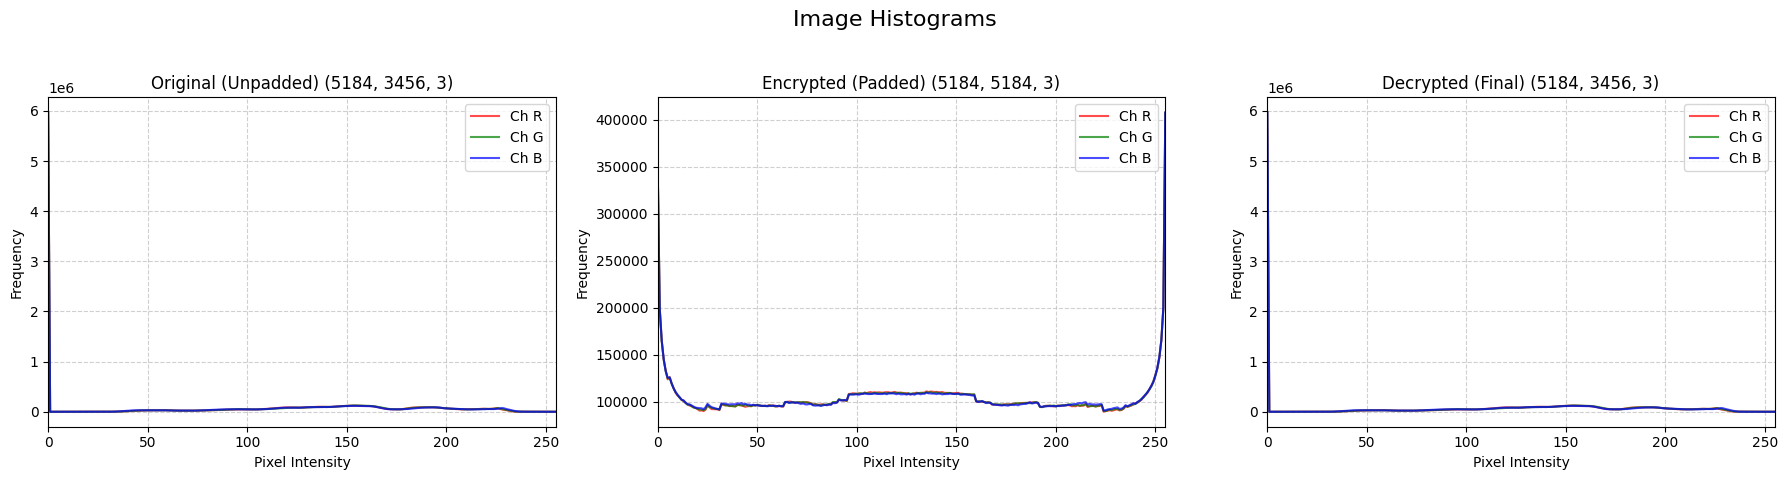

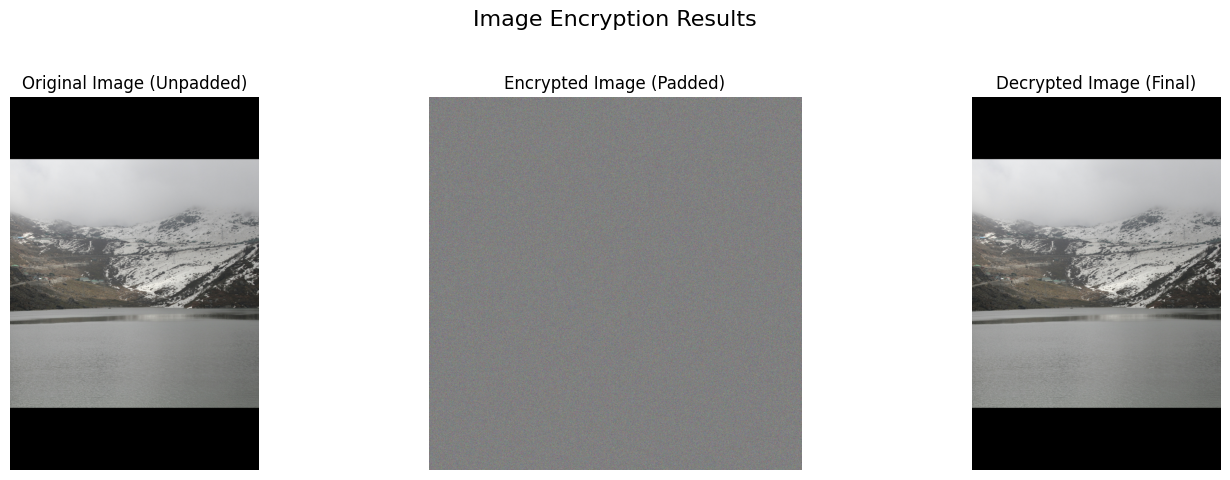


--- Key Sensitivity Test ---
Attempting decryption with slightly modified key (x0 = 0.31415936535)...
Starting Decryption Process (on decompressed data)...
Applying Logistic Map decryption (x0=0.31415936535, r=3.9999)...
Applying Inverse Arnold's Cat Map with 10 iterations (a=1, b=1)...
Removing padding to restore original size (5184, 3456)...
Final decrypted size after unpadding: (5184, 3456)
Decryption completed in 43.7289 seconds.
Resulting PSNR (Wrong Key): 7.0989 dB
Resulting SSIM (Wrong Key): 0.0070
Key sensitivity test PASSED: Decryption with slightly wrong key produced significantly different result.

--- Task 8: Saving and Downloading Output ---
Compressed encrypted data saved as: encrypted_compressed_data.zlib
Final decrypted image saved as: decrypted_image.png
Initiating Colab downloads (if files were saved)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Image Processing Script Execution Finished ---


In [ ]:
# %% [markdown]
# # Secure and Efficient Image Encryption with Compression and Upload/Download
#
# This notebook implements an image encryption scheme (Arnold's Cat Map + Logistic Map)
# with **lossless compression (zlib)** applied after encryption and decompression
# before decryption. It includes options to upload the source image and download the
# compressed encrypted data and final decrypted results.
#
# **Features:**
# - Upload an image file.
# - Encrypts the original (pre-compression) image using ACM + Logistic Map.
# - **Compresses** the encrypted image data using zlib.
# - **Verifies integrity** by hashing the **compressed encrypted data** using SHA-256.
# - Performs performance and security analysis.
# - Provides download links for the **compressed encrypted data** and the final decrypted image.
#
# **Correct Workflow:**
# 1. Upload Image -> Preprocess (Pad if needed) -> `original_image_padded`
# 2. Encrypt (`original_image_padded` with ACM + Logistic Map) -> `encrypted_image`
# 3. **Compress** `encrypted_image` (zlib) -> `compressed_encrypted_data`
# 4. **Calculate Hash** of `compressed_encrypted_data` -> `transmitted_hash`
# 5. (Simulate Reception)
# 6. **Verify Hash** of received compressed data against `transmitted_hash`. If mismatch, stop.
# 7. **Decompress** received data (zlib) -> `decompressed_encrypted_image` (Requires shape/dtype)
# 8. Decrypt `decompressed_encrypted_image` (Inverse Logistic + Inverse ACM)
# 9. Remove Padding -> `final_decrypted_image`
# 10. Analyze & Compare `final_decrypted_image` with original (unpadded).
#
# **Environment Notes:**
# - Uses `google.colab.files` for Colab upload/download.
# - Jupyter environments use `ipywidgets` and data URI links.

# %%
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import time
import math
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
import hashlib
import warnings
import os # For path manipulation if needed
import base64 # For potential data URI download links
import zlib # <--- Added for compression
import traceback # <--- Added for detailed error reporting

# --- Environment Specific Imports ---
try:
    from google.colab import files
    ENV = 'colab'
except ImportError:
    print("Not running in Google Colab. File upload/download will require manual steps or alternative libraries (like ipywidgets).")
    # Try importing tools for Jupyter download links
    try:
        from IPython.display import display, HTML
        import ipywidgets as widgets # Import for potential widget-based upload in Jupyter
        ENV = 'jupyter'
    except ImportError:
        print("IPython/ipywidgets not available. Download links may not be generated automatically.")
        ENV = 'other'


# Ignore specific warnings from skimage and PIL
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')
warnings.filterwarnings("ignore", category=UserWarning, module='PIL')
warnings.filterwarnings("ignore", category=FutureWarning, module='skimage')


# %% [markdown]
# ## Task 1: Image Preprocessing (Adapted for Uploaded Data)

# %%
def preprocess_image(img_input, target_size=None, grayscale=False, simulate_low_bandwidth=False, low_bw_size=(128, 128)):
    """Loads image from various inputs, converts, optionally resizes and pads."""
    try:
        if isinstance(img_input, (BytesIO, bytes)):
            # If input is bytes, wrap it in BytesIO
            if isinstance(img_input, bytes):
                img_input = BytesIO(img_input)
            img_input.seek(0) # Ensure reading from the start for BytesIO
            img = Image.open(img_input)
            print("Loaded image from uploaded data.")
        elif isinstance(img_input, str): # Keep URL/Path option as fallback
            # Basic check for URL (could be more robust)
            if img_input.startswith('http://') or img_input.startswith('https://'):
                 # If you need URL loading again, uncomment the next lines and import requests
                 # import requests
                 # response = requests.get(img_input)
                 # response.raise_for_status()
                 # img = Image.open(BytesIO(response.content))
                 # print(f"Loaded image from URL: {img_input}")
                 raise NotImplementedError("URL loading currently disabled. Upload file or use local path.")
            else:
                 img = Image.open(img_input)
                 print(f"Loaded image from Path: {img_input}")
        elif isinstance(img_input, Image.Image):
            img = img_input
            print("Processing provided PIL image object.")
        elif img_input is None: # Handle case where no input was provided (e.g., upload failed)
             raise ValueError("No valid image input provided.")
        else:
             raise ValueError(f"Unsupported input type for preprocess_image: {type(img_input)}")

    except FileNotFoundError:
        print(f"Error: File not found at path '{img_input}'.")
        print("Using a fallback procedural image.")
        img_array = np.zeros((256, 256, 3), dtype=np.uint8)
        img_array[:, :, 0] = np.linspace(0, 255, 256) # Red gradient
        img_array[:, :, 1] = np.linspace(0, 255, 256).T # Green gradient
        img_array[:, :, 2] = 128 # Blue constant
        img = Image.fromarray(img_array)
    except Exception as e:
        print(f"Error loading image: {e}")
        # Fallback to a default procedural image if loading fails
        print("Using a fallback procedural image.")
        img_array = np.zeros((256, 256, 3), dtype=np.uint8)
        img_array[:, :, 0] = np.linspace(0, 255, 256) # Red gradient
        img_array[:, :, 1] = np.linspace(0, 255, 256).T # Green gradient
        img_array[:, :, 2] = 128 # Blue constant
        img = Image.fromarray(img_array)


    original_mode = img.mode
    original_size_before_processing = img.size
    print(f"Original image mode: {original_mode}, size: {original_size_before_processing}")

    if grayscale and img.mode != 'L':
        img = img.convert('L')
        print(f"Converted to grayscale. New mode: {img.mode}")
    elif not grayscale and img.mode not in ['RGB', 'RGBA']:
         print(f"Converting mode {img.mode} to RGB for consistency.")
         img = img.convert('RGB')

    if img.mode == 'RGBA':
        print("Converting RGBA to RGB by blending onto a white background.")
        # Create a white background image
        bg = Image.new("RGB", img.size, (255, 255, 255))
        # Paste the RGBA image onto the white background using the alpha channel as mask
        try:
            # This assumes the alpha channel is the 4th channel
            bg.paste(img, mask=img.split()[3])
        except IndexError:
             print("Warning: Could not get alpha channel for RGBA conversion. Using image directly.")
             bg.paste(img) # Paste without mask if alpha split fails
        img = bg # Use the blended image

    # Dynamic resizing
    if simulate_low_bandwidth:
        print(f"Simulating low bandwidth. Resizing image to {low_bw_size}...")
        img = img.resize(low_bw_size, Image.Resampling.LANCZOS)
        print(f"Resized image size: {img.size}")
    elif target_size:
        # Ensure target_size is a tuple (width, height)
        if isinstance(target_size, (list, tuple)) and len(target_size) == 2:
            print(f"Resizing image to {target_size}...")
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            print(f"Resized image size: {img.size}")
        else:
            print(f"Warning: Invalid target_size {target_size}. Skipping resize.")


    img_array = np.array(img, dtype=np.uint8)

    # Padding to square shape (required for ACM)
    h, w = img_array.shape[:2]
    padded = False
    if h != w:
        padded = True
        print(f"Image is not square ({h}x{w}). Padding to make it square.")
        max_dim = max(h, w)
        pad_h = max_dim - h
        pad_w = max_dim - w
        # Calculate padding amounts for top, bottom, left, right
        # np.pad format: ((before_axis1, after_axis1), (before_axis2, after_axis2), ...)
        if img_array.ndim == 3: # Color image
            # ((top, bottom), (left, right), (channel_pad_before, channel_pad_after))
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2), (0, 0))
        else: # Grayscale image
            # ((top, bottom), (left, right))
            pad_width = ((pad_h // 2, pad_h - pad_h // 2), (pad_w // 2, pad_w - pad_w // 2))
        # Pad with constant value 0 (black)
        img_array = np.pad(img_array, pad_width, mode='constant', constant_values=0)
        print(f"Padded image size: {img_array.shape[:2]}")

    # Return the processed (potentially padded) array, the original size *before padding*, and the padding flag
    return img_array, original_size_before_processing, padded


# %% [markdown]
# ## Task 2: Encryption (Core Logic - ACM + Logistic Map)

# %%
# --- Arnold's Cat Map ---
def arnold_cat_map(img_array, iterations, a=1, b=1):
    """Applies Arnold's Cat Map for pixel shuffling."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if img_array.shape[0] != img_array.shape[1]:
        raise ValueError("Arnold's Cat Map requires a square image. Please pad first.")

    rows, cols = img_array.shape[:2]
    is_color = img_array.ndim == 3

    # Create index grid
    x, y = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    # Flatten indices for transformation
    coords = np.stack([x.flatten(), y.flatten()], axis=1)

    # Apply ACM transformation iteratively
    for i in range(iterations):
        new_coords = np.zeros_like(coords)
        # ACM formula: x' = (x + b*y) mod N, y' = (a*x + (a*b+1)*y) mod N
        new_coords[:, 0] = (coords[:, 0] + b * coords[:, 1]) % rows
        new_coords[:, 1] = (a * coords[:, 0] + (a * b + 1) * coords[:, 1]) % cols
        coords = new_coords # Update coordinates for next iteration
        # Optional: Add progress printout for large images/iterations
        # if (i+1) % 5 == 0: print(f"  ACM Iteration {i+1}/{iterations}")


    # Create the shuffled image
    shuffled_img = np.zeros_like(img_array)
    orig_indices = (x.flatten(), y.flatten()) # Original flat indices
    new_indices = (coords[:, 0], coords[:, 1]) # New flat indices after shuffling

    # Map original pixel values to new shuffled locations
    if is_color:
        for c in range(img_array.shape[2]):
            shuffled_img[new_indices[0], new_indices[1], c] = img_array[orig_indices[0], orig_indices[1], c]
    else: # Grayscale
        shuffled_img[new_indices[0], new_indices[1]] = img_array[orig_indices[0], orig_indices[1]]

    # Reshape back to original image dimensions
    return shuffled_img.reshape(img_array.shape)

def inverse_arnold_cat_map(shuffled_img_array, iterations, a=1, b=1):
    """Applies the inverse of Arnold's Cat Map."""
    if shuffled_img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    if shuffled_img_array.shape[0] != shuffled_img_array.shape[1]:
        raise ValueError("Inverse Arnold's Cat Map requires a square image.")

    rows, cols = shuffled_img_array.shape[:2]
    is_color = shuffled_img_array.ndim == 3

    # Create index grid for the *shuffled* image
    x_shuffled, y_shuffled = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    coords_shuffled = np.stack([x_shuffled.flatten(), y_shuffled.flatten()], axis=1)

    # Apply inverse ACM transformation iteratively
    # Precompute matrix elements to avoid redundant calculations inside loop? Not necessary here.
    inv_coeff_00 = a * b + 1
    inv_coeff_01 = -b
    inv_coeff_10 = -a
    inv_coeff_11 = 1

    for i in range(iterations):
        coords_orig = np.zeros_like(coords_shuffled)
        # Inverse ACM formula: x = ((a*b+1)*x' - b*y') mod N, y = (-a*x' + y') mod N
        coords_orig[:, 0] = (inv_coeff_00 * coords_shuffled[:, 0] + inv_coeff_01 * coords_shuffled[:, 1]) % rows
        coords_orig[:, 1] = (inv_coeff_10 * coords_shuffled[:, 0] + inv_coeff_11 * coords_shuffled[:, 1]) % cols
        coords_shuffled = coords_orig # Update coordinates for next iteration
        # Optional: Add progress printout
        # if (i+1) % 5 == 0: print(f"  Inv ACM Iteration {i+1}/{iterations}")


    # Create the unshuffled image
    unshuffled_img = np.zeros_like(shuffled_img_array)
    shuffled_indices = (x_shuffled.flatten(), y_shuffled.flatten()) # Indices in the input shuffled image
    original_indices = (coords_shuffled[:, 0], coords_shuffled[:, 1]) # Calculated original indices

    # Map shuffled pixel values back to their original locations
    if is_color:
        for c in range(shuffled_img_array.shape[2]):
            unshuffled_img[original_indices[0], original_indices[1], c] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1], c]
    else: # Grayscale
        unshuffled_img[original_indices[0], original_indices[1]] = shuffled_img_array[shuffled_indices[0], shuffled_indices[1]]

    return unshuffled_img.reshape(shuffled_img_array.shape)

# --- Logistic Map Chaos Encryption ---
def generate_logistic_map_sequence(x0, r, size):
    """Generates a chaotic sequence using the Logistic Map."""
    # Ensure parameters are floats
    x0 = float(x0)
    r = float(r)
    sequence = np.zeros(size, dtype=np.float64) # Use float64 for better precision
    x = x0
    # Burn-in iterations to reach chaotic regime
    # print("Logistic Map: Burn-in...") # Optional print
    for _ in range(100): # Discard initial values
        x = r * x * (1.0 - x)
    # Generate the sequence
    # print("Logistic Map: Generating sequence...") # Optional print
    for i in range(size):
        x = r * x * (1.0 - x)
        sequence[i] = x
        # Handle potential precision issues leading to exact 0 or 1 (unlikely with float64 but safe)
        if x == 0.0 or x == 1.0:
            # print(f"Warning: Logistic map sequence hit {x} at iteration {i}. Re-seeding slightly.")
            # Adding a tiny value might push it out of fixed point, but could introduce bias
            # x = np.fmod(x + 1e-9, 1.0) # Add small perturbation and wrap around using fmod
            # A potentially safer approach is to slightly perturb r or x0 if this happens often
            # For now, just continue, it's rare with proper parameters
            pass

    return sequence

def logistic_map_encrypt_decrypt(img_array, x0, r):
    """Encrypts or decrypts using Logistic Map sequence via XOR."""
    if img_array.ndim not in [2, 3]:
        raise ValueError("Input must be a 2D (grayscale) or 3D (color) image array.")
    img_dtype = img_array.dtype
    if img_dtype != np.uint8:
        print(f"Warning: Input image array dtype is {img_dtype}. Converting to uint8 for XOR.")
        img_array = img_array.astype(np.uint8)

    is_color = img_array.ndim == 3
    total_pixels = img_array.size # Total number of elements (pixels * channels)

    # Parameter checks for logistic map
    if not (3.57 <= r <= 4.0):
        print(f"Warning: Logistic map parameter r={r} might not be in the typical chaotic range [3.57, 4.0]. Results may be insecure.")
    if not (0 < x0 < 1):
         print(f"Warning: Logistic map initial value x0={x0} should be between 0 and 1. Clipping to avoid issues.")
         # Clip x0 slightly away from 0 and 1
         x0 = np.clip(x0, 1e-6, 1.0 - 1e-6)

    try:
        # Generate keystream (float values between 0 and 1)
        keystream_float = generate_logistic_map_sequence(x0, r, total_pixels)
        # Scale to 0-255 and convert to uint8 for XOR
        # Scaling by 255.999... maps (0, 1) to [0, 255] after casting
        keystream_uint8 = (keystream_float * 255.999999).astype(np.uint8)
    except OverflowError:
        print(f"FATAL: OverflowError during logistic map generation with r={r}, x0={x0}. This usually indicates unstable parameters. Stopping.")
        # Using fallback random stream here masks instability, better to raise error
        raise ValueError(f"Logistic map overflowed with r={r}, x0={x0}.")
        # keystream_uint8 = np.random.randint(0, 256, size=total_pixels, dtype=np.uint8)

    # Flatten image and keystream for XOR operation
    # Ensure keystream matches the flattened image length precisely
    keystream_reshaped = keystream_uint8 # Already flat
    img_flat = img_array.flatten()

    if len(img_flat) != len(keystream_reshaped):
         raise ValueError(f"Image flat size ({len(img_flat)}) and keystream size ({len(keystream_reshaped)}) mismatch.")

    # Perform XOR operation element-wise
    processed_flat = np.bitwise_xor(img_flat, keystream_reshaped)

    # Reshape back to original image shape
    processed_img = processed_flat.reshape(img_array.shape)
    # Ensure output is uint8
    return processed_img.astype(np.uint8)

# --- Combined Encryption Function ---
def encrypt_image(img_array, acm_iterations, logistic_x0, logistic_r, acm_a=1, acm_b=1):
    """Combines ACM shuffling and Logistic Map encryption on pixel data."""
    print("Starting Encryption Process...")
    start_time = time.time()
    # 1. Shuffle pixels with Arnold's Cat Map
    print(f"Applying Arnold's Cat Map with {acm_iterations} iterations (a={acm_a}, b={acm_b})...")
    try:
        # Ensure input is uint8 before shuffling if needed (though ACM itself doesn't require it)
        if img_array.dtype != np.uint8:
            print(f"  Converting image to uint8 before ACM.")
            img_array = img_array.astype(np.uint8)
        shuffled_img = arnold_cat_map(img_array, acm_iterations, acm_a, acm_b)
    except ValueError as e:
        print(f"Error during ACM: {e}. Returning original image.")
        return img_array, 0 # Return original and 0 time

    # 2. Encrypt pixel values with Logistic Map XOR
    print(f"Applying Logistic Map encryption (x0={logistic_x0}, r={logistic_r})...")
    try:
        encrypted_img = logistic_map_encrypt_decrypt(shuffled_img, logistic_x0, logistic_r)
    except ValueError as e:
        print(f"Error during Logistic Map encryption: {e}. Returning shuffled image.")
        return shuffled_img, time.time() - start_time # Return intermediate and partial time

    end_time = time.time()
    encryption_time = end_time - start_time
    print(f"Encryption completed in {encryption_time:.4f} seconds.")
    return encrypted_img, encryption_time


# %% [markdown]
# ## Task 3: Compression (zlib) and Hashing of Compressed Data

# %%
def compress_data(data_array):
    """Compresses a NumPy array using zlib."""
    print("Starting Compression...")
    start_time = time.time()
    # Ensure data is in bytes format
    try:
        original_bytes = data_array.tobytes()
    except AttributeError:
         print("Error: Input data_array does not support .tobytes(). Is it a NumPy array?")
         return None, 0

    # Use a good compression level (1-9, 9 is highest, 6 is default)
    compression_level = 7 # Good balance
    compressed_bytes = zlib.compress(original_bytes, level=compression_level)
    end_time = time.time()
    compression_time = end_time - start_time

    original_size = len(original_bytes)
    compressed_size = len(compressed_bytes)
    ratio = compressed_size / original_size if original_size > 0 else 0
    print(f"Compression (zlib level {compression_level}) completed in {compression_time:.4f} seconds.")
    print(f"Original size: {original_size} bytes, Compressed size: {compressed_size} bytes, Ratio: {ratio:.4f}")
    return compressed_bytes, compression_time

def calculate_hash_bytes(byte_data):
    """Calculates the SHA-256 hash of byte data."""
    if not isinstance(byte_data, bytes):
        raise TypeError("Input for hashing must be bytes.")
    hasher = hashlib.sha256()
    hasher.update(byte_data)
    return hasher.hexdigest()


# %% [markdown]
# ## Task 4: Decompression (zlib), Decryption & Integrity Verification

# %%
def decompress_data(compressed_bytes, original_shape, original_dtype):
    """Decompresses byte data (from zlib) back into a NumPy array."""
    print("Starting Decompression...")
    start_time = time.time()
    if not isinstance(compressed_bytes, bytes):
         print("Error: Input for decompression must be bytes.")
         return None, 0

    try:
        decompressed_bytes = zlib.decompress(compressed_bytes)

        # --- Verification Step ---
        # Calculate expected size in bytes from shape and dtype
        try:
             dtype_itemsize = np.dtype(original_dtype).itemsize
             expected_bytes = np.prod(original_shape) * dtype_itemsize
        except TypeError as e:
             print(f"Error calculating expected size: Invalid shape {original_shape} or dtype {original_dtype}? {e}")
             # Cannot reliably reshape if expected size is unknown
             raise ValueError("Cannot determine expected size from shape/dtype.")


        if len(decompressed_bytes) != expected_bytes:
             print(f"FATAL: Decompressed byte count ({len(decompressed_bytes)}) does not match expected count ({expected_bytes}) based on provided shape {original_shape} and dtype {original_dtype}.")
             print("This indicates data corruption, incorrect shape/dtype passed, or compression issues.")
             # Return None as reshaping will fail or produce incorrect data
             return None, time.time() - start_time # Return None and time taken so far

        # --- Reshape Step ---
        # Convert bytes back to NumPy array using the known dtype
        data_array = np.frombuffer(decompressed_bytes, dtype=original_dtype)
        # Reshape to the original array dimensions
        data_array = data_array.reshape(original_shape)

        end_time = time.time()
        decompression_time = end_time - start_time
        print(f"Decompression completed in {decompression_time:.4f} seconds.")
        return data_array, decompression_time

    except zlib.error as e:
        print(f"Error during zlib decompression: {e}. Data may be corrupted.")
        return None, time.time() - start_time
    except ValueError as e:
        # This might catch the reshape error if the byte count check above was bypassed
        print(f"Error reshaping decompressed data (likely size mismatch or shape/dtype error): {e}")
        return None, time.time() - start_time
    except Exception as e:
        print(f"An unexpected error occurred during decompression: {e}")
        traceback.print_exc() # Print full traceback for unexpected errors
        return None, time.time() - start_time


def decrypt_image(encrypted_img_array, acm_iterations, logistic_x0, logistic_r, original_shape_before_padding, padded, acm_a=1, acm_b=1):
    """Reverses the encryption: Logistic Map decrypt -> Inverse ACM -> Unpad."""
    # Input `encrypted_img_array` here is the *decompressed* encrypted image.
    if encrypted_img_array is None:
         print("Error: Cannot decrypt None input.")
         return None, 0

    print("Starting Decryption Process (on decompressed data)...")
    start_time = time.time()

    # 1. Decrypt pixel values using Logistic Map (XOR is its own inverse)
    print(f"Applying Logistic Map decryption (x0={logistic_x0}, r={logistic_r})...")
    try:
        decrypted_shuffled_img = logistic_map_encrypt_decrypt(encrypted_img_array, logistic_x0, logistic_r)
    except ValueError as e:
         print(f"Error during Logistic Map decryption: {e}. Returning None.")
         return None, time.time() - start_time

    # 2. Unshuffle pixels using Inverse Arnold's Cat Map
    print(f"Applying Inverse Arnold's Cat Map with {acm_iterations} iterations (a={acm_a}, b={acm_b})...")
    try:
        unshuffled_padded_img = inverse_arnold_cat_map(decrypted_shuffled_img, acm_iterations, acm_a, acm_b)
    except ValueError as e:
         print(f"Error during Inverse ACM: {e}. Cannot unpad. Returning partially decrypted (shuffled) image.")
         # We can't reliably unpad if the inverse shuffling failed
         return decrypted_shuffled_img, time.time() - start_time

    # 3. Remove padding if it was added during preprocessing
    final_decrypted_img = unshuffled_padded_img # Assume no padding needed initially
    if padded: # Check the flag passed from preprocessing
        current_h, current_w = unshuffled_padded_img.shape[:2]
        orig_h, orig_w = original_shape_before_padding # Use the original size before padding

        # Basic sanity check on dimensions before slicing
        if orig_h > current_h or orig_w > current_w:
             print(f"Error: Original dimensions ({orig_h}x{orig_w}) seem larger than current image dimensions ({current_h}x{current_w}) after inverse ACM. Cannot unpad.")
             # Return the unshuffled padded image as best result possible
             return unshuffled_padded_img, time.time() - start_time

        # Sanity check: Did padding actually change dimensions?
        if current_h != orig_h or current_w != orig_w:
            print(f"Removing padding to restore original size {original_shape_before_padding}...")
            # Calculate how much padding was added (total)
            pad_h_total = current_h - orig_h
            pad_w_total = current_w - orig_w
            # Calculate padding on each side (assuming symmetric padding was used)
            pad_top = pad_h_total // 2
            pad_left = pad_w_total // 2

            # Slice the array to remove padding
            try:
                if unshuffled_padded_img.ndim == 3: # Color
                    final_decrypted_img = unshuffled_padded_img[pad_top : pad_top + orig_h, pad_left : pad_left + orig_w, :]
                else: # Grayscale
                    final_decrypted_img = unshuffled_padded_img[pad_top : pad_top + orig_h, pad_left : pad_left + orig_w]
                print(f"Final decrypted size after unpadding: {final_decrypted_img.shape[:2]}")
            except IndexError as e:
                 print(f"Error during unpadding slice (calculated indices might be wrong): {e}")
                 print(f"  current={current_h}x{current_w}, orig={orig_h}x{orig_w}, top={pad_top}, left={pad_left}")
                 # Return the unshuffled padded image as best result possible
                 return unshuffled_padded_img, time.time() - start_time
        else:
            # This case implies padding flag was true, but dimensions didn't change. Maybe original was already square?
             print("Padding flag was set, but dimensions seem to match the original size. No padding removed.")
             final_decrypted_img = unshuffled_padded_img # Keep the image as is
    else:
        print("No padding was added initially, skipping unpadding step.")

    end_time = time.time()
    decryption_time = end_time - start_time
    print(f"Decryption completed in {decryption_time:.4f} seconds.")
    # Ensure output is uint8, especially important after potential float operations in analysis tools later
    return final_decrypted_img.astype(np.uint8), decryption_time

def verify_integrity_compressed(received_compressed_data, original_compressed_hash):
    """Compares the hash of the received compressed data with the original expected hash."""
    print(f"\n--- Tamper Verification (Compressed Data) ---")
    if not isinstance(received_compressed_data, bytes):
        print("Error: Received data for hash verification is not bytes.")
        return False
    if not isinstance(original_compressed_hash, str) or len(original_compressed_hash) != 64:
        print("Error: Original hash for comparison is invalid.")
        return False

    print(f"Expected Hash:  {original_compressed_hash}")
    # Calculate hash of the received compressed data
    try:
        calculated_hash = calculate_hash_bytes(received_compressed_data)
        print(f"Calculated Hash:{calculated_hash}")
    except Exception as e:
        print(f"Error calculating hash of received data: {e}")
        return False

    if original_compressed_hash == calculated_hash:
        print("Integrity Check PASSED: Compressed data hashes match.")
        return True
    else:
        print("Integrity Check FAILED: Compressed data hashes DO NOT match. Data may be corrupted or tampered with.")
        return False


# %% [markdown]
# ## Task 5: Performance Analysis (Functions - Mostly Unchanged)

# %%
def calculate_metrics(img_orig, img_processed, data_range=255):
    """Calculates MSE, PSNR, SSIM, and Entropy."""
    # Ensure inputs are NumPy arrays
    if not isinstance(img_orig, np.ndarray) or not isinstance(img_processed, np.ndarray):
        print("Error: Inputs for metrics must be NumPy arrays.")
        # Return default/error values
        entropy_orig = shannon_entropy(img_orig) if isinstance(img_orig, np.ndarray) else float('nan')
        return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': entropy_orig, 'entropy_proc': float('nan')}

    # Ensure images are uint8 for standard metrics
    # Check dtype *before* astype to avoid unnecessary conversions/warnings
    if img_orig.dtype != np.uint8:
         # print(f"Converting original image from {img_orig.dtype} to uint8 for metrics.")
         img_orig = img_orig.astype(np.uint8)
    if img_processed.dtype != np.uint8:
         # print(f"Converting processed image from {img_processed.dtype} to uint8 for metrics.")
         img_processed = img_processed.astype(np.uint8)


    if img_orig.shape != img_processed.shape:
        print(f"Warning: Original ({img_orig.shape}) and processed ({img_processed.shape}) images have different shapes for metrics calculation.")
        print("This often happens if decryption/unpadding failed.")
        print("Metrics calculation skipped due to shape mismatch.")
        return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': shannon_entropy(img_orig), 'entropy_proc': float('nan')}

    # --- Calculate Metrics ---
    try:
        mse_val = mse(img_orig, img_processed)
    except Exception as e:
        print(f"Error calculating MSE: {e}")
        mse_val = float('inf')

    try:
        # PSNR calculation handles mse_val=0 correctly (returns inf)
        psnr_val = psnr(img_orig, img_processed, data_range=data_range)
    except Exception as e:
        print(f"Error calculating PSNR: {e}")
        psnr_val = 0 # Or float('-inf')? 0 is common for error.

    # SSIM calculation
    ssim_val = 0 # Default in case of error or small image
    try:
        multichannel = img_orig.ndim == 3
        min_dim = min(img_orig.shape[:2])
        # Default SSIM window size in skimage is min(7, N) where N is spatial dimension
        # Ensure window size is odd and >= 3
        win_size = min(7, min_dim)
        if win_size < 3:
             print(f"Image dimensions ({img_orig.shape[:2]}) too small for SSIM. Setting SSIM to 0.")
        elif win_size % 2 == 0:
             win_size -= 1 # Make odd

        if win_size >= 3:
             # Determine channel_axis based on multichannel flag AFTER checking dimensions
             c_axis = 2 if multichannel else None
             ssim_val = ssim(img_orig, img_processed, data_range=data_range,
                             multichannel=multichannel, channel_axis=c_axis,
                             win_size=win_size)
    except ValueError as e:
         # Catch potential errors like window size > image dimension
         print(f"Error calculating SSIM (check window size vs image dim): {e}. Setting SSIM to 0.")
         ssim_val = 0
    except Exception as e:
         print(f"Unexpected error calculating SSIM: {e}")
         ssim_val = 0


    # Entropy calculation
    try:
        entropy_orig_val = shannon_entropy(img_orig)
    except Exception as e:
        print(f"Error calculating original entropy: {e}")
        entropy_orig_val = float('nan')
    try:
        entropy_proc_val = shannon_entropy(img_processed)
    except Exception as e:
        print(f"Error calculating processed entropy: {e}")
        entropy_proc_val = float('nan')


    metrics = {
        'mse': mse_val,
        'psnr': psnr_val,
        'ssim': ssim_val,
        'entropy_orig': entropy_orig_val,
        'entropy_proc': entropy_proc_val
    }
    return metrics

def plot_histograms(img_orig, img_encrypted, img_decrypted):
    """Plots histograms for original, encrypted (padded), and decrypted images."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Image Histograms', fontsize=16)
    colors = ('r', 'g', 'b')
    labels = ('Original (Unpadded)', 'Encrypted (Padded)', 'Decrypted (Final)')
    images = (img_orig, img_encrypted, img_decrypted)

    for i, img in enumerate(images):
        ax = axes[i]
        if img is None or not isinstance(img, np.ndarray): # Check if image data is valid
            ax.set_title(f"{labels[i]} (Not Available)")
            ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='red')
            ax.set_xticks([])
            ax.set_yticks([])
            continue

        # Proceed with plotting if image is valid
        ax.set_title(labels[i] + f" {img.shape}") # Add shape to title
        ax.set_xlabel('Pixel Intensity'); ax.set_ylabel('Frequency')
        try:
            if img.ndim == 3: # Color image
                # Plot histogram for each color channel
                for c_idx, color in enumerate(colors):
                    if c_idx < img.shape[2]: # Check if channel exists (e.g., might be 2-channel?)
                        # Use np.histogram for robustness
                        hist, bin_edges = np.histogram(img[:, :, c_idx].ravel(), bins=256, range=[0, 256])
                        ax.plot(bin_edges[:-1], hist, color=color, alpha=0.7, label=f'Ch {color.upper()}')
                if img.shape[2] > 1 : ax.legend(loc='upper right') # Show legend only if multiple channels plotted
            elif img.ndim == 2: # Grayscale image
                hist, bin_edges = np.histogram(img.ravel(), bins=256, range=[0, 256])
                ax.plot(bin_edges[:-1], hist, color='black')
            else:
                 ax.text(0.5, 0.5, f'Invalid Dim {img.ndim}', ha='center', va='center', transform=ax.transAxes)


            ax.set_xlim([0, 255])
            ax.grid(True, linestyle='--', alpha=0.6)
        except Exception as e:
             print(f"Error plotting histogram for {labels[i]}: {e}")
             ax.text(0.5, 0.5, 'Plotting Error', ha='center', va='center', transform=ax.transAxes, color='red')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent title overlap
    plt.show()

def display_images(img_orig, img_encrypted, img_decrypted):
    """Displays the original (unpadded), encrypted (padded), and decrypted (final) images."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Image Encryption Results', fontsize=16)
    titles = ['Original Image (Unpadded)', 'Encrypted Image (Padded)', 'Decrypted Image (Final)']
    images = [img_orig, img_encrypted, img_decrypted]

    for ax, img, title in zip(axes, images, titles):
        ax.set_title(title)
        ax.axis('off') # Hide axes ticks
        if img is not None and isinstance(img, np.ndarray):
            # Determine colormap (grayscale or color)
            cmap = 'gray' if img.ndim == 2 else None
            try:
                ax.imshow(img, cmap=cmap)
            except Exception as e:
                 print(f"Error displaying image '{title}': {e}")
                 ax.text(0.5, 0.5, 'Display Error', ha='center', va='center', transform=ax.transAxes, color='red')

        else:
             # Display N/A if image is missing or invalid
             ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes, fontsize=12, color='red')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout
    plt.show()

# --- Helper for Jupyter Download Link ---
def create_download_link_jupyter(filename, data_bytes, link_text, mime_type='application/octet-stream'):
    """Generates an HTML download link for Jupyter using base64 encoded bytes."""
    if ENV != 'jupyter' or not isinstance(data_bytes, bytes):
        return "" # Only run in Jupyter env and only if data is bytes
    try:
        b64 = base64.b64encode(data_bytes).decode('ascii') # Use ascii for base64
        href = f'<a href="data:{mime_type};base64,{b64}" download="{os.path.basename(filename)}">{link_text}</a>'
        return href
    except Exception as e:
        print(f"Error creating download link for {filename}: {e}")
        return f"<span>Error creating link for {filename}</span>"


# %% [markdown]
# ## Main Execution Block (Upload, Process, Analyze, Download)

# %%
# --- Configuration ---
# Encryption Keys (!!! USE SECURE RANDOM KEYS IN PRACTICE !!!)
# Using fixed keys for reproducibility in demo
ACM_ITERATIONS = 10 # Lowered slightly for potentially large images
ACM_A = 1; ACM_B = 1 # Standard ACM parameters
LOGISTIC_X0 = 0.31415926535 # Initial condition for logistic map (use high precision)
LOGISTIC_R = 3.9999          # Parameter for logistic map (very close to 4, highly chaotic)

# Preprocessing settings
USE_GRAYSCALE = False             # Convert to grayscale before processing?
SIMULATE_LOW_BANDWIDTH = False    # Resize image to simulate low bandwidth?
RESIZE_TARGET = None #(512, 512)  # Target size if resizing (e.g., (256, 256)). None means no resize.

# Output filenames
# NOTE: Encrypted file now stores compressed raw data, suggest non-image extension
COMPRESSED_ENCRYPTED_FILENAME = "encrypted_compressed_data.zlib" # Changed extension
DECRYPTED_FILENAME = "decrypted_image.png" # Keep as PNG

# --- Global variables to store results across steps (initialize) ---
original_image_unpadded = None
original_image_padded = None
encrypted_image = None
compressed_encrypted_data = None
transmitted_hash = None
decompressed_encrypted_image = None
final_decrypted_image = None
integrity_check_passed = False # Assume failure until success
encryption_time = 0
compression_time = 0
decompression_time = 0
decryption_time = 0
original_size_before_padding = (0,0)
was_padded = False
encrypted_shape = None
encrypted_dtype = None


# --- Get Image Input ---
uploaded_file_name = None
img_data_input = None # This will hold the image data (BytesIO, path, etc.)

print("--- Starting Setup ---") # Added print

if ENV == 'colab':
    print("Environment: Google Colab")
    print("Please upload an image file:")
    try:
        uploaded = files.upload()
        if uploaded:
            # Get the first uploaded file's name and content
            uploaded_file_name = next(iter(uploaded))
            img_data_input = uploaded[uploaded_file_name] # Pass raw bytes to preprocessing
            print(f"Successfully uploaded: {uploaded_file_name} ({len(img_data_input)} bytes)")
        else:
            print("No file uploaded. Will use fallback image.")
            img_data_input = None # Let preprocessing handle fallback
    except Exception as e:
        print(f"An error occurred during Colab upload: {e}")
        img_data_input = None # Let preprocessing handle fallback

elif ENV == 'jupyter':
     print("Environment: Jupyter Notebook/Lab")
     print("Please use the widget below to upload an image file:")
     # Define the uploader widget
     uploader = widgets.FileUpload(
         accept='image/*', # Allow common image types
         multiple=False, # Allow only single file upload
         description="Upload Image" # Add description
     )
     display(uploader) # Show the widget
     # IMPORTANT FOR JUPYTER:
     # 1. Run this cell.
     # 2. Use the widget that appears above to upload your file.
     # 3. Manually run the NEXT cell (Processing & Analysis) after upload completes.
     # We store the uploader object ('uploader') to retrieve the value in the next cell.

     # Optional: Provide a hardcoded path as a fallback if widget isn't used
     # file_path = "lena_color.png" # Example path
     # if 'uploader' not in locals() or not uploader.value: # Check if widget was used
     #      if os.path.exists(file_path):
     #           img_data_input = file_path
     #           uploaded_file_name = os.path.basename(file_path)
     #           print(f"Using hardcoded file path: {file_path}")
     #      else:
     #           print(f"Hardcoded file path not found: {file_path}. Please use upload widget or provide valid path.")
     #           img_data_input = None # Ensure it's None if file not found

else: # 'other' environment (e.g., standard Python script)
    print("Environment: Other (e.g., script)")
    # Fallback: Specify a local file path directly
    # !!! USER ACTION REQUIRED: Change this path to your image file !!!
    try:
        # Default path, user should change this
        file_path = "input_image.png" # <--- CHANGE THIS PATH IF NEEDED
        # Check if file exists before proceeding
        if os.path.exists(file_path):
            img_data_input = file_path # Pass the path string to preprocessing
            uploaded_file_name = os.path.basename(file_path)
            print(f"Using local file: {file_path}")
        else:
             print(f"File not found at specified path: {file_path}.")
             print("Will use fallback image.")
             img_data_input = None # Let preprocessing handle fallback
    except Exception as e:
        print(f"Error accessing local file path '{file_path}': {e}")
        img_data_input = None # Let preprocessing handle fallback


# %% [markdown]
# ## Processing & Analysis (Run this cell after upload completes)

# %%
# --- Continue Execution (Run this cell after uploading in Jupyter) ---

# Handle Jupyter upload widget result if applicable
if ENV == 'jupyter' and 'uploader' in locals() and uploader.value:
    try:
        # uploader.value is a dictionary where keys are filenames and values are file info dicts
        uploaded_file_key = list(uploader.value.keys())[0] # Get the first filename key
        uploaded_file_info = uploader.value[uploaded_file_key] # Get the file info dict

        uploaded_file_name = uploaded_file_info['metadata']['name']
        # Pass the raw content (bytes) directly to preprocessing
        img_data_input = uploaded_file_info['content']
        print(f"Processing uploaded file (Jupyter): {uploaded_file_name} ({len(img_data_input)} bytes)")
        # Optional: Clear the widget value if you want to allow re-runs with new uploads easily
        # uploader.value.clear()
        # uploader._counter = 0 # Reset counter to allow re-upload of same file name
    except Exception as e:
        print(f"Error processing Jupyter upload: {e}")
        # Ensure img_data_input is None if processing fails, allowing fallback
        img_data_input = None


# --- Main Processing Pipeline ---
# Wrap the entire pipeline in a try/except/finally block for robust error handling

print("\n--- Starting Image Processing Pipeline ---")
# Make sure traceback is imported if an error occurs
# import traceback # Already imported earlier

# <<<< ****** START OF THE MAIN TRY BLOCK ****** >>>>
try:
    # --- Step 1: Preprocessing ---
    print("\n--- Task 1: Preprocessing ---")
    # Returns the potentially padded square array, the original size (h, w) before padding, and a flag
    original_image_padded, original_size_before_padding, was_padded = preprocess_image(
        img_data_input, # Can be BytesIO, path string, bytes, or None
        target_size=RESIZE_TARGET,
        grayscale=USE_GRAYSCALE,
        simulate_low_bandwidth=SIMULATE_LOW_BANDWIDTH
    )

    if original_image_padded is None:
        raise ValueError("Preprocessing failed to produce an image array.")

    # Store the original unpadded image for final comparison/metrics
    # Reconstruct it *before* encryption affects the padded version
    h_orig, w_orig = original_size_before_padding
    if was_padded:
        # Calculate padding amounts used during preprocess_image
        pad_h_total = original_image_padded.shape[0] - h_orig
        pad_w_total = original_image_padded.shape[1] - w_orig
        pad_top = pad_h_total // 2
        pad_left = pad_w_total // 2
        # Slice carefully
        if original_image_padded.ndim == 3:
            original_image_unpadded = original_image_padded[pad_top : pad_top + h_orig, pad_left : pad_left + w_orig, :].copy()
        else: # Grayscale
            original_image_unpadded = original_image_padded[pad_top : pad_top + h_orig, pad_left : pad_left + w_orig].copy()
    else:
        # If not padded, the 'padded' array is the original (or resized) one
        original_image_unpadded = original_image_padded.copy()

    print(f"Original image dimensions stored for metrics: {original_image_unpadded.shape}")
    print(f"Image array type after preprocessing: {original_image_padded.dtype}")


    # --- Step 2: Encryption ---
    print("\n--- Task 2: Encryption ---")
    # Encrypt the potentially padded image array
    encrypted_image, encryption_time = encrypt_image(
        original_image_padded, # Use the square, padded array for ACM
        acm_iterations=ACM_ITERATIONS,
        logistic_x0=LOGISTIC_X0, logistic_r=LOGISTIC_R,
        acm_a=ACM_A, acm_b=ACM_B
    )
    if encrypted_image is None:
        raise ValueError("Encryption failed.")
    # Store shape and dtype needed for decompression later
    encrypted_shape = encrypted_image.shape
    encrypted_dtype = encrypted_image.dtype
    print(f"Encrypted image shape: {encrypted_shape}, dtype: {encrypted_dtype}")


    # --- Step 3: Compression ---
    print("\n--- Task 3: Compression (zlib) ---")
    # Compress the encrypted image array
    compressed_encrypted_data, compression_time = compress_data(encrypted_image)
    if compressed_encrypted_data is None:
        raise ValueError("Compression failed.")


    # --- Step 4: Hashing (for Tamper Proofing) ---
    print("\n--- Task 4: Hashing Compressed Data ---")
    # Calculate hash of the compressed data (this is what we'd "transmit")
    transmitted_hash = calculate_hash_bytes(compressed_encrypted_data)
    print(f"Calculated SHA-256 Hash of Compressed Data: {transmitted_hash}")


    # --- (Simulate Reception & Tamper Check) ---
    # In a real scenario, 'received_compressed_data' would come from network/disk
    # For this single-cell demo, we just use the variable we have.
    received_compressed_data = compressed_encrypted_data
    received_hash = transmitted_hash # Assume the hash is received correctly alongside

    # Verify integrity of the compressed data *before* decompression
    integrity_check_passed = verify_integrity_compressed(received_compressed_data, received_hash)


    # --- Step 5: Decompression (if integrity check passed) ---
    if integrity_check_passed:
        print("\n--- Task 5: Decompression (zlib) ---")
        # Decompress the data, needs the original shape and dtype of the *encrypted* array
        decompressed_encrypted_image, decompression_time = decompress_data(
            received_compressed_data,
            encrypted_shape,
            encrypted_dtype
        )
        if decompressed_encrypted_image is None:
            print("Decompression failed. Cannot proceed with decryption.")
            # Mark overall process as failed if decompression fails
            integrity_check_passed = False
    else:
        print("\nSkipping Decompression and Decryption due to failed integrity check.")
        decompressed_encrypted_image = None


    # --- Step 6: Decryption (if decompression was successful) ---
    # Also check integrity_check_passed again, in case decompression failed
    if integrity_check_passed and decompressed_encrypted_image is not None:
        print("\n--- Task 6: Decryption ---")
        # Decrypt the decompressed image array
        # Pass original size and padding flag for correct unpadding
        final_decrypted_image, decryption_time = decrypt_image(
            decompressed_encrypted_image,
            acm_iterations=ACM_ITERATIONS,
            logistic_x0=LOGISTIC_X0, logistic_r=LOGISTIC_R,
            original_shape_before_padding=original_size_before_padding, # Original H, W tuple
            padded=was_padded, # Boolean flag
            acm_a=ACM_A, acm_b=ACM_B
        )
        if final_decrypted_image is None:
             print("Decryption process failed to produce final image.")
             # Mark overall success as false if final decryption step fails
             integrity_check_passed = False

    else:
        # Ensure final_decrypted_image is None if skipping or if previous steps failed
        print("\nSkipping Decryption.")
        final_decrypted_image = None


    # --- Step 7: Performance & Security Analysis ---
    print("\n--- Task 7: Performance & Security Analysis ---")
    print("\n--- Timing ---")
    print(f"Encryption Time:   {encryption_time:.4f}s")
    print(f"Compression Time:  {compression_time:.4f}s")
    print(f"Decompression Time:{decompression_time:.4f}s")
    print(f"Decryption Time:   {decryption_time:.4f}s")
    total_time = encryption_time + compression_time + decompression_time + decryption_time
    print(f"Total Time (Enc->Comp->Decomp->Dec): {total_time:.4f}s")
    if original_image_padded is not None:
         print(f"Image dimensions processed (padded): {original_image_padded.shape}")
    if original_image_unpadded is not None:
         print(f"Original unpadded dimensions: {original_image_unpadded.shape}")

    print("\n--- Similarity Metrics (Original Unpadded vs Final Decrypted) ---")
    # Check both integrity_check_passed AND if final_decrypted_image is valid
    if integrity_check_passed and final_decrypted_image is not None:
        # Compare the final result with the *original unpadded* image
        metrics_decrypted = calculate_metrics(original_image_unpadded, final_decrypted_image)
        print(f"MSE:  {metrics_decrypted.get('mse', 'N/A'):.4f}")
        # Handle potential infinity PSNR for perfect reconstruction
        psnr_val = metrics_decrypted.get('psnr', 0)
        psnr_str = f"{psnr_val:.4f} dB" if np.isfinite(psnr_val) else "inf (Perfect Reconstruction)"
        print(f"PSNR: {psnr_str}")
        print(f"SSIM: {metrics_decrypted.get('ssim', 'N/A'):.4f}")
        print(f"Entropy (Original):  {metrics_decrypted.get('entropy_orig', 'N/A'):.4f}")
        print(f"Entropy (Decrypted): {metrics_decrypted.get('entropy_proc', 'N/A'):.4f}")

        # Add a clearer success message based on metrics
        if metrics_decrypted.get('mse', 1) < 1e-6: # Check if MSE is near zero
             print("\nMetrics suggest Decryption SUCCESSFUL (Low MSE, High PSNR/SSIM).")
        else:
             print("\nWarning: Metrics indicate differences between original and decrypted images.")
    else:
        print("Skipping decrypted metrics calculation (Integrity check failed or decryption error).")
        # Calculate original entropy anyway if possible
        if original_image_unpadded is not None:
             try:
                  print(f"Entropy (Original):  {shannon_entropy(original_image_unpadded):.4f}")
             except Exception as e:
                  print(f"Could not calculate original entropy: {e}")


    print("\n--- Security Analysis (Original Unpadded vs Encrypted Padded) ---")
    # Compare original unpadded entropy vs encrypted (padded) entropy
    if original_image_unpadded is not None and encrypted_image is not None:
         try:
              entropy_original = shannon_entropy(original_image_unpadded)
              entropy_encrypted = shannon_entropy(encrypted_image) # Analyze the encrypted image before compression
              print(f"Entropy (Original Unpadded): {entropy_original:.4f}")
              print(f"Entropy (Encrypted Padded):  {entropy_encrypted:.4f}")
              # Check if entropy increased significantly and approaches max (8 for uint8)
              ideal_entropy = 8.0 * (np.log2(256) / 8.0) # Ideal entropy for uint8 is 8.0
              entropy_diff = entropy_encrypted - entropy_original
              if entropy_diff > 0.5 and abs(entropy_encrypted - ideal_entropy) < 0.5:
                  print("Entropy increased significantly towards ideal random distribution (Good).")
              elif entropy_diff > 0.1:
                  print("Entropy increased after encryption (Okay).")
              else:
                  print("Warning: Entropy did not increase significantly after encryption. Encryption might be weak or ineffective.")
         except Exception as e:
              print(f"Could not perform entropy analysis: {e}")
    else:
         print("Cannot perform entropy comparison (missing original or encrypted image).")


    print("\n--- Histograms & Image Display ---")
    # Display original (unpadded), encrypted (padded), decrypted (final unpadded)
    # Pass None carefully if steps failed
    plot_histograms(original_image_unpadded,
                    encrypted_image,
                    final_decrypted_image if integrity_check_passed else None)
    display_images(original_image_unpadded,
                   encrypted_image,
                   final_decrypted_image if integrity_check_passed else None)


    # --- Key Sensitivity Test (Example) ---
    print("\n--- Key Sensitivity Test ---")
    # Rerun decryption with a slightly wrong key
    # Requires the correctly decompressed data from Step 5
    if integrity_check_passed and decompressed_encrypted_image is not None:
        # Introduce a tiny change to one key parameter
        # Ensure the change is significant enough given float precision
        wrong_logistic_x0 = LOGISTIC_X0 + 1e-7 # Minimal change
        print(f"Attempting decryption with slightly modified key (x0 = {wrong_logistic_x0})...")

        # Perform only the decryption step with the wrong key
        decrypted_wrong_key, _ = decrypt_image(
            decompressed_encrypted_image, # Use the correctly decompressed data
            ACM_ITERATIONS,
            wrong_logistic_x0, # <<< Use wrong key here
            LOGISTIC_R,
            original_size_before_padding, was_padded, ACM_A, ACM_B
            )

        if decrypted_wrong_key is not None:
            # Compare the wrongly decrypted result to the original unpadded image
            metrics_wrong = calculate_metrics(original_image_unpadded, decrypted_wrong_key)
            print(f"Resulting PSNR (Wrong Key): {metrics_wrong.get('psnr', 0):.4f} dB")
            print(f"Resulting SSIM (Wrong Key): {metrics_wrong.get('ssim', 0):.4f}")
            # Expect very low PSNR and SSIM if sensitive
            if metrics_wrong.get('psnr', 100) < 15 and metrics_wrong.get('ssim', 1) < 0.1:
                print("Key sensitivity test PASSED: Decryption with slightly wrong key produced significantly different result.")
            else:
                print("Key sensitivity test FAILED: Decryption with slightly wrong key did not produce a significantly different result (PSNR/SSIM too high). Check algorithm/parameters.")
            # Optional: Display wrongly decrypted image
            # plt.figure(); plt.imshow(decrypted_wrong_key, cmap='gray' if decrypted_wrong_key.ndim==2 else None); plt.title('Decrypted with Slightly Wrong Key'); plt.axis('off'); plt.show()
        else:
            print("Decryption with wrong key failed to produce an image for comparison.")
    else:
        print("Skipping key sensitivity test (Integrity check failed or decompressed data unavailable).")


    # --- Step 8: Save & Download Output ---
    print("\n--- Task 8: Saving and Downloading Output ---")

    # Save the COMPRESSED ENCRYPTED data
    if compressed_encrypted_data is not None:
        try:
            with open(COMPRESSED_ENCRYPTED_FILENAME, "wb") as f:
                f.write(compressed_encrypted_data)
            print(f"Compressed encrypted data saved as: {COMPRESSED_ENCRYPTED_FILENAME}")
        except Exception as e:
            print(f"Error saving compressed encrypted data: {e}")
    else:
        print("Compressed encrypted data not available to save.")

    # Save the FINAL DECRYPTED image (if successful)
    dec_img_pil = None
    # Check integrity_check_passed AND if final_decrypted_image is a valid array
    if integrity_check_passed and final_decrypted_image is not None:
        try:
            dec_img_pil = Image.fromarray(final_decrypted_image)
            dec_img_pil.save(DECRYPTED_FILENAME)
            print(f"Final decrypted image saved as: {DECRYPTED_FILENAME}")
        except Exception as e:
            print(f"Error saving decrypted image: {e}")
            # Ensure dec_img_pil is None if saving fails
            dec_img_pil = None
    else:
         print("Final decrypted image not saved (Integrity check failed or decryption error).")

    # --- Trigger Download ---
    if ENV == 'colab':
        print("Initiating Colab downloads (if files were saved)...")
        # Check if file exists before attempting download
        if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME):
             try:
                  files.download(COMPRESSED_ENCRYPTED_FILENAME)
             except Exception as e:
                  print(f"Colab download failed for {COMPRESSED_ENCRYPTED_FILENAME}: {e}")
        # Check if decrypted image was saved before attempting download
        if dec_img_pil is not None and os.path.exists(DECRYPTED_FILENAME):
             try:
                  files.download(DECRYPTED_FILENAME)
             except Exception as e:
                  print(f"Colab download failed for {DECRYPTED_FILENAME}: {e}")

    elif ENV == 'jupyter':
        print("Generating Jupyter download links (if files were saved)...")
        links_html = []
        # Link for compressed data
        if compressed_encrypted_data is not None:
            link1 = create_download_link_jupyter(
                COMPRESSED_ENCRYPTED_FILENAME,
                compressed_encrypted_data, # Pass bytes directly
                f"Download Compressed Encrypted Data ({COMPRESSED_ENCRYPTED_FILENAME})",
                'application/zlib' # More specific MIME type for zlib data
             )
            if link1: links_html.append(link1) # Add only if link created

        # Link for decrypted image - Read the saved file back into bytes
        if dec_img_pil is not None and os.path.exists(DECRYPTED_FILENAME):
             try:
                 with open(DECRYPTED_FILENAME, "rb") as f:
                     dec_png_bytes = f.read()
                 link2 = create_download_link_jupyter(
                     DECRYPTED_FILENAME,
                     dec_png_bytes, # Pass file bytes
                     f"Download Decrypted Image ({DECRYPTED_FILENAME})",
                     'image/png' # Specific MIME type
                 )
                 if link2: links_html.append(link2) # Add only if link created
             except Exception as e:
                  print(f"Could not read decrypted PNG file for download link: {e}")

        if links_html:
             display(HTML("<br>".join(links_html))) # Display links in output
        else:
             print("No files available for download link generation.")

    else: # 'other' environment
        print("\nOutput Files (if saved):")
        if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME):
             print(f"- Compressed encrypted data: {os.path.abspath(COMPRESSED_ENCRYPTED_FILENAME)}")
        if dec_img_pil is not None and os.path.exists(DECRYPTED_FILENAME):
             print(f"- Final decrypted image: {os.path.abspath(DECRYPTED_FILENAME)}")
        print("(Manual download/retrieval required if not in Colab/Jupyter)")


# <<<< ****** START OF THE MAIN EXCEPT BLOCK ****** >>>>
except Exception as e:
    # This block catches any unhandled error from the 'try' block above
    print(f"\n--- AN UNHANDLED ERROR OCCURRED IN THE MAIN PIPELINE ---")
    # Print detailed traceback
    print(f"Error Type: {type(e).__name__}")
    print(f"Error Message: {e}")
    print("Traceback:")
    traceback.print_exc() # Print the full traceback to help debugging
    print("\n--- Pipeline Halted Due to Error ---")


# <<<< ****** START OF THE MAIN FINALLY BLOCK ****** >>>>
finally:
    # This block runs *always*, whether the try block succeeded or failed
    # Optional: Clean up temporary saved files?
    # Usually better to leave them for inspection after execution.
    # if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME):
    #     try: os.remove(COMPRESSED_ENCRYPTED_FILENAME)
    #     except OSError as e: print(f"Could not remove temp file {COMPRESSED_ENCRYPTED_FILENAME}: {e}")
    # if os.path.exists(DECRYPTED_FILENAME):
    #     try: os.remove(DECRYPTED_FILENAME)
    #     except OSError as e: print(f"Could not remove temp file {DECRYPTED_FILENAME}: {e}")

    # Signal completion
    print("\n--- Image Processing Script Execution Finished ---")

# Any code placed here runs *after* the try/except/finally block completes.

--- Starting Setup ---
Environment: Google Colab
Please upload an image file:


Saving HTB Cert.png to HTB Cert.png
Successfully uploaded: HTB Cert.png (1739837 bytes)

--- Starting Image Processing Pipeline ---

--- Task 1: Preprocessing ---
Loaded image from uploaded data.
Original image mode: RGBA, size: (1462, 1033)
Converting RGBA to RGB by blending onto a white background.
Image is not square (1033x1462). Padding to make it square.
Padded image size: (1462, 1462)
Original image dimensions stored for metrics: (1462, 1033, 3)
Image array type after preprocessing: uint8

--- Task 2: Encryption ---
Starting Encryption Process...
Applying Arnold's Cat Map with 10 iterations (a=1, b=1)...
Applying Logistic Map encryption (x0=0.31415926535, r=3.9999)...
Encryption completed in 3.4289 seconds.
Encrypted image shape: (1462, 1462, 3), dtype: uint8

--- Task 2.5: Steganography - Embedding Metadata ---

--- Performing Steganography: Hiding Metadata ---
Metadata size: 230 bytes
Total payload with header: 234 bytes
Successfully embedded 1872 bits of metadata
✅ Successfull

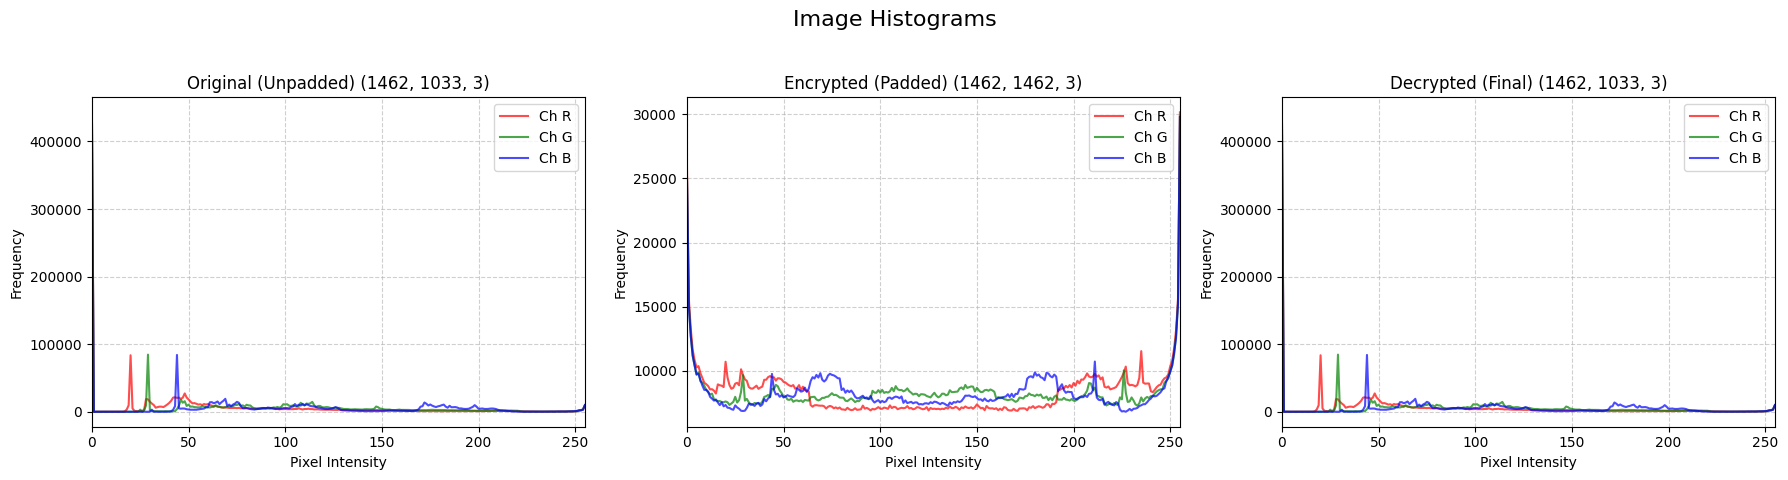

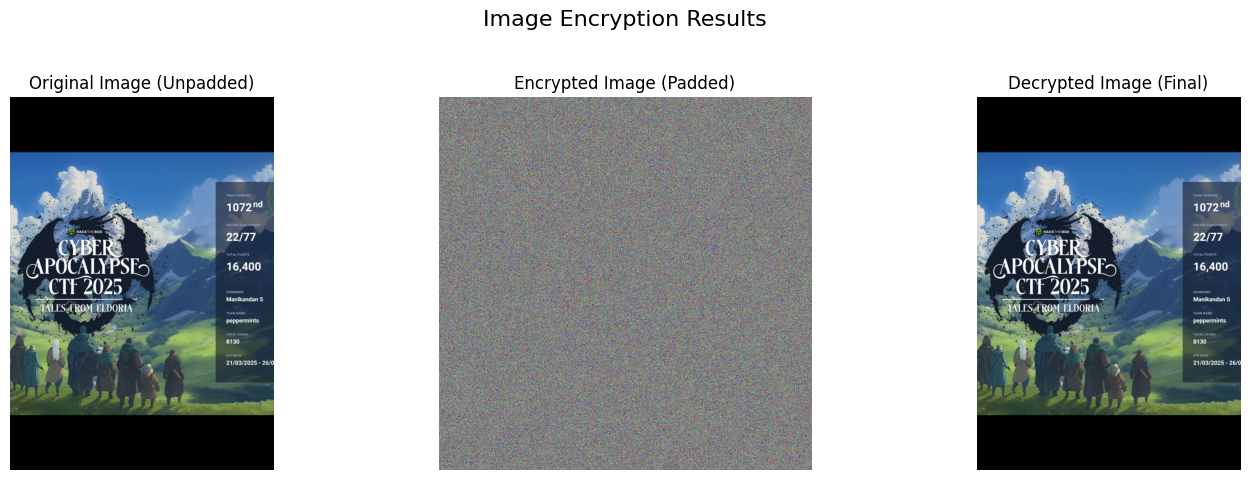


--- Key Sensitivity Test ---
Attempting decryption with slightly modified key (x0 = 0.31415936535)...
Starting Decryption Process (on decompressed data)...
Applying Logistic Map decryption (x0=0.31415936535, r=3.9999)...
Applying Inverse Arnold's Cat Map with 10 iterations (a=1, b=1)...
Removing padding to restore original size (1462, 1033)...
Final decrypted size after unpadding: (1462, 1033)
Decryption completed in 2.7580 seconds.
Resulting PSNR (Wrong Key): 6.9098 dB
Resulting SSIM (Wrong Key): 0.0064
Key sensitivity test PASSED: Decryption with slightly wrong key produced significantly different result.

--- Task 8: Saving and Downloading Output ---
Compressed encrypted data saved as: encrypted_compressed_data.zlib
Final decrypted image saved as: decrypted_image.png
Initiating Colab downloads (if files were saved)...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Image Processing Script Execution Finished ---


Running in environment: colab
--- Image Input Setup ---
Please upload an image file:


Saving hehe.png to hehe (1).png
Input selected: hehe (1).png

--- Starting Image Processing Pipeline (ACM+Logistic+AES_CBC+Zlib) ---

1. Preprocessing...
Original image size: (1600, 1591), mode: RGB
Padded image size: (1600, 1600)
Original unpadded shape: (1600, 1591, 3)

2. Chaotic Encryption (ACM + Logistic)...
Applying ACM (10 iterations)...
Applying Logistic Map (x0=0.31415926535, r=3.9999)...
Chaotic Encryption completed in 3.6313 seconds.
Chaotic encrypted shape: (1600, 1600, 3), dtype: uint8

3. AES-CBC Encryption...
AES-CBC Encryption completed in 0.0139 seconds.
AES encrypted size (IV+Ciphertext): 7680032 bytes

4. Compressing AES data...
Compression: 7680032 -> 7682383 bytes (Ratio: 1.0003) in 0.3133s.

5. Hashing compressed data...
SHA-256 Hash: fec4d74518e67f5d3b2ca89386e9535a249904256227a69a0053b1f2c691c525

--- Verifying Compressed Data Integrity ---
Expected Hash: fec4d74518e67f5d3b2ca89386e9535a249904256227a69a0053b1f2c691c525
Calculated Hash:fec4d74518e67f5d3b2ca89386e

/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


MSE : 0.0000
PSNR: inf
SSIM: 1.0000
Entropy Orig: 7.1393 / Decrypted: 7.1393
SUCCESS: Decryption metrics look good.

--- Histograms & Image Display ---


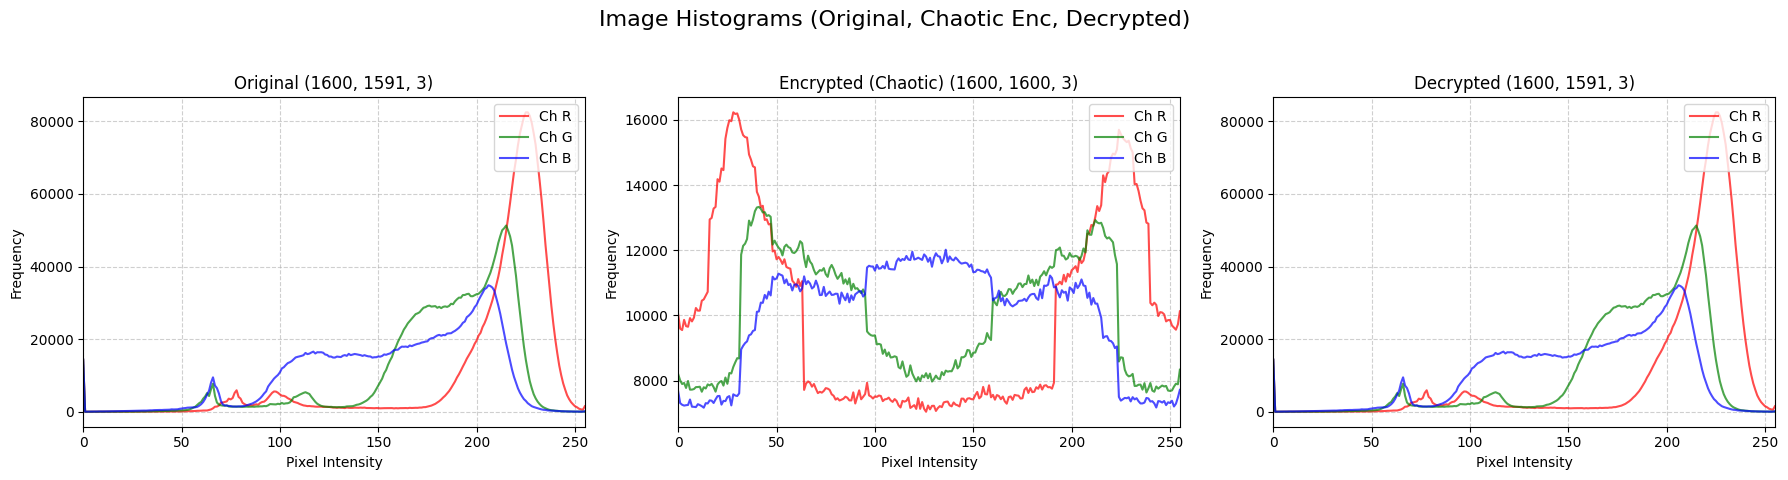

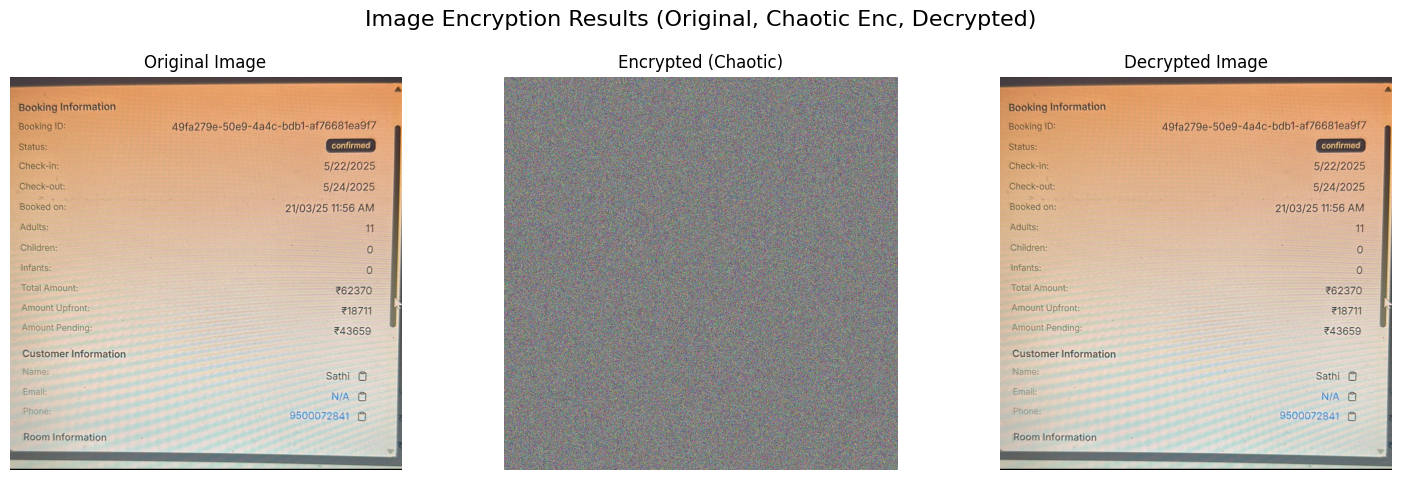


--- 11. Saving & Downloading ---
Saved compressed encrypted data: encrypted_aes_cbc_compressed.bin
Saved decrypted image: decrypted_image_aes_cbc.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


--- Script Execution Finished ---


In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import time
import math
from skimage.metrics import mean_squared_error as mse
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from skimage.measure import shannon_entropy
import hashlib
import warnings
import os
import base64
import zlib
import traceback

# --- Cryptography Imports ---
try:
    from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
    from cryptography.hazmat.primitives import padding as sym_padding
    from cryptography.hazmat.backends import default_backend
except ImportError:
    print("ERROR: The 'cryptography' library is not installed.")
    print("Please install it using: pip install cryptography")
    exit() # Exit if cryptography is missing

# --- Environment Specific Imports ---
try:
    from google.colab import files
    ENV = 'colab'
except ImportError:
    try:
        from IPython.display import display, HTML
        import ipywidgets as widgets
        ENV = 'jupyter'
    except ImportError:
        ENV = 'other'
print(f"Running in environment: {ENV}")

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning, module='skimage')
warnings.filterwarnings("ignore", category=UserWarning, module='PIL')
warnings.filterwarnings("ignore", category=FutureWarning, module='skimage')


# --- Task 1: Image Preprocessing ---
def preprocess_image(img_input, target_size=None, grayscale=False):
    """Loads, converts, optionally resizes and pads image to be square."""
    try:
        if isinstance(img_input, (BytesIO, bytes)):
            if isinstance(img_input, bytes): img_input = BytesIO(img_input)
            img_input.seek(0)
            img = Image.open(img_input)
        elif isinstance(img_input, str):
            img = Image.open(img_input)
        elif isinstance(img_input, Image.Image):
            img = img_input
        elif img_input is None: raise ValueError("No valid image input.")
        else: raise ValueError(f"Unsupported input type: {type(img_input)}")
    except Exception as e:
        print(f"Error loading image: {e}. Using fallback.")
        img_array = np.zeros((256, 256, 3), dtype=np.uint8)
        img_array[:, :, 0] = np.linspace(0, 255, 256)
        img_array[:, :, 1] = np.linspace(0, 255, 256).T
        img_array[:, :, 2] = 128
        img = Image.fromarray(img_array)

    original_size_before_processing = img.size
    print(f"Original image size: {original_size_before_processing}, mode: {img.mode}")

    if grayscale and img.mode != 'L': img = img.convert('L')
    elif not grayscale and img.mode not in ['RGB', 'RGBA']: img = img.convert('RGB')

    if img.mode == 'RGBA': # Handle transparency
        bg = Image.new("RGB", img.size, (255, 255, 255))
        try: bg.paste(img, mask=img.split()[3])
        except IndexError: bg.paste(img)
        img = bg

    if target_size: # Resize
        if isinstance(target_size, (list, tuple)) and len(target_size) == 2:
            img = img.resize(target_size, Image.Resampling.LANCZOS)
            print(f"Resized image size: {img.size}")
        else: print(f"Warning: Invalid target_size {target_size}. Skipping resize.")

    img_array = np.array(img, dtype=np.uint8)

    # Padding to square shape for ACM
    h, w = img_array.shape[:2]
    padded = False
    if h != w:
        padded = True
        max_dim = max(h, w)
        pad_h = max_dim - h; pad_w = max_dim - w
        pad_top = pad_h // 2; pad_left = pad_w // 2
        pad_width = ((pad_top, pad_h - pad_top), (pad_left, pad_w - pad_left))
        if img_array.ndim == 3: pad_width += ((0, 0),) # Add channel padding spec
        img_array = np.pad(img_array, pad_width, mode='constant', constant_values=0)
        print(f"Padded image size: {img_array.shape[:2]}")

    return img_array, original_size_before_processing, padded

# --- Task 2: Encryption (Chaos: ACM + Logistic Map) ---
def arnold_cat_map(img_array, iterations, a=1, b=1):
    if img_array.shape[0] != img_array.shape[1]: raise ValueError("ACM requires a square image.")
    rows, cols = img_array.shape[:2]
    shuffled_img = np.zeros_like(img_array)
    x, y = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    for i in range(iterations):
        x_new = (x + b * y) % rows
        y_new = (a * x + (a * b + 1) * y) % cols
        x, y = x_new, y_new # Update coords for next iteration (more efficient)

    orig_x, orig_y = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    if img_array.ndim == 3:
        for c in range(img_array.shape[2]): shuffled_img[x, y, c] = img_array[orig_x, orig_y, c]
    else: shuffled_img[x, y] = img_array[orig_x, orig_y]
    return shuffled_img

def inverse_arnold_cat_map(shuffled_img_array, iterations, a=1, b=1):
    if shuffled_img_array.shape[0] != shuffled_img_array.shape[1]: raise ValueError("Inverse ACM requires a square image.")
    rows, cols = shuffled_img_array.shape[:2]
    unshuffled_img = np.zeros_like(shuffled_img_array)
    x_shuffled, y_shuffled = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')

    inv_coeff_00 = a * b + 1; inv_coeff_01 = -b
    inv_coeff_10 = -a; inv_coeff_11 = 1

    for i in range(iterations):
        x_orig = (inv_coeff_00 * x_shuffled + inv_coeff_01 * y_shuffled) % rows
        y_orig = (inv_coeff_10 * x_shuffled + inv_coeff_11 * y_shuffled) % cols
        x_shuffled, y_shuffled = x_orig, y_orig

    final_shuffled_x, final_shuffled_y = np.meshgrid(np.arange(rows), np.arange(cols), indexing='ij')
    if shuffled_img_array.ndim == 3:
        for c in range(shuffled_img_array.shape[2]): unshuffled_img[x_shuffled, y_shuffled, c] = shuffled_img_array[final_shuffled_x, final_shuffled_y, c]
    else: unshuffled_img[x_shuffled, y_shuffled] = shuffled_img_array[final_shuffled_x, final_shuffled_y]
    return unshuffled_img

def generate_logistic_map_sequence(x0, r, size):
    x0 = float(x0); r = float(r)
    sequence = np.zeros(size, dtype=np.float64)
    x = x0
    for _ in range(100): x = r * x * (1.0 - x) # Burn-in
    for i in range(size):
        x = r * x * (1.0 - x)
        sequence[i] = x
    return sequence

def logistic_map_encrypt_decrypt(img_array, x0, r):
    img_array = img_array.astype(np.uint8) # Ensure uint8
    total_pixels = img_array.size
    if not (3.57 <= r <= 4.0): print(f"Warning: Logistic map r={r} may not be chaotic.")
    if not (0 < x0 < 1): x0 = np.clip(x0, 1e-6, 1.0 - 1e-6)

    try:
        keystream_float = generate_logistic_map_sequence(x0, r, total_pixels)
        keystream_uint8 = (keystream_float * 255.999999).astype(np.uint8)
    except OverflowError: raise ValueError(f"Logistic map overflowed with r={r}, x0={x0}.")

    img_flat = img_array.flatten()
    if len(img_flat) != len(keystream_uint8): raise ValueError("Size mismatch: image vs keystream.")

    processed_flat = np.bitwise_xor(img_flat, keystream_uint8)
    return processed_flat.reshape(img_array.shape).astype(np.uint8)

def chaotic_encrypt_image(img_array, acm_iterations, logistic_x0, logistic_r, acm_a=1, acm_b=1):
    start_time = time.time()
    print(f"Applying ACM ({acm_iterations} iterations)...")
    try: shuffled_img = arnold_cat_map(img_array.astype(np.uint8), acm_iterations, acm_a, acm_b)
    except ValueError as e: print(f"Error during ACM: {e}"); return None, 0

    print(f"Applying Logistic Map (x0={logistic_x0}, r={logistic_r})...")
    try: encrypted_img = logistic_map_encrypt_decrypt(shuffled_img, logistic_x0, logistic_r)
    except ValueError as e: print(f"Error during Logistic Map: {e}"); return None, time.time() - start_time

    enc_time = time.time() - start_time
    print(f"Chaotic Encryption completed in {enc_time:.4f} seconds.")
    return encrypted_img, enc_time

# --- Task 2.5: Encryption (AES-CBC) ---
def aes_cbc_encrypt(data_bytes, key):
    """Encrypts byte data using AES-CBC with PKCS7 padding."""
    if not isinstance(data_bytes, bytes): raise TypeError("Input data must be bytes.")
    if len(key) not in [16, 24, 32]: raise ValueError("AES key must be 16, 24, or 32 bytes.")

    backend = default_backend()
    iv = os.urandom(16)
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=backend)
    encryptor = cipher.encryptor()
    padder = sym_padding.PKCS7(algorithms.AES.block_size).padder()
    padded_data = padder.update(data_bytes) + padder.finalize()
    start_time = time.time()
    try: ciphertext = encryptor.update(padded_data) + encryptor.finalize()
    except Exception as e: print(f"Error during AES encryption: {e}"); traceback.print_exc(); return None, 0
    aes_time = time.time() - start_time
    print(f"AES-CBC Encryption completed in {aes_time:.4f} seconds.")
    return iv + ciphertext, aes_time

def aes_cbc_decrypt(encrypted_data_with_iv, key):
    """Decrypts AES-CBC encrypted data (IV prepended) and removes padding."""
    if not isinstance(encrypted_data_with_iv, bytes): raise TypeError("Input data must be bytes.")
    if len(key) not in [16, 24, 32]: raise ValueError("AES key must be 16, 24, or 32 bytes.")
    if len(encrypted_data_with_iv) < 16: raise ValueError("Encrypted data too short (missing IV?).")

    backend = default_backend()
    iv = encrypted_data_with_iv[:16]
    ciphertext = encrypted_data_with_iv[16:]
    cipher = Cipher(algorithms.AES(key), modes.CBC(iv), backend=backend)
    decryptor = cipher.decryptor()
    start_time = time.time()
    try:
        padded_plaintext = decryptor.update(ciphertext) + decryptor.finalize()
        unpadder = sym_padding.PKCS7(algorithms.AES.block_size).unpadder()
        plaintext = unpadder.update(padded_plaintext) + unpadder.finalize()
    except ValueError as e: print(f"AES Decryption FAILED: Likely incorrect key or corrupted data (Padding Error). {e}"); return None, time.time() - start_time
    except Exception as e: print(f"Error during AES decryption: {e}"); traceback.print_exc(); return None, time.time() - start_time
    aes_time = time.time() - start_time
    print(f"AES-CBC Decryption completed in {aes_time:.4f} seconds.")
    return plaintext, aes_time

# --- Task 3: Compression & Hashing ---
def compress_data(data_bytes):
    if not isinstance(data_bytes, bytes): print("Error: Input must be bytes."); return None, 0
    start_time = time.time()
    compressed_bytes = zlib.compress(data_bytes, level=7)
    comp_time = time.time() - start_time
    ratio = len(compressed_bytes) / len(data_bytes) if len(data_bytes) > 0 else 0
    print(f"Compression: {len(data_bytes)} -> {len(compressed_bytes)} bytes (Ratio: {ratio:.4f}) in {comp_time:.4f}s.")
    return compressed_bytes, comp_time

def calculate_hash_bytes(byte_data):
    if not isinstance(byte_data, bytes): raise TypeError("Input must be bytes.")
    return hashlib.sha256(byte_data).hexdigest()

# --- Task 4: Decompression, Decryption & Integrity ---
def decompress_data(compressed_bytes):
    if not isinstance(compressed_bytes, bytes): print("Error: Input must be bytes."); return None, 0
    start_time = time.time()
    try: decompressed_bytes = zlib.decompress(compressed_bytes)
    except zlib.error as e: print(f"Decompression error: {e}"); return None, time.time() - start_time
    decomp_time = time.time() - start_time
    print(f"Decompression completed in {decomp_time:.4f} seconds.")
    return decompressed_bytes, decomp_time

def chaotic_decrypt_image(decrypted_chaotic_img_array, acm_iterations, logistic_x0, logistic_r, original_shape_before_padding, padded, acm_a=1, acm_b=1):
    if decrypted_chaotic_img_array is None: print("Error: Cannot chaotic decrypt None."); return None, 0
    start_time = time.time()

    print(f"Applying Logistic Map decryption (x0={logistic_x0}, r={logistic_r})...")
    try: decrypted_shuffled_img = logistic_map_encrypt_decrypt(decrypted_chaotic_img_array, logistic_x0, logistic_r)
    except ValueError as e: print(f"Error during Logistic Map decrypt: {e}"); return None, time.time() - start_time

    print(f"Applying Inverse ACM ({acm_iterations} iterations)...")
    try: unshuffled_padded_img = inverse_arnold_cat_map(decrypted_shuffled_img, acm_iterations, acm_a, acm_b)
    except ValueError as e: print(f"Error during Inverse ACM: {e}"); return None, time.time() - start_time # Return None if inverse ACM fails

    final_decrypted_img = unshuffled_padded_img
    if padded:
        current_h, current_w = unshuffled_padded_img.shape[:2]
        orig_h, orig_w = original_shape_before_padding
        if orig_h > current_h or orig_w > current_w: print(f"Error: Original dimensions > current. Cannot unpad."); return None, time.time() - start_time # Return None if unpadding impossible
        if current_h != orig_h or current_w != orig_w:
            pad_h_total = current_h - orig_h; pad_w_total = current_w - orig_w
            pad_top = pad_h_total // 2; pad_left = pad_w_total // 2
            try:
                if unshuffled_padded_img.ndim == 3: final_decrypted_img = unshuffled_padded_img[pad_top : pad_top + orig_h, pad_left : pad_left + orig_w, :]
                else: final_decrypted_img = unshuffled_padded_img[pad_top : pad_top + orig_h, pad_left : pad_left + orig_w]
                print(f"Unpadded to original size: {final_decrypted_img.shape[:2]}")
            except IndexError as e: print(f"Error during unpadding slice: {e}"); return None, time.time() - start_time # Return None on slice error
        else: print("Padding flag set, but dimensions match original.")
    else: print("No padding added initially.")

    dec_time = time.time() - start_time
    print(f"Chaotic Decryption completed in {dec_time:.4f} seconds.")
    return final_decrypted_img.astype(np.uint8), dec_time

def verify_integrity_compressed(received_compressed_data, original_compressed_hash):
    print(f"\n--- Verifying Compressed Data Integrity ---")
    if not isinstance(received_compressed_data, bytes): print("Error: Data for hash verify not bytes."); return False
    if not isinstance(original_compressed_hash, str) or len(original_compressed_hash) != 64: print("Error: Invalid original hash."); return False

    calculated_hash = calculate_hash_bytes(received_compressed_data)
    print(f"Expected Hash: {original_compressed_hash}")
    print(f"Calculated Hash:{calculated_hash}")
    if original_compressed_hash == calculated_hash: print("Integrity Check PASSED."); return True
    else: print("Integrity Check FAILED: Hashes DO NOT match."); return False

# --- Task 5: Performance & Security Analysis ---
def calculate_metrics(img_orig, img_processed, data_range=255):
    if not isinstance(img_orig, np.ndarray) or not isinstance(img_processed, np.ndarray): print("Error: Inputs must be NumPy arrays."); return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': float('nan'), 'entropy_proc': float('nan')}
    img_orig = img_orig.astype(np.uint8); img_processed = img_processed.astype(np.uint8)

    if img_orig.shape != img_processed.shape:
        print(f"Warning: Shape mismatch for metrics: {img_orig.shape} vs {img_processed.shape}.");
        try: ent_orig = shannon_entropy(img_orig)
        except: ent_orig = float('nan')
        return {'mse': float('inf'), 'psnr': 0, 'ssim': 0, 'entropy_orig': ent_orig, 'entropy_proc': float('nan')}

    try: mse_val = mse(img_orig, img_processed)
    except Exception as e: print(f"MSE Error: {e}"); mse_val = float('inf')
    try: psnr_val = psnr(img_orig, img_processed, data_range=data_range)
    except Exception as e: print(f"PSNR Error: {e}"); psnr_val = 0
    try:
        channel_axis = -1 if img_orig.ndim == 3 else None
        win_size = min(7, min(img_orig.shape[:2]))
        if win_size < 3: ssim_val = 0
        else:
           if win_size % 2 == 0: win_size -= 1
           ssim_val = ssim(img_orig, img_processed, data_range=data_range, channel_axis=channel_axis, win_size=win_size)
    except Exception as e: print(f"SSIM Error: {e}"); ssim_val = 0
    try: entropy_orig_val = shannon_entropy(img_orig)
    except Exception as e: print(f"Entropy Orig Error: {e}"); entropy_orig_val = float('nan')
    try: entropy_proc_val = shannon_entropy(img_processed)
    except Exception as e: print(f"Entropy Proc Error: {e}"); entropy_proc_val = float('nan')

    return {'mse': mse_val, 'psnr': psnr_val, 'ssim': ssim_val, 'entropy_orig': entropy_orig_val, 'entropy_proc': entropy_proc_val}

def plot_histograms(img_orig, img_encrypted, img_decrypted):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle('Image Histograms (Original, Chaotic Enc, Decrypted)', fontsize=16)
    colors = ('r', 'g', 'b'); labels = ('Original', 'Encrypted (Chaotic)', 'Decrypted')
    images = (img_orig, img_encrypted, img_decrypted)

    for i, img in enumerate(images):
        ax = axes[i]; ax.set_title(labels[i] + (f" {img.shape}" if img is not None else " (N/A)"))
        if img is None: ax.text(0.5, 0.5, 'N/A', ha='center', va='center', transform=ax.transAxes); continue
        ax.set_xlabel('Pixel Intensity'); ax.set_ylabel('Frequency')
        try:
            if img.ndim == 3: # Color
                for c_idx, color in enumerate(colors):
                    if c_idx < img.shape[2]:
                        hist, bin_edges = np.histogram(img[:, :, c_idx].ravel(), bins=256, range=[0, 256])
                        ax.plot(bin_edges[:-1], hist, color=color, alpha=0.7, label=f'Ch {color.upper()}')
                if img.shape[2] > 1: ax.legend(loc='upper right')
            elif img.ndim == 2: # Grayscale
                hist, bin_edges = np.histogram(img.ravel(), bins=256, range=[0, 256])
                ax.plot(bin_edges[:-1], hist, color='black')
            ax.set_xlim([0, 255]); ax.grid(True, linestyle='--', alpha=0.6)
        except Exception as e: print(f"Hist plot error for {labels[i]}: {e}"); ax.text(0.5, 0.5, 'Plot Err', ha='center', va='center')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def display_images(img_orig, img_encrypted, img_decrypted):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle('Image Encryption Results (Original, Chaotic Enc, Decrypted)', fontsize=16)
    titles = ['Original Image', 'Encrypted (Chaotic)', 'Decrypted Image']
    images = [img_orig, img_encrypted, img_decrypted]

    for ax, img, title in zip(axes, images, titles):
        ax.set_title(title); ax.axis('off')
        if img is not None:
            cmap = 'gray' if img.ndim == 2 else None
            try: ax.imshow(img, cmap=cmap)
            except Exception as e: print(f"Display error '{title}': {e}"); ax.text(0.5, 0.5, 'Disp Err', ha='center', va='center')
        else: ax.text(0.5, 0.5, 'N/A', ha='center', va='center')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]); plt.show()

def create_download_link_jupyter(filename, data_bytes, link_text, mime_type='application/octet-stream'):
    if ENV != 'jupyter' or not isinstance(data_bytes, bytes): return ""
    try:
        b64 = base64.b64encode(data_bytes).decode('ascii')
        return f'<a href="data:{mime_type};base64,{b64}" download="{os.path.basename(filename)}">{link_text}</a>'
    except Exception as e: print(f"Error creating download link: {e}"); return ""


# --- Configuration ---
ACM_ITERATIONS = 10
ACM_A = 1; ACM_B = 1
LOGISTIC_X0 = 0.31415926535
LOGISTIC_R = 3.9999
# AES Key (FIXED: Ensure exactly 32 bytes for AES-256)
AES_KEY = b'This is my secret 32 byte key!!' # Original key (30 bytes)
AES_KEY = AES_KEY.ljust(32, b'\0') # Pad with null bytes to 32 bytes

USE_GRAYSCALE = False
RESIZE_TARGET = None #(256, 256)

COMPRESSED_ENCRYPTED_FILENAME = "encrypted_aes_cbc_compressed.bin"
DECRYPTED_FILENAME = "decrypted_image_aes_cbc.png"

# --- Global variables ---
original_image_unpadded = None
original_image_padded = None
chaotic_encrypted_image = None
aes_encrypted_data_with_iv = None
compressed_encrypted_data = None
transmitted_hash = None
decompressed_aes_data_with_iv = None
decrypted_chaotic_image = None
final_decrypted_image = None
integrity_check_passed = False
chaotic_encryption_time = 0
aes_encryption_time = 0
compression_time = 0
decompression_time = 0
aes_decryption_time = 0
chaotic_decryption_time = 0
original_size_before_padding = (0,0)
was_padded = False
chaotic_encrypted_shape = None
chaotic_encrypted_dtype = None

# --- Get Image Input ---
uploaded_file_name = None
img_data_input = None
print("--- Image Input Setup ---")
if ENV == 'colab':
    print("Please upload an image file:")
    try:
        uploaded = files.upload()
        if uploaded: uploaded_file_name = next(iter(uploaded)); img_data_input = uploaded[uploaded_file_name]
        else: img_data_input = None
    except Exception as e: print(f"Colab upload error: {e}"); img_data_input = None
elif ENV == 'jupyter':
     print("Use widget to upload image, then run next cell.")
     uploader = widgets.FileUpload(accept='image/*', multiple=False, description="Upload")
     display(uploader)
else: # 'other' environment
    file_path = "input_image.png" # <<< CHANGE THIS PATH IF NEEDED
    if os.path.exists(file_path): img_data_input = file_path; uploaded_file_name = os.path.basename(file_path); print(f"Using local file: {file_path}")
    else: print(f"File not found: {file_path}"); img_data_input = None

if img_data_input is not None and uploaded_file_name: print(f"Input selected: {uploaded_file_name}")
elif img_data_input is None and ENV != 'jupyter': print("No input image selected, using fallback.")

# --- Processing & Analysis (Run after upload in Jupyter) ---
if ENV == 'jupyter':
    print("\n--- Waiting for Jupyter Upload (if applicable) before processing ---")
    # This cell should be run *after* the user uploads via the widget in the previous cell
    pass # Placeholder - the actual processing logic is in the next section

# --- Main Pipeline ---
print("\n--- Starting Image Processing Pipeline (ACM+Logistic+AES_CBC+Zlib) ---")
# Add a check here for Jupyter environment to ensure upload happened if needed
if ENV == 'jupyter' and 'uploader' in locals() and uploader.value:
    try:
        uploaded_file_key = list(uploader.value.keys())[0]
        uploaded_file_info = uploader.value[uploaded_file_key]
        uploaded_file_name = uploaded_file_info['metadata']['name']
        img_data_input = uploaded_file_info['content'] # Bytes
        print(f"Processing uploaded file (Jupyter): {uploaded_file_name}")
    except Exception as e: print(f"Error processing Jupyter upload: {e}"); img_data_input = None
elif ENV == 'jupyter' and ('img_data_input' not in locals() or img_data_input is None):
    print("Warning: Jupyter environment detected, but no file seems uploaded via widget.")
    # Decide if you want to proceed with fallback or raise an error
    # img_data_input = None # Ensure fallback logic triggers if needed

try:
    # 1. Preprocessing
    print("\n1. Preprocessing...")
    original_image_padded, original_size_before_padding, was_padded = preprocess_image(
        img_data_input, target_size=RESIZE_TARGET, grayscale=USE_GRAYSCALE)
    if original_image_padded is None: raise ValueError("Preprocessing failed.")

    h_orig, w_orig = original_size_before_padding
    if was_padded:
        pad_h = original_image_padded.shape[0] - h_orig; pad_w = original_image_padded.shape[1] - w_orig
        pad_top = pad_h // 2; pad_left = pad_w // 2
        if original_image_padded.ndim == 3: original_image_unpadded = original_image_padded[pad_top:pad_top+h_orig, pad_left:pad_left+w_orig, :].copy()
        else: original_image_unpadded = original_image_padded[pad_top:pad_top+h_orig, pad_left:pad_left+w_orig].copy()
    else: original_image_unpadded = original_image_padded.copy()
    print(f"Original unpadded shape: {original_image_unpadded.shape}")

    # 2. Chaotic Encryption
    print("\n2. Chaotic Encryption (ACM + Logistic)...")
    chaotic_encrypted_image, chaotic_encryption_time = chaotic_encrypt_image(
        original_image_padded, ACM_ITERATIONS, LOGISTIC_X0, LOGISTIC_R, ACM_A, ACM_B)
    if chaotic_encrypted_image is None: raise ValueError("Chaotic Encryption failed.")
    chaotic_encrypted_shape = chaotic_encrypted_image.shape
    chaotic_encrypted_dtype = chaotic_encrypted_image.dtype
    print(f"Chaotic encrypted shape: {chaotic_encrypted_shape}, dtype: {chaotic_encrypted_dtype}")

    # 3. AES-CBC Encryption
    print("\n3. AES-CBC Encryption...")
    chaotic_encrypted_bytes = chaotic_encrypted_image.tobytes()
    aes_encrypted_data_with_iv, aes_encryption_time = aes_cbc_encrypt(chaotic_encrypted_bytes, AES_KEY)
    if aes_encrypted_data_with_iv is None: raise ValueError("AES-CBC Encryption failed.")
    print(f"AES encrypted size (IV+Ciphertext): {len(aes_encrypted_data_with_iv)} bytes")

    # 4. Compression
    print("\n4. Compressing AES data...")
    compressed_encrypted_data, compression_time = compress_data(aes_encrypted_data_with_iv)
    if compressed_encrypted_data is None: raise ValueError("Compression failed.")

    # 5. Hashing Compressed Data
    print("\n5. Hashing compressed data...")
    transmitted_hash = calculate_hash_bytes(compressed_encrypted_data)
    print(f"SHA-256 Hash: {transmitted_hash}")

    # --- Simulate Reception ---
    received_compressed_data = compressed_encrypted_data
    received_hash = transmitted_hash

    # 6. Verify Integrity (Hash Check)
    integrity_check_passed = verify_integrity_compressed(received_compressed_data, received_hash)

    # --- Decryption Pipeline (if integrity ok) ---
    if integrity_check_passed:
        # 7. Decompression
        print("\n7. Decompressing data...")
        decompressed_aes_data_with_iv, decompression_time = decompress_data(received_compressed_data)
        if decompressed_aes_data_with_iv is None: raise ValueError("Decompression failed.")

        # 8. AES-CBC Decryption
        print("\n8. AES-CBC Decryption...")
        decrypted_chaotic_bytes, aes_decryption_time = aes_cbc_decrypt(decompressed_aes_data_with_iv, AES_KEY)
        if decrypted_chaotic_bytes is None: raise ValueError("AES-CBC Decryption failed (check key/data).")

        # Convert back to numpy array
        try:
            dtype_itemsize = np.dtype(chaotic_encrypted_dtype).itemsize
            expected_bytes = np.prod(chaotic_encrypted_shape) * dtype_itemsize
            if len(decrypted_chaotic_bytes) != expected_bytes: raise ValueError(f"Size mismatch after AES decrypt: expected {expected_bytes}, got {len(decrypted_chaotic_bytes)}")
            decrypted_chaotic_image = np.frombuffer(decrypted_chaotic_bytes, dtype=chaotic_encrypted_dtype).reshape(chaotic_encrypted_shape)
            print(f"Reshaped after AES decrypt: {decrypted_chaotic_image.shape}")
        except Exception as e: raise ValueError(f"Failed to reshape after AES decrypt: {e}")

        # 9. Chaotic Decryption
        print("\n9. Chaotic Decryption (Inverse Logistic + Inverse ACM)...")
        final_decrypted_image, chaotic_decryption_time = chaotic_decrypt_image(
            decrypted_chaotic_image, ACM_ITERATIONS, LOGISTIC_X0, LOGISTIC_R,
            original_size_before_padding, was_padded, ACM_A, ACM_B)
        if final_decrypted_image is None: raise ValueError("Chaotic Decryption failed.")

    else:
        print("\nSkipping Decompression & Decryption due to failed integrity check.")
        final_decrypted_image = None

    # 10. Analysis
    print("\n--- 10. Analysis ---")
    print("--- Timing ---")
    print(f"Chaotic Encrypt: {chaotic_encryption_time:.4f}s")
    print(f"AES Encrypt:     {aes_encryption_time:.4f}s")
    print(f"Compress:        {compression_time:.4f}s")
    print(f"Decompress:      {decompression_time:.4f}s")
    print(f"AES Decrypt:     {aes_decryption_time:.4f}s")
    print(f"Chaotic Decrypt: {chaotic_decryption_time:.4f}s")
    total_time = chaotic_encryption_time+aes_encryption_time+compression_time+decompression_time+aes_decryption_time+chaotic_decryption_time
    print(f"Total Pipeline Time: ~{total_time:.4f}s")

    print("\n--- Similarity Metrics (Original vs Final Decrypted) ---")
    if integrity_check_passed and final_decrypted_image is not None:
        metrics = calculate_metrics(original_image_unpadded, final_decrypted_image)
        psnr_val = metrics.get('psnr', 0)
        psnr_str = f"{psnr_val:.4f} dB" if np.isfinite(psnr_val) else "inf"
        print(f"MSE : {metrics.get('mse', 'N/A'):.4f}")
        print(f"PSNR: {psnr_str}")
        print(f"SSIM: {metrics.get('ssim', 'N/A'):.4f}")
        print(f"Entropy Orig: {metrics.get('entropy_orig', 'N/A'):.4f} / Decrypted: {metrics.get('entropy_proc', 'N/A'):.4f}")
        if metrics.get('mse', 1) < 1e-6: print("SUCCESS: Decryption metrics look good.")
        else: print("WARNING: Differences found between original and decrypted.")
    else: print("Skipped metrics (Integrity fail or Decryption error).")

    print("\n--- Histograms & Image Display ---")
    plot_histograms(original_image_unpadded, chaotic_encrypted_image, final_decrypted_image if integrity_check_passed else None)
    display_images(original_image_unpadded, chaotic_encrypted_image, final_decrypted_image if integrity_check_passed else None)

    # 11. Save & Download
    print("\n--- 11. Saving & Downloading ---")
    if compressed_encrypted_data is not None:
        try:
            with open(COMPRESSED_ENCRYPTED_FILENAME, "wb") as f: f.write(compressed_encrypted_data)
            print(f"Saved compressed encrypted data: {COMPRESSED_ENCRYPTED_FILENAME}")
        except Exception as e: print(f"Error saving compressed data: {e}")
    dec_img_pil = None
    if integrity_check_passed and final_decrypted_image is not None:
        try:
            dec_img_pil = Image.fromarray(final_decrypted_image)
            dec_img_pil.save(DECRYPTED_FILENAME)
            print(f"Saved decrypted image: {DECRYPTED_FILENAME}")
        except Exception as e: print(f"Error saving decrypted image: {e}")

    # Trigger Download
    if ENV == 'colab':
        if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME): files.download(COMPRESSED_ENCRYPTED_FILENAME)
        if dec_img_pil and os.path.exists(DECRYPTED_FILENAME): files.download(DECRYPTED_FILENAME)
    elif ENV == 'jupyter':
        links_html = []
        if compressed_encrypted_data:
            link1 = create_download_link_jupyter(COMPRESSED_ENCRYPTED_FILENAME, compressed_encrypted_data, f"Download Encrypted ({COMPRESSED_ENCRYPTED_FILENAME})")
            if link1: links_html.append(link1)
        if dec_img_pil and os.path.exists(DECRYPTED_FILENAME):
             try:
                 with open(DECRYPTED_FILENAME, "rb") as f: dec_png_bytes = f.read()
                 link2 = create_download_link_jupyter(DECRYPTED_FILENAME, dec_png_bytes, f"Download Decrypted ({DECRYPTED_FILENAME})", 'image/png')
                 if link2: links_html.append(link2)
             except Exception as e: print(f"Error reading decrypted for download link: {e}")
        if links_html: display(HTML("<br>".join(links_html)))
        else: print("No files available for Jupyter download links.")
    else: # 'other'
        print("\nOutput Files (if saved):")
        if os.path.exists(COMPRESSED_ENCRYPTED_FILENAME): print(f"- Encrypted: {os.path.abspath(COMPRESSED_ENCRYPTED_FILENAME)}")
        if dec_img_pil and os.path.exists(DECRYPTED_FILENAME): print(f"- Decrypted: {os.path.abspath(DECRYPTED_FILENAME)}")

except Exception as e:
    print(f"\n--- ERROR IN PIPELINE ---")
    print(f"Error Type: {type(e).__name__}")
    print(f"Error Message: {e}")
    print("Traceback:")
    traceback.print_exc()
finally:
    print("\n--- Script Execution Finished ---")